In [21]:
import os.path

import pandas as pd
import os
os.chdir('../')


In [30]:
from IDV_CS_Model import *
from CS_based_early_stopping import *
import seaborn as sns
import matplotlib.pyplot as plt
from utils import *
import numpy as np
from collections import Counter
import sys
import json
DATA_DIR = 'data/Evaluation_CoTs/Algo_Design_Data/'
# DF_NAME = 'GSM8K'
# DIFFICULTY = 'easy'
# NUM_OF_SAMPLES = 500
# NUM_OF_COT = 40
# MODEL = 'gpt-3.5-turbo-0125'

In [31]:
file_path = os.path.join(DATA_DIR, 'final_extracted.json')
df_with_features_raw = pd.read_json(file_path, lines=True)


In [32]:
feature_li =['LEN','QUA_IM','DIF_IV','SIM_INPUT','SIM_COT_BIGRAM','SIM_COT_AGG','SIM_AC_BIGRAM','SIM_AC_PW']
df_with_features_raw = df_with_features_raw[~df_with_features_raw.Model.str.startswith('gpt-4')]

_,df_with_features = train_test_split_stratify(df_with_features_raw,test_size=0.3,random_state =2024)
_, coef = trained_LR_model(df_with_features_raw, feature_li, report_auroc=False,train_mode=True)
print(coef)
coe = coef[1:]
intercept = coef[0]

/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

Train DataFrame:
Model
llama3_cleaned             2099
claude-3-haiku-20240307    2097
gpt-3.5-turbo-0125         2078
Name: count, dtype: int64
Name
GSM8K_test               1050
GSM8K_hard               1050
BigBench_hard            1047
MathQA_challenge_test    1047
MathQA_dev               1041
BigBench_easy            1039
Name: count, dtype: int64

Test DataFrame:
Model
claude-3-haiku-20240307    900
llama3_cleaned             900
gpt-3.5-turbo-0125         890
Name: count, dtype: int64
Name
GSM8K_hard               450
BigBench_hard            450
GSM8K_test               450
MathQA_challenge_test    448
MathQA_dev               447
BigBench_easy            445
Name: count, dtype: int64
Train DataFrame:
Model
llama3_cleaned             2099
claude-3-haiku-20240307    2097
gpt-3.5-turbo-0125         2078
Name: count, dtype: int64
Name
GSM8K_test               1050
GSM8K_hard               1050
BigBench_hard            1047
MathQA_challenge_test    1047
MathQA_dev               10

/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ -2.69211303  -0.10624389  -1.22847074 -24.25896923   2.26368579
  -0.30680942   2.62170185   0.46058559   1.18182681]


In [53]:
coe 

array([ -0.10624389,  -1.22847074, -24.25896923,   2.26368579,
        -0.30680942,   2.62170185,   0.46058559,   1.18182681])

In [33]:
print(coef)

[ -2.69211303  -0.10624389  -1.22847074 -24.25896923   2.26368579
  -0.30680942   2.62170185   0.46058559   1.18182681]


In [34]:
df_with_features

,id,Name,Model,correct answer,CoT answers,Correctness,SIM_COT_AGG,SIM_INPUT,QUA_IM,LEN,SIM_COT_BIGRAM,SIM_AC_BIGRAM,SIM_AC_PW,DIF_IV,SC_correctness,ES_correctness,ES_steps,asc_correctness,asc_steps
8112,8112,MathQA_challenge_test,gpt-3.5-turbo-0125,c,"[c, c, c, c, c, c, c, c, c, c, c, c, c, c, c, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.5, 1.0, 0.9615384615, 0.9807692308, 0.98076...","[0.3015873016, 0.3015873016, 0.3015873016, 0.3...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.5, 1.0, 0.9615384615, 0.9615384615, 1.0, 0....","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,1,5,1,4
4506,4506,BigBench_easy,gpt-3.5-turbo-0125,B,"[B, B, B, B, B, error, B, B, B, B, B, error, B...","[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, ...","[0.5, 0.8148148148000001, 0.8214285714, 0.7666...","[0.2537313433, 0.2786885246, 0.2903225806, 0.2...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, ...","[0.5, 0.8148148148000001, 0.9183673469, 0.8490...","[0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, ...","[0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, ...",1,1,5,1,4
6701,6701,MathQA_dev,claude-3-haiku-20240307,c,"[c, c, c, c, c, e, c, c, c, c, c, c, c, c, c, ...","[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.5, 0.5050505051, 0.5233644860000001, 0.6000...","[0.2584269663, 0.3289473684, 0.3150684932, 0.3...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, ...","[0.5, 0.5050505051, 0.6024096386000001, 0.6835...","[0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,1,5,1,4
4921,4921,BigBench_hard,gpt-3.5-turbo-0125,C,"[B, B, B, B, B, B, B, B, B, B, B, B, B, B, B, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.5, 0.6428571429000001, 0.35000000000000003,...","[0.3387096774, 0.328125, 0.23529411760000002, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.5, 0.6428571429000001, 0.4117647059, 0.4736...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,5,0,4
3638,3638,BigBench_easy,claude-3-haiku-20240307,A,"[C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.5, 0.3650793651, 0.3421052632, 0.2765957447...","[0.1956521739, 0.20800000000000002, 0.24786324...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, ...","[0.5, 0.3650793651, 0.36571428570000003, 0.331...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,5,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6588,6588,MathQA_dev,claude-3-haiku-20240307,c,"[c, e, c, c, c, c, c, c, c, c, c, c, a, c, c, ...","[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, ...","[0.5, 0.5446428571, 0.515625, 0.6015037594, 0....","[0.4036697248, 0.4018691589, 0.53125, 0.5, 0.4...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, ...","[0.5, 0.5446428571, 0.5321100917, 0.6534653465...","[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, ...","[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,1,7,1,7
6960,6960,MathQA_challenge_test,claude-3-haiku-20240307,b,"[b, b, d, b, b, b, b, b, b, b, b, b, d, b, d, ...","[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, ...","[0.5, 0.5268817204, 0.5204081633000001, 0.6037...","[0.3516483516, 0.3125, 0.3378378378, 0.3

In [35]:
config = {
    'benchmark': ['all','GSM8K_hard','GSM8K_test','MathQA_challenge_test','MathQA_dev','BigBench_hard','BigBench_easy'],
    'llm' : ['all','gpt-3.5','claude-3','llama3'],
    'N': [i for i in range(2,16)],
    'threshold': [0.1*i for i in range(11)],
    'stop_algo':['PositiveN','ConsistencyN'],
    'approximator': [customized_LR_model,trained_LR_model]
}

In [36]:
def get_data(df,benchmark='all',llm = 'all'):
    if benchmark == 'all':
        df_ = df
    else:
        df_ = df[df.Name == benchmark]
    
    if llm == 'gpt-4':
        df_final = df_[df_.Model.str.startswith('gpt-4')]
    elif llm == 'gpt-3.5':
        df_final = df_[df_.Model.str.startswith('gpt-3')]
    elif llm == 'claude-3':
        df_final = df_[df_.Model.str.startswith('claude-3')]
    elif llm == 'llama3':
        df_final = df_[df_.Model.str.startswith('llama3')]
    else:
        df_final = df_
    return df_final

In [37]:
for benchmark in config['benchmark']:
    print(len(get_data(df_with_features,benchmark=benchmark)))

2690
450
450
448
447
450
445


# step vs acc main

In [38]:
result_buffer = {
        'llm': [],
        'benchmark':[],
        'N': [],
        'stop_algo':[],
        'threshold': [],
        'SC_ACC': [],
        'ES_ACC': [],
        'ASC_ACC': [],
        'CASC_ACC': [],
        'SC_Avg_Cost': [],
        'ES_Avg_Cost': [],
        'ASC_Avg_Cost': [],
        'CASC_Avg_Cost': [],
    }
for benchmark in config['benchmark']:
    for llm in config['llm']:
        df_in = get_data(df_with_features,benchmark=benchmark,llm=llm)
        print(llm,benchmark)
        print('df_size is ',len(df_in))
        df_cs = customized_LR_model(df_in,feature_li,coe,intercept)
        N = 3
        threshold = 0.1
        stop_mechanism = 'PositiveN'
        df_results = CS_early_stopping(df=df_cs, threshold=threshold, N=N, stop_mechanism=stop_mechanism)
        df_model_comp_dict = {
                'llm': llm,
                'benchmark':benchmark,
                'N': N,
                'stop_algo':stop_mechanism,
                'threshold': threshold,
                'SC_ACC': round(df_results.SC_correctness.sum() / len(df_results),4),
                'ES_ACC': round(df_results.ES_correctness.sum() / len(df_results),4),
                'ASC_ACC': round(df_results.asc_correctness.sum() / len(df_results),4),
                'CASC_ACC': round(df_results.CS_correctness.sum() / len(df_results),4),
                'SC_Avg_Cost': 40,
                'ES_Avg_Cost': round(df_results.ES_steps.mean(),2),
                'ASC_Avg_Cost': round(df_results.asc_steps.mean(),2),
                'CASC_Avg_Cost': round(df_results.CS_steps.mean(),2),
            }
        for key,val in df_model_comp_dict.items():
            result_buffer[key].append(val)

all all
df_size is  2690
SC_ACC : 0.42862453531598516
ES_ACC : 0.4267657992565056
CS_ACC : 0.46022304832713756
SC_Avg_Steps : 40
ES_Avg_Steps : 15.74721189591078
CS_Avg_Steps : 5.8728624535315985
ASC_Avg_Steps : 13.399256505576208
ASC_ACC : 0.42973977695167287
gpt-3.5 all
df_size is  890


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.5067415730337078
ES_ACC : 0.503370786516854
CS_ACC : 0.5393258426966292
SC_Avg_Steps : 40
ES_Avg_Steps : 16.6438202247191
CS_Avg_Steps : 5.615730337078651
ASC_Avg_Steps : 14.193258426966292
ASC_ACC : 0.5056179775280899
claude-3 all
df_size is  900


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.5511111111111111
ES_ACC : 0.5488888888888889
CS_ACC : 0.5377777777777778
SC_Avg_Steps : 40
ES_Avg_Steps : 14.057777777777778
CS_Avg_Steps : 4.573333333333333
ASC_Avg_Steps : 12.092222222222222
ASC_ACC : 0.5555555555555556
llama3 all
df_size is  900


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.2288888888888889
ES_ACC : 0.2288888888888889
CS_ACC : 0.30444444444444446
SC_Avg_Steps : 40
ES_Avg_Steps : 16.55
CS_Avg_Steps : 7.426666666666667
ASC_Avg_Steps : 13.921111111111111
ASC_ACC : 0.2288888888888889
all GSM8K_hard
df_size is  450


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.3711111111111111
ES_ACC : 0.37777777777777777
CS_ACC : 0.37555555555555553
SC_Avg_Steps : 40
ES_Avg_Steps : 23.157777777777778
CS_Avg_Steps : 3.577777777777778
ASC_Avg_Steps : 19.784444444444443
ASC_ACC : 0.3711111111111111
gpt-3.5 GSM8K_hard
df_size is  150
SC_ACC : 0.42
ES_ACC : 0.43333333333333335
CS_ACC : 0.43333333333333335
SC_Avg_Steps : 40
ES_Avg_Steps : 22.773333333333333
CS_Avg_Steps : 4.28
ASC_Avg_Steps : 19.026666666666667
ASC_ACC : 0.42
claude-3 GSM8K_hard
df_size is  150
SC_ACC : 0.44
ES_ACC : 0.4533333333333333
CS_ACC : 0.44666666666666666
SC_Avg_Steps : 40
ES_Avg_Steps : 17.226666666666667
CS_Avg_Steps : 3.2933333333333334
ASC_Avg_Steps : 14.433333333333334
ASC_ACC : 0.44
llama3 GSM8K_hard
df_size is  150
SC_ACC : 0.25333333333333335
ES_ACC : 0.24666666666666667
CS_ACC : 0.24666666666666667
SC_Avg_Steps : 40
ES_Avg_Steps : 29.473333333333333
CS_Avg_Steps : 3.16
ASC_Avg_Steps : 25.893333333333334
ASC_ACC : 0.25333333333333335
all GSM8K_test
df_size is  450


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.8066666666666666
ES_ACC : 0.8066666666666666
CS_ACC : 0.7422222222222222
SC_Avg_Steps : 40
ES_Avg_Steps : 13.668888888888889
CS_Avg_Steps : 3.1577777777777776
ASC_Avg_Steps : 10.613333333333333
ASC_ACC : 0.8044444444444444
gpt-3.5 GSM8K_test
df_size is  150
SC_ACC : 0.8333333333333334
ES_ACC : 0.8333333333333334
CS_ACC : 0.76
SC_Avg_Steps : 40
ES_Avg_Steps : 13.373333333333333
CS_Avg_Steps : 3.1866666666666665
ASC_Avg_Steps : 10.86
ASC_ACC : 0.8333333333333334
claude-3 GSM8K_test
df_size is  150
SC_ACC : 0.84
ES_ACC : 0.84
CS_ACC : 0.8
SC_Avg_Steps : 40
ES_Avg_Steps : 11.5
CS_Avg_Steps : 3.28
ASC_Avg_Steps : 8.653333333333334
ASC_ACC : 0.84
llama3 GSM8K_test
df_size is  150
SC_ACC : 0.7466666666666667
ES_ACC : 0.7466666666666667
CS_ACC : 0.6666666666666666
SC_Avg_Steps : 40
ES_Avg_Steps : 16.133333333333333
CS_Avg_Steps : 3.006666666666667
ASC_Avg_Steps : 12.326666666666666
ASC_ACC : 0.74
all MathQA_challenge_test
df_size is  448


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.3861607142857143
ES_ACC : 0.38392857142857145
CS_ACC : 0.40625
SC_Avg_Steps : 40
ES_Avg_Steps : 15.337053571428571
CS_Avg_Steps : 8.147321428571429
ASC_Avg_Steps : 13.375
ASC_ACC : 0.39285714285714285
gpt-3.5 MathQA_challenge_test
df_size is  148
SC_ACC : 0.527027027027027
ES_ACC : 0.5067567567567568
CS_ACC : 0.5878378378378378
SC_Avg_Steps : 40
ES_Avg_Steps : 18.39864864864865
CS_Avg_Steps : 7.635135135135135
ASC_Avg_Steps : 16.013513513513512
ASC_ACC : 0.5337837837837838
claude-3 MathQA_challenge_test
df_size is  150
SC_ACC : 0.56
ES_ACC : 0.5666666666666667
CS_ACC : 0.52
SC_Avg_Steps : 40
ES_Avg_Steps : 17.2
CS_Avg_Steps : 8.106666666666667
ASC_Avg_Steps : 14.993333333333334
ASC_ACC : 0.5666666666666667
llama3 MathQA_challenge_test
df_size is  150
SC_ACC : 0.07333333333333333
ES_ACC : 0.08
CS_ACC : 0.11333333333333333
SC_Avg_Steps : 40
ES_Avg_Steps : 10.453333333333333
CS_Avg_Steps : 8.693333333333333
ASC_Avg_Steps : 9.153333333333334
ASC_ACC : 0.08
all MathQA_dev
df_size

/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.3959731543624161
ES_ACC : 0.3982102908277405
CS_ACC : 0.4250559284116331
SC_Avg_Steps : 40
ES_Avg_Steps : 14.651006711409396
CS_Avg_Steps : 7.073825503355705
ASC_Avg_Steps : 12.136465324384787
ASC_ACC : 0.4004474272930649
gpt-3.5 MathQA_dev
df_size is  147
SC_ACC : 0.4421768707482993
ES_ACC : 0.4557823129251701
CS_ACC : 0.5034013605442177
SC_Avg_Steps : 40
ES_Avg_Steps : 17.591836734693878
CS_Avg_Steps : 8.421768707482993
ASC_Avg_Steps : 14.714285714285714
ASC_ACC : 0.4421768707482993
claude-3 MathQA_dev
df_size is  150
SC_ACC : 0.58
ES_ACC : 0.5666666666666667
CS_ACC : 0.5933333333333334
SC_Avg_Steps : 40
ES_Avg_Steps : 15.406666666666666
CS_Avg_Steps : 6.74
ASC_Avg_Steps : 12.94
ASC_ACC : 0.5933333333333334
llama3 MathQA_dev
df_size is  150
SC_ACC : 0.16666666666666666
ES_ACC : 0.17333333333333334
CS_ACC : 0.18
SC_Avg_Steps : 40
ES_Avg_Steps : 11.013333333333334
CS_Avg_Steps : 6.086666666666667
ASC_Avg_Steps : 8.806666666666667
ASC_ACC : 0.16666666666666666
all BigBench_ha

/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.4311111111111111
ES_ACC : 0.4222222222222222
CS_ACC : 0.5466666666666666
SC_Avg_Steps : 40
ES_Avg_Steps : 13.511111111111111
CS_Avg_Steps : 6.904444444444445
ASC_Avg_Steps : 11.984444444444444
ASC_ACC : 0.4288888888888889
gpt-3.5 BigBench_hard
df_size is  150
SC_ACC : 0.5533333333333333
ES_ACC : 0.54
CS_ACC : 0.6666666666666666
SC_Avg_Steps : 40
ES_Avg_Steps : 12.733333333333333
CS_Avg_Steps : 5.1
ASC_Avg_Steps : 11.486666666666666
ASC_ACC : 0.5466666666666666
claude-3 BigBench_hard
df_size is  150
SC_ACC : 0.6733333333333333
ES_ACC : 0.66
CS_ACC : 0.6466666666666666
SC_Avg_Steps : 40
ES_Avg_Steps : 12.173333333333334
CS_Avg_Steps : 3.02
ASC_Avg_Steps : 11.72
ASC_ACC : 0.6733333333333333
llama3 BigBench_hard
df_size is  150
SC_ACC : 0.06666666666666667
ES_ACC : 0.06666666666666667
CS_ACC : 0.32666666666666666
SC_Avg_Steps : 40
ES_Avg_Steps : 15.626666666666667
CS_Avg_Steps : 12.593333333333334
ASC_Avg_Steps : 12.746666666666666
ASC_ACC : 0.06666666666666667
all BigBench_easy

/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.17752808988764046
ES_ACC : 0.16853932584269662
CS_ACC : 0.26292134831460673
SC_Avg_Steps : 40
ES_Avg_Steps : 14.130337078651685
CS_Avg_Steps : 6.4
ASC_Avg_Steps : 12.48314606741573
ASC_ACC : 0.17752808988764046
gpt-3.5 BigBench_easy
df_size is  145
SC_ACC : 0.25517241379310346
ES_ACC : 0.2413793103448276
CS_ACC : 0.27586206896551724
SC_Avg_Steps : 40
ES_Avg_Steps : 14.979310344827587
CS_Avg_Steps : 5.137931034482759
ASC_Avg_Steps : 13.055172413793104
ASC_ACC : 0.2482758620689655
claude-3 BigBench_easy
df_size is  150
SC_ACC : 0.21333333333333335
ES_ACC : 0.20666666666666667
CS_ACC : 0.22
SC_Avg_Steps : 40
ES_Avg_Steps : 10.84
CS_Avg_Steps : 3.0
ASC_Avg_Steps : 9.813333333333333
ASC_ACC : 0.22
llama3 BigBench_easy
df_size is  150
SC_ACC : 0.06666666666666667
ES_ACC : 0.06
CS_ACC : 0.29333333333333333
SC_Avg_Steps : 40
ES_Avg_Steps : 16.6
CS_Avg_Steps : 11.02
ASC_Avg_Steps : 14.6
ASC_ACC : 0.06666666666666667


In [39]:
df_main_table = pd.DataFrame(result_buffer)
# df_main_table.to_csv('main_table.csv',index=False)
# df_main_table = pd.read_csv('../src/experiment_collection/main_table.csv')
df_main_table

,llm,benchmark,N,stop_algo,threshold,SC_ACC,ES_ACC,ASC_ACC,CASC_ACC,SC_Avg_Cost,ES_Avg_Cost,ASC_Avg_Cost,CASC_Avg_Cost
0,all,all,3,PositiveN,0.1,0.4286,0.4268,0.4297,0.4602,40,15.75,13.40,5.87
1,gpt-3.5,all,3,PositiveN,0.1,0.5067,0.5034,0.5056,0.5393,40,16.64,14.19,5.62
2,claude-3,all,3,PositiveN,0.1,0.5511,0.5489,0.5556,0.5378,40,14.06,12.09,4.57
3,llama3,all,3,PositiveN,0.1,0.2289,0.2289,0.2289,0.3044,40,16.55,13.92,7.43
4,all,GSM8K_hard,3,PositiveN,0.1,0.3711,0.3778,0.3711,0.3756,40,23.16,19.78,3.58
5,gpt-3.5,GSM8K_hard,3,PositiveN,0.1,0.4200,0.4333,0.4200,0.4333,40,22.77,19.03,4.28
6,claude-3,GSM8K_hard,3,PositiveN,0.1,0.4400,0.4533,0.4400,0.4467,40,17.23,14.43,3.29
7,llama3,GSM8K_hard,3,PositiveN,0.1,0.2533,0.2467,0.2533,0.2467,40,29.47,25.89,3.16
8,all,GSM8K_test,3,PositiveN,0.1,0.8067,0.8067,0.8044,0.7422,40,13.67,10.61,3.16
9,gpt-3.5,GSM8K_test,3,PositiveN,0.1,0.8333,0.8333,0.8333,0.7600,40,13.37,10.86,3.19


# N study

In [40]:
result_buffer = {
        'llm': [],
        'benchmark':[],
        'N': [],
        'stop_algo':[],
        'threshold': [],
        'SC_ACC': [],
        'ES_ACC': [],
        'ASC_ACC': [],
        'CASC_ACC': [],
        'SC_Avg_Cost': [],
        'ES_Avg_Cost': [],
        'ASC_Avg_Cost': [],
        'CASC_Avg_Cost': [],
    }
for N in config['N']:
    for benchmark in config['benchmark']:
        for llm in config['llm']:
            df_in = get_data(df_with_features,benchmark=benchmark,llm=llm)
            print(llm,benchmark)
            print('df_size is ',len(df_in))
            df_cs = customized_LR_model(df_in,feature_li,coe,intercept)
            threshold = 0.1
            stop_mechanism = 'PositiveN'
            df_results = CS_early_stopping(df=df_cs, threshold=threshold, N=N, stop_mechanism=stop_mechanism)
            df_model_comp_dict = {
                    'llm': llm,
                    'benchmark':benchmark,
                    'N': N,
                    'stop_algo':stop_mechanism,
                    'threshold': threshold,
                    'SC_ACC': round(df_results.SC_correctness.sum() / len(df_results),4),
                    'ES_ACC': round(df_results.ES_correctness.sum() / len(df_results),4),
                    'ASC_ACC': round(df_results.asc_correctness.sum() / len(df_results),4),
                    'CASC_ACC': round(df_results.CS_correctness.sum() / len(df_results),4),
                    'SC_Avg_Cost': 40,
                    'ES_Avg_Cost': round(df_results.ES_steps.mean(),2),
                    'ASC_Avg_Cost': round(df_results.asc_steps.mean(),2),
                    'CASC_Avg_Cost': round(df_results.CS_steps.mean(),2),
                }
            for key,val in df_model_comp_dict.items():
                result_buffer[key].append(val)
df_N_study = pd.DataFrame(result_buffer)
# df_N_study.to_csv('N_study_table.csv',index=False)

all all
df_size is  2690
SC_ACC : 0.42862453531598516
ES_ACC : 0.4267657992565056
CS_ACC : 0.43717472118959105
SC_Avg_Steps : 40
ES_Avg_Steps : 15.74721189591078
CS_Avg_Steps : 4.400371747211896
ASC_Avg_Steps : 13.399256505576208
ASC_ACC : 0.42973977695167287
gpt-3.5 all
df_size is  890


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.5067415730337078
ES_ACC : 0.503370786516854
CS_ACC : 0.5123595505617977
SC_Avg_Steps : 40
ES_Avg_Steps : 16.6438202247191
CS_Avg_Steps : 4.186516853932584
ASC_Avg_Steps : 14.193258426966292
ASC_ACC : 0.5056179775280899
claude-3 all
df_size is  900


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.5511111111111111
ES_ACC : 0.5488888888888889
CS_ACC : 0.5122222222222222
SC_Avg_Steps : 40
ES_Avg_Steps : 14.057777777777778
CS_Avg_Steps : 3.5655555555555556
ASC_Avg_Steps : 12.092222222222222
ASC_ACC : 0.5555555555555556
llama3 all
df_size is  900


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.2288888888888889
ES_ACC : 0.2288888888888889
CS_ACC : 0.2877777777777778
SC_Avg_Steps : 40
ES_Avg_Steps : 16.55
CS_Avg_Steps : 5.446666666666666
ASC_Avg_Steps : 13.921111111111111
ASC_ACC : 0.2288888888888889
all GSM8K_hard
df_size is  450


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.3711111111111111
ES_ACC : 0.37777777777777777
CS_ACC : 0.34444444444444444
SC_Avg_Steps : 40
ES_Avg_Steps : 23.157777777777778
CS_Avg_Steps : 2.4555555555555557
ASC_Avg_Steps : 19.784444444444443
ASC_ACC : 0.3711111111111111
gpt-3.5 GSM8K_hard
df_size is  150
SC_ACC : 0.42
ES_ACC : 0.43333333333333335
CS_ACC : 0.4
SC_Avg_Steps : 40
ES_Avg_Steps : 22.773333333333333
CS_Avg_Steps : 2.973333333333333
ASC_Avg_Steps : 19.026666666666667
ASC_ACC : 0.42
claude-3 GSM8K_hard
df_size is  150
SC_ACC : 0.44
ES_ACC : 0.4533333333333333
CS_ACC : 0.43333333333333335
SC_Avg_Steps : 40
ES_Avg_Steps : 17.226666666666667
CS_Avg_Steps : 2.2866666666666666
ASC_Avg_Steps : 14.433333333333334
ASC_ACC : 0.44
llama3 GSM8K_hard
df_size is  150
SC_ACC : 0.25333333333333335
ES_ACC : 0.24666666666666667
CS_ACC : 0.2
SC_Avg_Steps : 40
ES_Avg_Steps : 29.473333333333333
CS_Avg_Steps : 2.1066666666666665
ASC_Avg_Steps : 25.893333333333334
ASC_ACC : 0.25333333333333335
all GSM8K_test
df_size is  450


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.8066666666666666
ES_ACC : 0.8066666666666666
CS_ACC : 0.7266666666666667
SC_Avg_Steps : 40
ES_Avg_Steps : 13.668888888888889
CS_Avg_Steps : 2.1266666666666665
ASC_Avg_Steps : 10.613333333333333
ASC_ACC : 0.8044444444444444
gpt-3.5 GSM8K_test
df_size is  150
SC_ACC : 0.8333333333333334
ES_ACC : 0.8333333333333334
CS_ACC : 0.7533333333333333
SC_Avg_Steps : 40
ES_Avg_Steps : 13.373333333333333
CS_Avg_Steps : 2.1133333333333333
ASC_Avg_Steps : 10.86
ASC_ACC : 0.8333333333333334
claude-3 GSM8K_test
df_size is  150
SC_ACC : 0.84
ES_ACC : 0.84
CS_ACC : 0.8
SC_Avg_Steps : 40
ES_Avg_Steps : 11.5
CS_Avg_Steps : 2.26
ASC_Avg_Steps : 8.653333333333334
ASC_ACC : 0.84
llama3 GSM8K_test
df_size is  150
SC_ACC : 0.7466666666666667
ES_ACC : 0.7466666666666667
CS_ACC : 0.6266666666666667
SC_Avg_Steps : 40
ES_Avg_Steps : 16.133333333333333
CS_Avg_Steps : 2.006666666666667
ASC_Avg_Steps : 12.326666666666666
ASC_ACC : 0.74
all MathQA_challenge_test
df_size is  448


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.3861607142857143
ES_ACC : 0.38392857142857145
CS_ACC : 0.390625
SC_Avg_Steps : 40
ES_Avg_Steps : 15.337053571428571
CS_Avg_Steps : 6.915178571428571
ASC_Avg_Steps : 13.375
ASC_ACC : 0.39285714285714285
gpt-3.5 MathQA_challenge_test
df_size is  148
SC_ACC : 0.527027027027027
ES_ACC : 0.5067567567567568
CS_ACC : 0.527027027027027
SC_Avg_Steps : 40
ES_Avg_Steps : 18.39864864864865
CS_Avg_Steps : 6.006756756756757
ASC_Avg_Steps : 16.013513513513512
ASC_ACC : 0.5337837837837838
claude-3 MathQA_challenge_test
df_size is  150
SC_ACC : 0.56
ES_ACC : 0.5666666666666667
CS_ACC : 0.49333333333333335
SC_Avg_Steps : 40
ES_Avg_Steps : 17.2
CS_Avg_Steps : 7.166666666666667
ASC_Avg_Steps : 14.993333333333334
ASC_ACC : 0.5666666666666667
llama3 MathQA_challenge_test
df_size is  150
SC_ACC : 0.07333333333333333
ES_ACC : 0.08
CS_ACC : 0.15333333333333332
SC_Avg_Steps : 40
ES_Avg_Steps : 10.453333333333333
CS_Avg_Steps : 7.56
ASC_Avg_Steps : 9.153333333333334
ASC_ACC : 0.08
all MathQA_dev
df_si

/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.3959731543624161
ES_ACC : 0.3982102908277405
CS_ACC : 0.407158836689038
SC_Avg_Steps : 40
ES_Avg_Steps : 14.651006711409396
CS_Avg_Steps : 5.8702460850111855
ASC_Avg_Steps : 12.136465324384787
ASC_ACC : 0.4004474272930649
gpt-3.5 MathQA_dev
df_size is  147
SC_ACC : 0.4421768707482993
ES_ACC : 0.4557823129251701
CS_ACC : 0.4965986394557823
SC_Avg_Steps : 40
ES_Avg_Steps : 17.591836734693878
CS_Avg_Steps : 7.272108843537415
ASC_Avg_Steps : 14.714285714285714
ASC_ACC : 0.4421768707482993
claude-3 MathQA_dev
df_size is  150
SC_ACC : 0.58
ES_ACC : 0.5666666666666667
CS_ACC : 0.5466666666666666
SC_Avg_Steps : 40
ES_Avg_Steps : 15.406666666666666
CS_Avg_Steps : 5.666666666666667
ASC_Avg_Steps : 12.94
ASC_ACC : 0.5933333333333334
llama3 MathQA_dev
df_size is  150
SC_ACC : 0.16666666666666666
ES_ACC : 0.17333333333333334
CS_ACC : 0.18
SC_Avg_Steps : 40
ES_Avg_Steps : 11.013333333333334
CS_Avg_Steps : 4.7
ASC_Avg_Steps : 8.806666666666667
ASC_ACC : 0.16666666666666666
all BigBench_har

/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.4311111111111111
ES_ACC : 0.4222222222222222
CS_ACC : 0.4955555555555556
SC_Avg_Steps : 40
ES_Avg_Steps : 13.511111111111111
CS_Avg_Steps : 4.775555555555556
ASC_Avg_Steps : 11.984444444444444
ASC_ACC : 0.4288888888888889
gpt-3.5 BigBench_hard
df_size is  150
SC_ACC : 0.5533333333333333
ES_ACC : 0.54
CS_ACC : 0.6333333333333333
SC_Avg_Steps : 40
ES_Avg_Steps : 12.733333333333333
CS_Avg_Steps : 3.44
ASC_Avg_Steps : 11.486666666666666
ASC_ACC : 0.5466666666666666
claude-3 BigBench_hard
df_size is  150
SC_ACC : 0.6733333333333333
ES_ACC : 0.66
CS_ACC : 0.5733333333333334
SC_Avg_Steps : 40
ES_Avg_Steps : 12.173333333333334
CS_Avg_Steps : 2.013333333333333
ASC_Avg_Steps : 11.72
ASC_ACC : 0.6733333333333333
llama3 BigBench_hard
df_size is  150
SC_ACC : 0.06666666666666667
ES_ACC : 0.06666666666666667
CS_ACC : 0.28
SC_Avg_Steps : 40
ES_Avg_Steps : 15.626666666666667
CS_Avg_Steps : 8.873333333333333
ASC_Avg_Steps : 12.746666666666666
ASC_ACC : 0.06666666666666667
all BigBench_easy
d

/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.17752808988764046
ES_ACC : 0.16853932584269662
CS_ACC : 0.25617977528089886
SC_Avg_Steps : 40
ES_Avg_Steps : 14.130337078651685
CS_Avg_Steps : 4.278651685393259
ASC_Avg_Steps : 12.48314606741573
ASC_ACC : 0.17752808988764046
gpt-3.5 BigBench_easy
df_size is  145
SC_ACC : 0.25517241379310346
ES_ACC : 0.2413793103448276
CS_ACC : 0.25517241379310346
SC_Avg_Steps : 40
ES_Avg_Steps : 14.979310344827587
CS_Avg_Steps : 3.372413793103448
ASC_Avg_Steps : 13.055172413793104
ASC_ACC : 0.2482758620689655
claude-3 BigBench_easy
df_size is  150
SC_ACC : 0.21333333333333335
ES_ACC : 0.20666666666666667
CS_ACC : 0.22666666666666666
SC_Avg_Steps : 40
ES_Avg_Steps : 10.84
CS_Avg_Steps : 2.0
ASC_Avg_Steps : 9.813333333333333
ASC_ACC : 0.22
llama3 BigBench_easy
df_size is  150
SC_ACC : 0.06666666666666667
ES_ACC : 0.06
CS_ACC : 0.2866666666666667
SC_Avg_Steps : 40
ES_Avg_Steps : 16.6
CS_Avg_Steps : 7.433333333333334
ASC_Avg_Steps : 14.6
ASC_ACC : 0.06666666666666667
all all
df_size is  2690
SC_

/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.5067415730337078
ES_ACC : 0.503370786516854
CS_ACC : 0.5393258426966292
SC_Avg_Steps : 40
ES_Avg_Steps : 16.6438202247191
CS_Avg_Steps : 5.615730337078651
ASC_Avg_Steps : 14.193258426966292
ASC_ACC : 0.5056179775280899
claude-3 all
df_size is  900


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.5511111111111111
ES_ACC : 0.5488888888888889
CS_ACC : 0.5377777777777778
SC_Avg_Steps : 40
ES_Avg_Steps : 14.057777777777778
CS_Avg_Steps : 4.573333333333333
ASC_Avg_Steps : 12.092222222222222
ASC_ACC : 0.5555555555555556
llama3 all
df_size is  900


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.2288888888888889
ES_ACC : 0.2288888888888889
CS_ACC : 0.30444444444444446
SC_Avg_Steps : 40
ES_Avg_Steps : 16.55
CS_Avg_Steps : 7.426666666666667
ASC_Avg_Steps : 13.921111111111111
ASC_ACC : 0.2288888888888889
all GSM8K_hard
df_size is  450


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.3711111111111111
ES_ACC : 0.37777777777777777
CS_ACC : 0.37555555555555553
SC_Avg_Steps : 40
ES_Avg_Steps : 23.157777777777778
CS_Avg_Steps : 3.577777777777778
ASC_Avg_Steps : 19.784444444444443
ASC_ACC : 0.3711111111111111
gpt-3.5 GSM8K_hard
df_size is  150
SC_ACC : 0.42
ES_ACC : 0.43333333333333335
CS_ACC : 0.43333333333333335
SC_Avg_Steps : 40
ES_Avg_Steps : 22.773333333333333
CS_Avg_Steps : 4.28
ASC_Avg_Steps : 19.026666666666667
ASC_ACC : 0.42
claude-3 GSM8K_hard
df_size is  150
SC_ACC : 0.44
ES_ACC : 0.4533333333333333
CS_ACC : 0.44666666666666666
SC_Avg_Steps : 40
ES_Avg_Steps : 17.226666666666667
CS_Avg_Steps : 3.2933333333333334
ASC_Avg_Steps : 14.433333333333334
ASC_ACC : 0.44
llama3 GSM8K_hard
df_size is  150
SC_ACC : 0.25333333333333335
ES_ACC : 0.24666666666666667
CS_ACC : 0.24666666666666667
SC_Avg_Steps : 40
ES_Avg_Steps : 29.473333333333333
CS_Avg_Steps : 3.16
ASC_Avg_Steps : 25.893333333333334
ASC_ACC : 0.25333333333333335
all GSM8K_test
df_size is  450


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.8066666666666666
ES_ACC : 0.8066666666666666
CS_ACC : 0.7422222222222222
SC_Avg_Steps : 40
ES_Avg_Steps : 13.668888888888889
CS_Avg_Steps : 3.1577777777777776
ASC_Avg_Steps : 10.613333333333333
ASC_ACC : 0.8044444444444444
gpt-3.5 GSM8K_test
df_size is  150
SC_ACC : 0.8333333333333334
ES_ACC : 0.8333333333333334
CS_ACC : 0.76
SC_Avg_Steps : 40
ES_Avg_Steps : 13.373333333333333
CS_Avg_Steps : 3.1866666666666665
ASC_Avg_Steps : 10.86
ASC_ACC : 0.8333333333333334
claude-3 GSM8K_test
df_size is  150
SC_ACC : 0.84
ES_ACC : 0.84
CS_ACC : 0.8
SC_Avg_Steps : 40
ES_Avg_Steps : 11.5
CS_Avg_Steps : 3.28
ASC_Avg_Steps : 8.653333333333334
ASC_ACC : 0.84
llama3 GSM8K_test
df_size is  150
SC_ACC : 0.7466666666666667
ES_ACC : 0.7466666666666667
CS_ACC : 0.6666666666666666
SC_Avg_Steps : 40
ES_Avg_Steps : 16.133333333333333
CS_Avg_Steps : 3.006666666666667
ASC_Avg_Steps : 12.326666666666666
ASC_ACC : 0.74
all MathQA_challenge_test
df_size is  448


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.3861607142857143
ES_ACC : 0.38392857142857145
CS_ACC : 0.40625
SC_Avg_Steps : 40
ES_Avg_Steps : 15.337053571428571
CS_Avg_Steps : 8.147321428571429
ASC_Avg_Steps : 13.375
ASC_ACC : 0.39285714285714285
gpt-3.5 MathQA_challenge_test
df_size is  148
SC_ACC : 0.527027027027027
ES_ACC : 0.5067567567567568
CS_ACC : 0.5878378378378378
SC_Avg_Steps : 40
ES_Avg_Steps : 18.39864864864865
CS_Avg_Steps : 7.635135135135135
ASC_Avg_Steps : 16.013513513513512
ASC_ACC : 0.5337837837837838
claude-3 MathQA_challenge_test
df_size is  150
SC_ACC : 0.56
ES_ACC : 0.5666666666666667
CS_ACC : 0.52
SC_Avg_Steps : 40
ES_Avg_Steps : 17.2
CS_Avg_Steps : 8.106666666666667
ASC_Avg_Steps : 14.993333333333334
ASC_ACC : 0.5666666666666667
llama3 MathQA_challenge_test
df_size is  150
SC_ACC : 0.07333333333333333
ES_ACC : 0.08
CS_ACC : 0.11333333333333333
SC_Avg_Steps : 40
ES_Avg_Steps : 10.453333333333333
CS_Avg_Steps : 8.693333333333333
ASC_Avg_Steps : 9.153333333333334
ASC_ACC : 0.08
all MathQA_dev
df_size

/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.3959731543624161
ES_ACC : 0.3982102908277405
CS_ACC : 0.4250559284116331
SC_Avg_Steps : 40
ES_Avg_Steps : 14.651006711409396
CS_Avg_Steps : 7.073825503355705
ASC_Avg_Steps : 12.136465324384787
ASC_ACC : 0.4004474272930649
gpt-3.5 MathQA_dev
df_size is  147
SC_ACC : 0.4421768707482993
ES_ACC : 0.4557823129251701
CS_ACC : 0.5034013605442177
SC_Avg_Steps : 40
ES_Avg_Steps : 17.591836734693878
CS_Avg_Steps : 8.421768707482993
ASC_Avg_Steps : 14.714285714285714
ASC_ACC : 0.4421768707482993
claude-3 MathQA_dev
df_size is  150
SC_ACC : 0.58
ES_ACC : 0.5666666666666667
CS_ACC : 0.5933333333333334
SC_Avg_Steps : 40
ES_Avg_Steps : 15.406666666666666
CS_Avg_Steps : 6.74
ASC_Avg_Steps : 12.94
ASC_ACC : 0.5933333333333334
llama3 MathQA_dev
df_size is  150
SC_ACC : 0.16666666666666666
ES_ACC : 0.17333333333333334
CS_ACC : 0.18
SC_Avg_Steps : 40
ES_Avg_Steps : 11.013333333333334
CS_Avg_Steps : 6.086666666666667
ASC_Avg_Steps : 8.806666666666667
ASC_ACC : 0.16666666666666666
all BigBench_ha

/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.4311111111111111
ES_ACC : 0.4222222222222222
CS_ACC : 0.5466666666666666
SC_Avg_Steps : 40
ES_Avg_Steps : 13.511111111111111
CS_Avg_Steps : 6.904444444444445
ASC_Avg_Steps : 11.984444444444444
ASC_ACC : 0.4288888888888889
gpt-3.5 BigBench_hard
df_size is  150
SC_ACC : 0.5533333333333333
ES_ACC : 0.54
CS_ACC : 0.6666666666666666
SC_Avg_Steps : 40
ES_Avg_Steps : 12.733333333333333
CS_Avg_Steps : 5.1
ASC_Avg_Steps : 11.486666666666666
ASC_ACC : 0.5466666666666666
claude-3 BigBench_hard
df_size is  150
SC_ACC : 0.6733333333333333
ES_ACC : 0.66
CS_ACC : 0.6466666666666666
SC_Avg_Steps : 40
ES_Avg_Steps : 12.173333333333334
CS_Avg_Steps : 3.02
ASC_Avg_Steps : 11.72
ASC_ACC : 0.6733333333333333
llama3 BigBench_hard
df_size is  150
SC_ACC : 0.06666666666666667
ES_ACC : 0.06666666666666667
CS_ACC : 0.32666666666666666
SC_Avg_Steps : 40
ES_Avg_Steps : 15.626666666666667
CS_Avg_Steps : 12.593333333333334
ASC_Avg_Steps : 12.746666666666666
ASC_ACC : 0.06666666666666667
all BigBench_easy

/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.17752808988764046
ES_ACC : 0.16853932584269662
CS_ACC : 0.26292134831460673
SC_Avg_Steps : 40
ES_Avg_Steps : 14.130337078651685
CS_Avg_Steps : 6.4
ASC_Avg_Steps : 12.48314606741573
ASC_ACC : 0.17752808988764046
gpt-3.5 BigBench_easy
df_size is  145
SC_ACC : 0.25517241379310346
ES_ACC : 0.2413793103448276
CS_ACC : 0.27586206896551724
SC_Avg_Steps : 40
ES_Avg_Steps : 14.979310344827587
CS_Avg_Steps : 5.137931034482759
ASC_Avg_Steps : 13.055172413793104
ASC_ACC : 0.2482758620689655
claude-3 BigBench_easy
df_size is  150
SC_ACC : 0.21333333333333335
ES_ACC : 0.20666666666666667
CS_ACC : 0.22
SC_Avg_Steps : 40
ES_Avg_Steps : 10.84
CS_Avg_Steps : 3.0
ASC_Avg_Steps : 9.813333333333333
ASC_ACC : 0.22
llama3 BigBench_easy
df_size is  150
SC_ACC : 0.06666666666666667
ES_ACC : 0.06
CS_ACC : 0.29333333333333333
SC_Avg_Steps : 40
ES_Avg_Steps : 16.6
CS_Avg_Steps : 11.02
ASC_Avg_Steps : 14.6
ASC_ACC : 0.06666666666666667
all all
df_size is  2690
SC_ACC : 0.42862453531598516
ES_ACC : 0.426

/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.5067415730337078
ES_ACC : 0.503370786516854
CS_ACC : 0.5426966292134832
SC_Avg_Steps : 40
ES_Avg_Steps : 16.6438202247191
CS_Avg_Steps : 6.904494382022472
ASC_Avg_Steps : 14.193258426966292
ASC_ACC : 0.5056179775280899
claude-3 all
df_size is  900


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.5511111111111111
ES_ACC : 0.5488888888888889
CS_ACC : 0.5422222222222223
SC_Avg_Steps : 40
ES_Avg_Steps : 14.057777777777778
CS_Avg_Steps : 5.572222222222222
ASC_Avg_Steps : 12.092222222222222
ASC_ACC : 0.5555555555555556
llama3 all
df_size is  900


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.2288888888888889
ES_ACC : 0.2288888888888889
CS_ACC : 0.31444444444444447
SC_Avg_Steps : 40
ES_Avg_Steps : 16.55
CS_Avg_Steps : 9.322222222222223
ASC_Avg_Steps : 13.921111111111111
ASC_ACC : 0.2288888888888889
all GSM8K_hard
df_size is  450


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.3711111111111111
ES_ACC : 0.37777777777777777
CS_ACC : 0.38666666666666666
SC_Avg_Steps : 40
ES_Avg_Steps : 23.157777777777778
CS_Avg_Steps : 4.68
ASC_Avg_Steps : 19.784444444444443
ASC_ACC : 0.3711111111111111
gpt-3.5 GSM8K_hard
df_size is  150
SC_ACC : 0.42
ES_ACC : 0.43333333333333335
CS_ACC : 0.44
SC_Avg_Steps : 40
ES_Avg_Steps : 22.773333333333333
CS_Avg_Steps : 5.54
ASC_Avg_Steps : 19.026666666666667
ASC_ACC : 0.42
claude-3 GSM8K_hard
df_size is  150
SC_ACC : 0.44
ES_ACC : 0.4533333333333333
CS_ACC : 0.4533333333333333
SC_Avg_Steps : 40
ES_Avg_Steps : 17.226666666666667
CS_Avg_Steps : 4.3
ASC_Avg_Steps : 14.433333333333334
ASC_ACC : 0.44
llama3 GSM8K_hard
df_size is  150
SC_ACC : 0.25333333333333335
ES_ACC : 0.24666666666666667
CS_ACC : 0.26666666666666666
SC_Avg_Steps : 40
ES_Avg_Steps : 29.473333333333333
CS_Avg_Steps : 4.2
ASC_Avg_Steps : 25.893333333333334
ASC_ACC : 0.25333333333333335
all GSM8K_test
df_size is  450


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.8066666666666666
ES_ACC : 0.8066666666666666
CS_ACC : 0.7666666666666667
SC_Avg_Steps : 40
ES_Avg_Steps : 13.668888888888889
CS_Avg_Steps : 4.162222222222222
ASC_Avg_Steps : 10.613333333333333
ASC_ACC : 0.8044444444444444
gpt-3.5 GSM8K_test
df_size is  150
SC_ACC : 0.8333333333333334
ES_ACC : 0.8333333333333334
CS_ACC : 0.7733333333333333
SC_Avg_Steps : 40
ES_Avg_Steps : 13.373333333333333
CS_Avg_Steps : 4.2
ASC_Avg_Steps : 10.86
ASC_ACC : 0.8333333333333334
claude-3 GSM8K_test
df_size is  150
SC_ACC : 0.84
ES_ACC : 0.84
CS_ACC : 0.8266666666666667
SC_Avg_Steps : 40
ES_Avg_Steps : 11.5
CS_Avg_Steps : 4.28
ASC_Avg_Steps : 8.653333333333334
ASC_ACC : 0.84
llama3 GSM8K_test
df_size is  150
SC_ACC : 0.7466666666666667
ES_ACC : 0.7466666666666667
CS_ACC : 0.7
SC_Avg_Steps : 40
ES_Avg_Steps : 16.133333333333333
CS_Avg_Steps : 4.006666666666667
ASC_Avg_Steps : 12.326666666666666
ASC_ACC : 0.74
all MathQA_challenge_test
df_size is  448


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.3861607142857143
ES_ACC : 0.38392857142857145
CS_ACC : 0.41294642857142855
SC_Avg_Steps : 40
ES_Avg_Steps : 15.337053571428571
CS_Avg_Steps : 9.303571428571429
ASC_Avg_Steps : 13.375
ASC_ACC : 0.39285714285714285
gpt-3.5 MathQA_challenge_test
df_size is  148
SC_ACC : 0.527027027027027
ES_ACC : 0.5067567567567568
CS_ACC : 0.5945945945945946
SC_Avg_Steps : 40
ES_Avg_Steps : 18.39864864864865
CS_Avg_Steps : 9.0
ASC_Avg_Steps : 16.013513513513512
ASC_ACC : 0.5337837837837838
claude-3 MathQA_challenge_test
df_size is  150
SC_ACC : 0.56
ES_ACC : 0.5666666666666667
CS_ACC : 0.5333333333333333
SC_Avg_Steps : 40
ES_Avg_Steps : 17.2
CS_Avg_Steps : 9.06
ASC_Avg_Steps : 14.993333333333334
ASC_ACC : 0.5666666666666667
llama3 MathQA_challenge_test
df_size is  150
SC_ACC : 0.07333333333333333
ES_ACC : 0.08
CS_ACC : 0.11333333333333333
SC_Avg_Steps : 40
ES_Avg_Steps : 10.453333333333333
CS_Avg_Steps : 9.846666666666666
ASC_Avg_Steps : 9.153333333333334
ASC_ACC : 0.08
all MathQA_dev
df_size 

/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.3959731543624161
ES_ACC : 0.3982102908277405
CS_ACC : 0.4228187919463087
SC_Avg_Steps : 40
ES_Avg_Steps : 14.651006711409396
CS_Avg_Steps : 8.279642058165548
ASC_Avg_Steps : 12.136465324384787
ASC_ACC : 0.4004474272930649
gpt-3.5 MathQA_dev
df_size is  147
SC_ACC : 0.4421768707482993
ES_ACC : 0.4557823129251701
CS_ACC : 0.5034013605442177
SC_Avg_Steps : 40
ES_Avg_Steps : 17.591836734693878
CS_Avg_Steps : 9.761904761904763
ASC_Avg_Steps : 14.714285714285714
ASC_ACC : 0.4421768707482993
claude-3 MathQA_dev
df_size is  150
SC_ACC : 0.58
ES_ACC : 0.5666666666666667
CS_ACC : 0.5866666666666667
SC_Avg_Steps : 40
ES_Avg_Steps : 15.406666666666666
CS_Avg_Steps : 7.766666666666667
ASC_Avg_Steps : 12.94
ASC_ACC : 0.5933333333333334
llama3 MathQA_dev
df_size is  150
SC_ACC : 0.16666666666666666
ES_ACC : 0.17333333333333334
CS_ACC : 0.18
SC_Avg_Steps : 40
ES_Avg_Steps : 11.013333333333334
CS_Avg_Steps : 7.34
ASC_Avg_Steps : 8.806666666666667
ASC_ACC : 0.16666666666666666
all BigBench_ha

/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.4311111111111111
ES_ACC : 0.4222222222222222
CS_ACC : 0.54
SC_Avg_Steps : 40
ES_Avg_Steps : 13.511111111111111
CS_Avg_Steps : 8.88888888888889
ASC_Avg_Steps : 11.984444444444444
ASC_ACC : 0.4288888888888889
gpt-3.5 BigBench_hard
df_size is  150
SC_ACC : 0.5533333333333333
ES_ACC : 0.54
CS_ACC : 0.6666666666666666
SC_Avg_Steps : 40
ES_Avg_Steps : 12.733333333333333
CS_Avg_Steps : 6.493333333333333
ASC_Avg_Steps : 11.486666666666666
ASC_ACC : 0.5466666666666666
claude-3 BigBench_hard
df_size is  150
SC_ACC : 0.6733333333333333
ES_ACC : 0.66
CS_ACC : 0.6333333333333333
SC_Avg_Steps : 40
ES_Avg_Steps : 12.173333333333334
CS_Avg_Steps : 4.02
ASC_Avg_Steps : 11.72
ASC_ACC : 0.6733333333333333
llama3 BigBench_hard
df_size is  150
SC_ACC : 0.06666666666666667
ES_ACC : 0.06666666666666667
CS_ACC : 0.32
SC_Avg_Steps : 40
ES_Avg_Steps : 15.626666666666667
CS_Avg_Steps : 16.153333333333332
ASC_Avg_Steps : 12.746666666666666
ASC_ACC : 0.06666666666666667
all BigBench_easy
df_size is  445

/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.17752808988764046
ES_ACC : 0.16853932584269662
CS_ACC : 0.2651685393258427
SC_Avg_Steps : 40
ES_Avg_Steps : 14.130337078651685
CS_Avg_Steps : 8.319101123595505
ASC_Avg_Steps : 12.48314606741573
ASC_ACC : 0.17752808988764046
gpt-3.5 BigBench_easy
df_size is  145
SC_ACC : 0.25517241379310346
ES_ACC : 0.2413793103448276
CS_ACC : 0.2689655172413793
SC_Avg_Steps : 40
ES_Avg_Steps : 14.979310344827587
CS_Avg_Steps : 6.503448275862069
ASC_Avg_Steps : 13.055172413793104
ASC_ACC : 0.2482758620689655
claude-3 BigBench_easy
df_size is  150
SC_ACC : 0.21333333333333335
ES_ACC : 0.20666666666666667
CS_ACC : 0.22
SC_Avg_Steps : 40
ES_Avg_Steps : 10.84
CS_Avg_Steps : 4.006666666666667
ASC_Avg_Steps : 9.813333333333333
ASC_ACC : 0.22
llama3 BigBench_easy
df_size is  150
SC_ACC : 0.06666666666666667
ES_ACC : 0.06
CS_ACC : 0.30666666666666664
SC_Avg_Steps : 40
ES_Avg_Steps : 16.6
CS_Avg_Steps : 14.386666666666667
ASC_Avg_Steps : 14.6
ASC_ACC : 0.06666666666666667
all all
df_size is  2690
SC_A

/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.5067415730337078
ES_ACC : 0.503370786516854
CS_ACC : 0.5449438202247191
SC_Avg_Steps : 40
ES_Avg_Steps : 16.6438202247191
CS_Avg_Steps : 8.259550561797752
ASC_Avg_Steps : 14.193258426966292
ASC_ACC : 0.5056179775280899
claude-3 all
df_size is  900


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.5511111111111111
ES_ACC : 0.5488888888888889
CS_ACC : 0.5388888888888889
SC_Avg_Steps : 40
ES_Avg_Steps : 14.057777777777778
CS_Avg_Steps : 6.594444444444444
ASC_Avg_Steps : 12.092222222222222
ASC_ACC : 0.5555555555555556
llama3 all
df_size is  900


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.2288888888888889
ES_ACC : 0.2288888888888889
CS_ACC : 0.3111111111111111
SC_Avg_Steps : 40
ES_Avg_Steps : 16.55
CS_Avg_Steps : 11.093333333333334
ASC_Avg_Steps : 13.921111111111111
ASC_ACC : 0.2288888888888889
all GSM8K_hard
df_size is  450


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.3711111111111111
ES_ACC : 0.37777777777777777
CS_ACC : 0.3688888888888889
SC_Avg_Steps : 40
ES_Avg_Steps : 23.157777777777778
CS_Avg_Steps : 5.8
ASC_Avg_Steps : 19.784444444444443
ASC_ACC : 0.3711111111111111
gpt-3.5 GSM8K_hard
df_size is  150
SC_ACC : 0.42
ES_ACC : 0.43333333333333335
CS_ACC : 0.43333333333333335
SC_Avg_Steps : 40
ES_Avg_Steps : 22.773333333333333
CS_Avg_Steps : 6.833333333333333
ASC_Avg_Steps : 19.026666666666667
ASC_ACC : 0.42
claude-3 GSM8K_hard
df_size is  150
SC_ACC : 0.44
ES_ACC : 0.4533333333333333
CS_ACC : 0.42
SC_Avg_Steps : 40
ES_Avg_Steps : 17.226666666666667
CS_Avg_Steps : 5.32
ASC_Avg_Steps : 14.433333333333334
ASC_ACC : 0.44
llama3 GSM8K_hard
df_size is  150
SC_ACC : 0.25333333333333335
ES_ACC : 0.24666666666666667
CS_ACC : 0.25333333333333335
SC_Avg_Steps : 40
ES_Avg_Steps : 29.473333333333333
CS_Avg_Steps : 5.246666666666667
ASC_Avg_Steps : 25.893333333333334
ASC_ACC : 0.25333333333333335
all GSM8K_test
df_size is  450


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.8066666666666666
ES_ACC : 0.8066666666666666
CS_ACC : 0.7888888888888889
SC_Avg_Steps : 40
ES_Avg_Steps : 13.668888888888889
CS_Avg_Steps : 5.182222222222222
ASC_Avg_Steps : 10.613333333333333
ASC_ACC : 0.8044444444444444
gpt-3.5 GSM8K_test
df_size is  150
SC_ACC : 0.8333333333333334
ES_ACC : 0.8333333333333334
CS_ACC : 0.7933333333333333
SC_Avg_Steps : 40
ES_Avg_Steps : 13.373333333333333
CS_Avg_Steps : 5.26
ASC_Avg_Steps : 10.86
ASC_ACC : 0.8333333333333334
claude-3 GSM8K_test
df_size is  150
SC_ACC : 0.84
ES_ACC : 0.84
CS_ACC : 0.8466666666666667
SC_Avg_Steps : 40
ES_Avg_Steps : 11.5
CS_Avg_Steps : 5.28
ASC_Avg_Steps : 8.653333333333334
ASC_ACC : 0.84
llama3 GSM8K_test
df_size is  150
SC_ACC : 0.7466666666666667
ES_ACC : 0.7466666666666667
CS_ACC : 0.7266666666666667
SC_Avg_Steps : 40
ES_Avg_Steps : 16.133333333333333
CS_Avg_Steps : 5.006666666666667
ASC_Avg_Steps : 12.326666666666666
ASC_ACC : 0.74
all MathQA_challenge_test
df_size is  448


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.3861607142857143
ES_ACC : 0.38392857142857145
CS_ACC : 0.41964285714285715
SC_Avg_Steps : 40
ES_Avg_Steps : 15.337053571428571
CS_Avg_Steps : 10.473214285714286
ASC_Avg_Steps : 13.375
ASC_ACC : 0.39285714285714285
gpt-3.5 MathQA_challenge_test
df_size is  148
SC_ACC : 0.527027027027027
ES_ACC : 0.5067567567567568
CS_ACC : 0.6148648648648649
SC_Avg_Steps : 40
ES_Avg_Steps : 18.39864864864865
CS_Avg_Steps : 10.533783783783784
ASC_Avg_Steps : 16.013513513513512
ASC_ACC : 0.5337837837837838
claude-3 MathQA_challenge_test
df_size is  150
SC_ACC : 0.56
ES_ACC : 0.5666666666666667
CS_ACC : 0.5333333333333333
SC_Avg_Steps : 40
ES_Avg_Steps : 17.2
CS_Avg_Steps : 10.033333333333333
ASC_Avg_Steps : 14.993333333333334
ASC_ACC : 0.5666666666666667
llama3 MathQA_challenge_test
df_size is  150
SC_ACC : 0.07333333333333333
ES_ACC : 0.08
CS_ACC : 0.11333333333333333
SC_Avg_Steps : 40
ES_Avg_Steps : 10.453333333333333
CS_Avg_Steps : 10.853333333333333
ASC_Avg_Steps : 9.153333333333334
ASC_ACC

/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.3959731543624161
ES_ACC : 0.3982102908277405
CS_ACC : 0.4228187919463087
SC_Avg_Steps : 40
ES_Avg_Steps : 14.651006711409396
CS_Avg_Steps : 9.4586129753915
ASC_Avg_Steps : 12.136465324384787
ASC_ACC : 0.4004474272930649
gpt-3.5 MathQA_dev
df_size is  147
SC_ACC : 0.4421768707482993
ES_ACC : 0.4557823129251701
CS_ACC : 0.4965986394557823
SC_Avg_Steps : 40
ES_Avg_Steps : 17.591836734693878
CS_Avg_Steps : 11.149659863945578
ASC_Avg_Steps : 14.714285714285714
ASC_ACC : 0.4421768707482993
claude-3 MathQA_dev
df_size is  150
SC_ACC : 0.58
ES_ACC : 0.5666666666666667
CS_ACC : 0.6
SC_Avg_Steps : 40
ES_Avg_Steps : 15.406666666666666
CS_Avg_Steps : 8.88
ASC_Avg_Steps : 12.94
ASC_ACC : 0.5933333333333334
llama3 MathQA_dev
df_size is  150
SC_ACC : 0.16666666666666666
ES_ACC : 0.17333333333333334
CS_ACC : 0.17333333333333334
SC_Avg_Steps : 40
ES_Avg_Steps : 11.013333333333334
CS_Avg_Steps : 8.38
ASC_Avg_Steps : 8.806666666666667
ASC_ACC : 0.16666666666666666
all BigBench_hard
df_size is 

/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.4311111111111111
ES_ACC : 0.4222222222222222
CS_ACC : 0.5244444444444445
SC_Avg_Steps : 40
ES_Avg_Steps : 13.511111111111111
CS_Avg_Steps : 10.8
ASC_Avg_Steps : 11.984444444444444
ASC_ACC : 0.4288888888888889
gpt-3.5 BigBench_hard
df_size is  150
SC_ACC : 0.5533333333333333
ES_ACC : 0.54
CS_ACC : 0.6333333333333333
SC_Avg_Steps : 40
ES_Avg_Steps : 12.733333333333333
CS_Avg_Steps : 8.046666666666667
ASC_Avg_Steps : 11.486666666666666
ASC_ACC : 0.5466666666666666
claude-3 BigBench_hard
df_size is  150
SC_ACC : 0.6733333333333333
ES_ACC : 0.66
CS_ACC : 0.6333333333333333
SC_Avg_Steps : 40
ES_Avg_Steps : 12.173333333333334
CS_Avg_Steps : 5.033333333333333
ASC_Avg_Steps : 11.72
ASC_ACC : 0.6733333333333333
llama3 BigBench_hard
df_size is  150
SC_ACC : 0.06666666666666667
ES_ACC : 0.06666666666666667
CS_ACC : 0.30666666666666664
SC_Avg_Steps : 40
ES_Avg_Steps : 15.626666666666667
CS_Avg_Steps : 19.32
ASC_Avg_Steps : 12.746666666666666
ASC_ACC : 0.06666666666666667
all BigBench_eas

/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.17752808988764046
ES_ACC : 0.16853932584269662
CS_ACC : 0.2606741573033708
SC_Avg_Steps : 40
ES_Avg_Steps : 14.130337078651685
CS_Avg_Steps : 10.220224719101124
ASC_Avg_Steps : 12.48314606741573
ASC_ACC : 0.17752808988764046
gpt-3.5 BigBench_easy
df_size is  145
SC_ACC : 0.25517241379310346
ES_ACC : 0.2413793103448276
CS_ACC : 0.2896551724137931
SC_Avg_Steps : 40
ES_Avg_Steps : 14.979310344827587
CS_Avg_Steps : 7.8068965517241375
ASC_Avg_Steps : 13.055172413793104
ASC_ACC : 0.2482758620689655
claude-3 BigBench_easy
df_size is  150
SC_ACC : 0.21333333333333335
ES_ACC : 0.20666666666666667
CS_ACC : 0.2
SC_Avg_Steps : 40
ES_Avg_Steps : 10.84
CS_Avg_Steps : 5.02
ASC_Avg_Steps : 9.813333333333333
ASC_ACC : 0.22
llama3 BigBench_easy
df_size is  150
SC_ACC : 0.06666666666666667
ES_ACC : 0.06
CS_ACC : 0.29333333333333333
SC_Avg_Steps : 40
ES_Avg_Steps : 16.6
CS_Avg_Steps : 17.753333333333334
ASC_Avg_Steps : 14.6
ASC_ACC : 0.06666666666666667
all all
df_size is  2690
SC_ACC : 0.42862

/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.5067415730337078
ES_ACC : 0.503370786516854
CS_ACC : 0.5438202247191011
SC_Avg_Steps : 40
ES_Avg_Steps : 16.6438202247191
CS_Avg_Steps : 9.523595505617978
ASC_Avg_Steps : 14.193258426966292
ASC_ACC : 0.5056179775280899
claude-3 all
df_size is  900


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.5511111111111111
ES_ACC : 0.5488888888888889
CS_ACC : 0.5433333333333333
SC_Avg_Steps : 40
ES_Avg_Steps : 14.057777777777778
CS_Avg_Steps : 7.604444444444445
ASC_Avg_Steps : 12.092222222222222
ASC_ACC : 0.5555555555555556
llama3 all
df_size is  900


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.2288888888888889
ES_ACC : 0.2288888888888889
CS_ACC : 0.31333333333333335
SC_Avg_Steps : 40
ES_Avg_Steps : 16.55
CS_Avg_Steps : 12.661111111111111
ASC_Avg_Steps : 13.921111111111111
ASC_ACC : 0.2288888888888889
all GSM8K_hard
df_size is  450


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.3711111111111111
ES_ACC : 0.37777777777777777
CS_ACC : 0.3711111111111111
SC_Avg_Steps : 40
ES_Avg_Steps : 23.157777777777778
CS_Avg_Steps : 6.866666666666666
ASC_Avg_Steps : 19.784444444444443
ASC_ACC : 0.3711111111111111
gpt-3.5 GSM8K_hard
df_size is  150
SC_ACC : 0.42
ES_ACC : 0.43333333333333335
CS_ACC : 0.43333333333333335
SC_Avg_Steps : 40
ES_Avg_Steps : 22.773333333333333
CS_Avg_Steps : 7.96
ASC_Avg_Steps : 19.026666666666667
ASC_ACC : 0.42
claude-3 GSM8K_hard
df_size is  150
SC_ACC : 0.44
ES_ACC : 0.4533333333333333
CS_ACC : 0.4266666666666667
SC_Avg_Steps : 40
ES_Avg_Steps : 17.226666666666667
CS_Avg_Steps : 6.34
ASC_Avg_Steps : 14.433333333333334
ASC_ACC : 0.44
llama3 GSM8K_hard
df_size is  150
SC_ACC : 0.25333333333333335
ES_ACC : 0.24666666666666667
CS_ACC : 0.25333333333333335
SC_Avg_Steps : 40
ES_Avg_Steps : 29.473333333333333
CS_Avg_Steps : 6.3
ASC_Avg_Steps : 25.893333333333334
ASC_ACC : 0.25333333333333335
all GSM8K_test
df_size is  450


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.8066666666666666
ES_ACC : 0.8066666666666666
CS_ACC : 0.8022222222222222
SC_Avg_Steps : 40
ES_Avg_Steps : 13.668888888888889
CS_Avg_Steps : 6.204444444444444
ASC_Avg_Steps : 10.613333333333333
ASC_ACC : 0.8044444444444444
gpt-3.5 GSM8K_test
df_size is  150
SC_ACC : 0.8333333333333334
ES_ACC : 0.8333333333333334
CS_ACC : 0.8066666666666666
SC_Avg_Steps : 40
ES_Avg_Steps : 13.373333333333333
CS_Avg_Steps : 6.3
ASC_Avg_Steps : 10.86
ASC_ACC : 0.8333333333333334
claude-3 GSM8K_test
df_size is  150
SC_ACC : 0.84
ES_ACC : 0.84
CS_ACC : 0.8533333333333334
SC_Avg_Steps : 40
ES_Avg_Steps : 11.5
CS_Avg_Steps : 6.293333333333333
ASC_Avg_Steps : 8.653333333333334
ASC_ACC : 0.84
llama3 GSM8K_test
df_size is  150
SC_ACC : 0.7466666666666667
ES_ACC : 0.7466666666666667
CS_ACC : 0.7466666666666667
SC_Avg_Steps : 40
ES_Avg_Steps : 16.133333333333333
CS_Avg_Steps : 6.02
ASC_Avg_Steps : 12.326666666666666
ASC_ACC : 0.74
all MathQA_challenge_test
df_size is  448


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.3861607142857143
ES_ACC : 0.38392857142857145
CS_ACC : 0.41294642857142855
SC_Avg_Steps : 40
ES_Avg_Steps : 15.337053571428571
CS_Avg_Steps : 11.65625
ASC_Avg_Steps : 13.375
ASC_ACC : 0.39285714285714285
gpt-3.5 MathQA_challenge_test
df_size is  148
SC_ACC : 0.527027027027027
ES_ACC : 0.5067567567567568
CS_ACC : 0.5878378378378378
SC_Avg_Steps : 40
ES_Avg_Steps : 18.39864864864865
CS_Avg_Steps : 12.013513513513514
ASC_Avg_Steps : 16.013513513513512
ASC_ACC : 0.5337837837837838
claude-3 MathQA_challenge_test
df_size is  150
SC_ACC : 0.56
ES_ACC : 0.5666666666666667
CS_ACC : 0.54
SC_Avg_Steps : 40
ES_Avg_Steps : 17.2
CS_Avg_Steps : 11.026666666666667
ASC_Avg_Steps : 14.993333333333334
ASC_ACC : 0.5666666666666667
llama3 MathQA_challenge_test
df_size is  150
SC_ACC : 0.07333333333333333
ES_ACC : 0.08
CS_ACC : 0.11333333333333333
SC_Avg_Steps : 40
ES_Avg_Steps : 10.453333333333333
CS_Avg_Steps : 11.933333333333334
ASC_Avg_Steps : 9.153333333333334
ASC_ACC : 0.08
all MathQA_dev
d

/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.3959731543624161
ES_ACC : 0.3982102908277405
CS_ACC : 0.4250559284116331
SC_Avg_Steps : 40
ES_Avg_Steps : 14.651006711409396
CS_Avg_Steps : 10.534675615212528
ASC_Avg_Steps : 12.136465324384787
ASC_ACC : 0.4004474272930649
gpt-3.5 MathQA_dev
df_size is  147
SC_ACC : 0.4421768707482993
ES_ACC : 0.4557823129251701
CS_ACC : 0.5034013605442177
SC_Avg_Steps : 40
ES_Avg_Steps : 17.591836734693878
CS_Avg_Steps : 12.244897959183673
ASC_Avg_Steps : 14.714285714285714
ASC_ACC : 0.4421768707482993
claude-3 MathQA_dev
df_size is  150
SC_ACC : 0.58
ES_ACC : 0.5666666666666667
CS_ACC : 0.6
SC_Avg_Steps : 40
ES_Avg_Steps : 15.406666666666666
CS_Avg_Steps : 9.913333333333334
ASC_Avg_Steps : 12.94
ASC_ACC : 0.5933333333333334
llama3 MathQA_dev
df_size is  150
SC_ACC : 0.16666666666666666
ES_ACC : 0.17333333333333334
CS_ACC : 0.17333333333333334
SC_Avg_Steps : 40
ES_Avg_Steps : 11.013333333333334
CS_Avg_Steps : 9.48
ASC_Avg_Steps : 8.806666666666667
ASC_ACC : 0.16666666666666666
all BigBench_

/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.4311111111111111
ES_ACC : 0.4222222222222222
CS_ACC : 0.5266666666666666
SC_Avg_Steps : 40
ES_Avg_Steps : 13.511111111111111
CS_Avg_Steps : 12.446666666666667
ASC_Avg_Steps : 11.984444444444444
ASC_ACC : 0.4288888888888889
gpt-3.5 BigBench_hard
df_size is  150
SC_ACC : 0.5533333333333333
ES_ACC : 0.54
CS_ACC : 0.6333333333333333
SC_Avg_Steps : 40
ES_Avg_Steps : 12.733333333333333
CS_Avg_Steps : 9.353333333333333
ASC_Avg_Steps : 11.486666666666666
ASC_ACC : 0.5466666666666666
claude-3 BigBench_hard
df_size is  150
SC_ACC : 0.6733333333333333
ES_ACC : 0.66
CS_ACC : 0.64
SC_Avg_Steps : 40
ES_Avg_Steps : 12.173333333333334
CS_Avg_Steps : 6.033333333333333
ASC_Avg_Steps : 11.72
ASC_ACC : 0.6733333333333333
llama3 BigBench_hard
df_size is  150
SC_ACC : 0.06666666666666667
ES_ACC : 0.06666666666666667
CS_ACC : 0.30666666666666664
SC_Avg_Steps : 40
ES_Avg_Steps : 15.626666666666667
CS_Avg_Steps : 21.953333333333333
ASC_Avg_Steps : 12.746666666666666
ASC_ACC : 0.06666666666666667
all

/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.17752808988764046
ES_ACC : 0.16853932584269662
CS_ACC : 0.25842696629213485
SC_Avg_Steps : 40
ES_Avg_Steps : 14.130337078651685
CS_Avg_Steps : 11.912359550561797
ASC_Avg_Steps : 12.48314606741573
ASC_ACC : 0.17752808988764046
gpt-3.5 BigBench_easy
df_size is  145
SC_ACC : 0.25517241379310346
ES_ACC : 0.2413793103448276
CS_ACC : 0.2896551724137931
SC_Avg_Steps : 40
ES_Avg_Steps : 14.979310344827587
CS_Avg_Steps : 9.351724137931035
ASC_Avg_Steps : 13.055172413793104
ASC_ACC : 0.2482758620689655
claude-3 BigBench_easy
df_size is  150
SC_ACC : 0.21333333333333335
ES_ACC : 0.20666666666666667
CS_ACC : 0.2
SC_Avg_Steps : 40
ES_Avg_Steps : 10.84
CS_Avg_Steps : 6.02
ASC_Avg_Steps : 9.813333333333333
ASC_ACC : 0.22
llama3 BigBench_easy
df_size is  150
SC_ACC : 0.06666666666666667
ES_ACC : 0.06
CS_ACC : 0.2866666666666667
SC_Avg_Steps : 40
ES_Avg_Steps : 16.6
CS_Avg_Steps : 20.28
ASC_Avg_Steps : 14.6
ASC_ACC : 0.06666666666666667
all all
df_size is  2690
SC_ACC : 0.42862453531598516
E

/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.5067415730337078
ES_ACC : 0.503370786516854
CS_ACC : 0.5415730337078651
SC_Avg_Steps : 40
ES_Avg_Steps : 16.6438202247191
CS_Avg_Steps : 10.735955056179776
ASC_Avg_Steps : 14.193258426966292
ASC_ACC : 0.5056179775280899
claude-3 all
df_size is  900


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.5511111111111111
ES_ACC : 0.5488888888888889
CS_ACC : 0.5533333333333333
SC_Avg_Steps : 40
ES_Avg_Steps : 14.057777777777778
CS_Avg_Steps : 8.602222222222222
ASC_Avg_Steps : 12.092222222222222
ASC_ACC : 0.5555555555555556
llama3 all
df_size is  900


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.2288888888888889
ES_ACC : 0.2288888888888889
CS_ACC : 0.3111111111111111
SC_Avg_Steps : 40
ES_Avg_Steps : 16.55
CS_Avg_Steps : 14.162222222222223
ASC_Avg_Steps : 13.921111111111111
ASC_ACC : 0.2288888888888889
all GSM8K_hard
df_size is  450


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.3711111111111111
ES_ACC : 0.37777777777777777
CS_ACC : 0.37777777777777777
SC_Avg_Steps : 40
ES_Avg_Steps : 23.157777777777778
CS_Avg_Steps : 7.933333333333334
ASC_Avg_Steps : 19.784444444444443
ASC_ACC : 0.3711111111111111
gpt-3.5 GSM8K_hard
df_size is  150
SC_ACC : 0.42
ES_ACC : 0.43333333333333335
CS_ACC : 0.44
SC_Avg_Steps : 40
ES_Avg_Steps : 22.773333333333333
CS_Avg_Steps : 9.14
ASC_Avg_Steps : 19.026666666666667
ASC_ACC : 0.42
claude-3 GSM8K_hard
df_size is  150
SC_ACC : 0.44
ES_ACC : 0.4533333333333333
CS_ACC : 0.44
SC_Avg_Steps : 40
ES_Avg_Steps : 17.226666666666667
CS_Avg_Steps : 7.34
ASC_Avg_Steps : 14.433333333333334
ASC_ACC : 0.44
llama3 GSM8K_hard
df_size is  150
SC_ACC : 0.25333333333333335
ES_ACC : 0.24666666666666667
CS_ACC : 0.25333333333333335
SC_Avg_Steps : 40
ES_Avg_Steps : 29.473333333333333
CS_Avg_Steps : 7.32
ASC_Avg_Steps : 25.893333333333334
ASC_ACC : 0.25333333333333335
all GSM8K_test
df_size is  450


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.8066666666666666
ES_ACC : 0.8066666666666666
CS_ACC : 0.7977777777777778
SC_Avg_Steps : 40
ES_Avg_Steps : 13.668888888888889
CS_Avg_Steps : 7.2155555555555555
ASC_Avg_Steps : 10.613333333333333
ASC_ACC : 0.8044444444444444
gpt-3.5 GSM8K_test
df_size is  150
SC_ACC : 0.8333333333333334
ES_ACC : 0.8333333333333334
CS_ACC : 0.8
SC_Avg_Steps : 40
ES_Avg_Steps : 13.373333333333333
CS_Avg_Steps : 7.326666666666667
ASC_Avg_Steps : 10.86
ASC_ACC : 0.8333333333333334
claude-3 GSM8K_test
df_size is  150
SC_ACC : 0.84
ES_ACC : 0.84
CS_ACC : 0.8533333333333334
SC_Avg_Steps : 40
ES_Avg_Steps : 11.5
CS_Avg_Steps : 7.3
ASC_Avg_Steps : 8.653333333333334
ASC_ACC : 0.84
llama3 GSM8K_test
df_size is  150
SC_ACC : 0.7466666666666667
ES_ACC : 0.7466666666666667
CS_ACC : 0.74
SC_Avg_Steps : 40
ES_Avg_Steps : 16.133333333333333
CS_Avg_Steps : 7.02
ASC_Avg_Steps : 12.326666666666666
ASC_ACC : 0.74
all MathQA_challenge_test
df_size is  448


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.3861607142857143
ES_ACC : 0.38392857142857145
CS_ACC : 0.4174107142857143
SC_Avg_Steps : 40
ES_Avg_Steps : 15.337053571428571
CS_Avg_Steps : 12.709821428571429
ASC_Avg_Steps : 13.375
ASC_ACC : 0.39285714285714285
gpt-3.5 MathQA_challenge_test
df_size is  148
SC_ACC : 0.527027027027027
ES_ACC : 0.5067567567567568
CS_ACC : 0.5945945945945946
SC_Avg_Steps : 40
ES_Avg_Steps : 18.39864864864865
CS_Avg_Steps : 13.18918918918919
ASC_Avg_Steps : 16.013513513513512
ASC_ACC : 0.5337837837837838
claude-3 MathQA_challenge_test
df_size is  150
SC_ACC : 0.56
ES_ACC : 0.5666666666666667
CS_ACC : 0.5533333333333333
SC_Avg_Steps : 40
ES_Avg_Steps : 17.2
CS_Avg_Steps : 11.986666666666666
ASC_Avg_Steps : 14.993333333333334
ASC_ACC : 0.5666666666666667
llama3 MathQA_challenge_test
df_size is  150
SC_ACC : 0.07333333333333333
ES_ACC : 0.08
CS_ACC : 0.10666666666666667
SC_Avg_Steps : 40
ES_Avg_Steps : 10.453333333333333
CS_Avg_Steps : 12.96
ASC_Avg_Steps : 9.153333333333334
ASC_ACC : 0.08
all Mat

/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.3959731543624161
ES_ACC : 0.3982102908277405
CS_ACC : 0.4228187919463087
SC_Avg_Steps : 40
ES_Avg_Steps : 14.651006711409396
CS_Avg_Steps : 11.604026845637584
ASC_Avg_Steps : 12.136465324384787
ASC_ACC : 0.4004474272930649
gpt-3.5 MathQA_dev
df_size is  147
SC_ACC : 0.4421768707482993
ES_ACC : 0.4557823129251701
CS_ACC : 0.48299319727891155
SC_Avg_Steps : 40
ES_Avg_Steps : 17.591836734693878
CS_Avg_Steps : 13.326530612244898
ASC_Avg_Steps : 14.714285714285714
ASC_ACC : 0.4421768707482993
claude-3 MathQA_dev
df_size is  150
SC_ACC : 0.58
ES_ACC : 0.5666666666666667
CS_ACC : 0.6133333333333333
SC_Avg_Steps : 40
ES_Avg_Steps : 15.406666666666666
CS_Avg_Steps : 10.906666666666666
ASC_Avg_Steps : 12.94
ASC_ACC : 0.5933333333333334
llama3 MathQA_dev
df_size is  150
SC_ACC : 0.16666666666666666
ES_ACC : 0.17333333333333334
CS_ACC : 0.17333333333333334
SC_Avg_Steps : 40
ES_Avg_Steps : 11.013333333333334
CS_Avg_Steps : 10.613333333333333
ASC_Avg_Steps : 8.806666666666667
ASC_ACC : 0.

/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.4311111111111111
ES_ACC : 0.4222222222222222
CS_ACC : 0.5288888888888889
SC_Avg_Steps : 40
ES_Avg_Steps : 13.511111111111111
CS_Avg_Steps : 14.113333333333333
ASC_Avg_Steps : 11.984444444444444
ASC_ACC : 0.4288888888888889
gpt-3.5 BigBench_hard
df_size is  150
SC_ACC : 0.5533333333333333
ES_ACC : 0.54
CS_ACC : 0.6333333333333333
SC_Avg_Steps : 40
ES_Avg_Steps : 12.733333333333333
CS_Avg_Steps : 10.84
ASC_Avg_Steps : 11.486666666666666
ASC_ACC : 0.5466666666666666
claude-3 BigBench_hard
df_size is  150
SC_ACC : 0.6733333333333333
ES_ACC : 0.66
CS_ACC : 0.6533333333333333
SC_Avg_Steps : 40
ES_Avg_Steps : 12.173333333333334
CS_Avg_Steps : 7.053333333333334
ASC_Avg_Steps : 11.72
ASC_ACC : 0.6733333333333333
llama3 BigBench_hard
df_size is  150
SC_ACC : 0.06666666666666667
ES_ACC : 0.06666666666666667
CS_ACC : 0.3
SC_Avg_Steps : 40
ES_Avg_Steps : 15.626666666666667
CS_Avg_Steps : 24.446666666666665
ASC_Avg_Steps : 12.746666666666666
ASC_ACC : 0.06666666666666667
all BigBench_easy

/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.17752808988764046
ES_ACC : 0.16853932584269662
CS_ACC : 0.26292134831460673
SC_Avg_Steps : 40
ES_Avg_Steps : 14.130337078651685
CS_Avg_Steps : 13.469662921348315
ASC_Avg_Steps : 12.48314606741573
ASC_ACC : 0.17752808988764046
gpt-3.5 BigBench_easy
df_size is  145
SC_ACC : 0.25517241379310346
ES_ACC : 0.2413793103448276
CS_ACC : 0.2896551724137931
SC_Avg_Steps : 40
ES_Avg_Steps : 14.979310344827587
CS_Avg_Steps : 10.675862068965516
ASC_Avg_Steps : 13.055172413793104
ASC_ACC : 0.2482758620689655
claude-3 BigBench_easy
df_size is  150
SC_ACC : 0.21333333333333335
ES_ACC : 0.20666666666666667
CS_ACC : 0.20666666666666667
SC_Avg_Steps : 40
ES_Avg_Steps : 10.84
CS_Avg_Steps : 7.026666666666666
ASC_Avg_Steps : 9.813333333333333
ASC_ACC : 0.22
llama3 BigBench_easy
df_size is  150
SC_ACC : 0.06666666666666667
ES_ACC : 0.06
CS_ACC : 0.29333333333333333
SC_Avg_Steps : 40
ES_Avg_Steps : 16.6
CS_Avg_Steps : 22.613333333333333
ASC_Avg_Steps : 14.6
ASC_ACC : 0.06666666666666667
all all
df_

/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.5067415730337078
ES_ACC : 0.503370786516854
CS_ACC : 0.5449438202247191
SC_Avg_Steps : 40
ES_Avg_Steps : 16.6438202247191
CS_Avg_Steps : 11.939325842696629
ASC_Avg_Steps : 14.193258426966292
ASC_ACC : 0.5056179775280899
claude-3 all
df_size is  900


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.5511111111111111
ES_ACC : 0.5488888888888889
CS_ACC : 0.5522222222222222
SC_Avg_Steps : 40
ES_Avg_Steps : 14.057777777777778
CS_Avg_Steps : 9.583333333333334
ASC_Avg_Steps : 12.092222222222222
ASC_ACC : 0.5555555555555556
llama3 all
df_size is  900


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.2288888888888889
ES_ACC : 0.2288888888888889
CS_ACC : 0.3088888888888889
SC_Avg_Steps : 40
ES_Avg_Steps : 16.55
CS_Avg_Steps : 15.427777777777777
ASC_Avg_Steps : 13.921111111111111
ASC_ACC : 0.2288888888888889
all GSM8K_hard
df_size is  450


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.3711111111111111
ES_ACC : 0.37777777777777777
CS_ACC : 0.37555555555555553
SC_Avg_Steps : 40
ES_Avg_Steps : 23.157777777777778
CS_Avg_Steps : 9.011111111111111
ASC_Avg_Steps : 19.784444444444443
ASC_ACC : 0.3711111111111111
gpt-3.5 GSM8K_hard
df_size is  150
SC_ACC : 0.42
ES_ACC : 0.43333333333333335
CS_ACC : 0.44
SC_Avg_Steps : 40
ES_Avg_Steps : 22.773333333333333
CS_Avg_Steps : 10.333333333333334
ASC_Avg_Steps : 19.026666666666667
ASC_ACC : 0.42
claude-3 GSM8K_hard
df_size is  150
SC_ACC : 0.44
ES_ACC : 0.4533333333333333
CS_ACC : 0.43333333333333335
SC_Avg_Steps : 40
ES_Avg_Steps : 17.226666666666667
CS_Avg_Steps : 8.36
ASC_Avg_Steps : 14.433333333333334
ASC_ACC : 0.44
llama3 GSM8K_hard
df_size is  150
SC_ACC : 0.25333333333333335
ES_ACC : 0.24666666666666667
CS_ACC : 0.25333333333333335
SC_Avg_Steps : 40
ES_Avg_Steps : 29.473333333333333
CS_Avg_Steps : 8.34
ASC_Avg_Steps : 25.893333333333334
ASC_ACC : 0.25333333333333335
all GSM8K_test
df_size is  450


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.8066666666666666
ES_ACC : 0.8066666666666666
CS_ACC : 0.7955555555555556
SC_Avg_Steps : 40
ES_Avg_Steps : 13.668888888888889
CS_Avg_Steps : 8.231111111111112
ASC_Avg_Steps : 10.613333333333333
ASC_ACC : 0.8044444444444444
gpt-3.5 GSM8K_test
df_size is  150
SC_ACC : 0.8333333333333334
ES_ACC : 0.8333333333333334
CS_ACC : 0.8066666666666666
SC_Avg_Steps : 40
ES_Avg_Steps : 13.373333333333333
CS_Avg_Steps : 8.38
ASC_Avg_Steps : 10.86
ASC_ACC : 0.8333333333333334
claude-3 GSM8K_test
df_size is  150
SC_ACC : 0.84
ES_ACC : 0.84
CS_ACC : 0.8533333333333334
SC_Avg_Steps : 40
ES_Avg_Steps : 11.5
CS_Avg_Steps : 8.293333333333333
ASC_Avg_Steps : 8.653333333333334
ASC_ACC : 0.84
llama3 GSM8K_test
df_size is  150
SC_ACC : 0.7466666666666667
ES_ACC : 0.7466666666666667
CS_ACC : 0.7266666666666667
SC_Avg_Steps : 40
ES_Avg_Steps : 16.133333333333333
CS_Avg_Steps : 8.02
ASC_Avg_Steps : 12.326666666666666
ASC_ACC : 0.74
all MathQA_challenge_test
df_size is  448


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.3861607142857143
ES_ACC : 0.38392857142857145
CS_ACC : 0.41517857142857145
SC_Avg_Steps : 40
ES_Avg_Steps : 15.337053571428571
CS_Avg_Steps : 13.680803571428571
ASC_Avg_Steps : 13.375
ASC_ACC : 0.39285714285714285
gpt-3.5 MathQA_challenge_test
df_size is  148
SC_ACC : 0.527027027027027
ES_ACC : 0.5067567567567568
CS_ACC : 0.5945945945945946
SC_Avg_Steps : 40
ES_Avg_Steps : 18.39864864864865
CS_Avg_Steps : 14.337837837837839
ASC_Avg_Steps : 16.013513513513512
ASC_ACC : 0.5337837837837838
claude-3 MathQA_challenge_test
df_size is  150
SC_ACC : 0.56
ES_ACC : 0.5666666666666667
CS_ACC : 0.5466666666666666
SC_Avg_Steps : 40
ES_Avg_Steps : 17.2
CS_Avg_Steps : 12.86
ASC_Avg_Steps : 14.993333333333334
ASC_ACC : 0.5666666666666667
llama3 MathQA_challenge_test
df_size is  150
SC_ACC : 0.07333333333333333
ES_ACC : 0.08
CS_ACC : 0.10666666666666667
SC_Avg_Steps : 40
ES_Avg_Steps : 10.453333333333333
CS_Avg_Steps : 13.853333333333333
ASC_Avg_Steps : 9.153333333333334
ASC_ACC : 0.08
all M

/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.3959731543624161
ES_ACC : 0.3982102908277405
CS_ACC : 0.41834451901565994
SC_Avg_Steps : 40
ES_Avg_Steps : 14.651006711409396
CS_Avg_Steps : 12.65324384787472
ASC_Avg_Steps : 12.136465324384787
ASC_ACC : 0.4004474272930649
gpt-3.5 MathQA_dev
df_size is  147
SC_ACC : 0.4421768707482993
ES_ACC : 0.4557823129251701
CS_ACC : 0.48299319727891155
SC_Avg_Steps : 40
ES_Avg_Steps : 17.591836734693878
CS_Avg_Steps : 14.414965986394558
ASC_Avg_Steps : 14.714285714285714
ASC_ACC : 0.4421768707482993
claude-3 MathQA_dev
df_size is  150
SC_ACC : 0.58
ES_ACC : 0.5666666666666667
CS_ACC : 0.6
SC_Avg_Steps : 40
ES_Avg_Steps : 15.406666666666666
CS_Avg_Steps : 11.906666666666666
ASC_Avg_Steps : 12.94
ASC_ACC : 0.5933333333333334
llama3 MathQA_dev
df_size is  150
SC_ACC : 0.16666666666666666
ES_ACC : 0.17333333333333334
CS_ACC : 0.17333333333333334
SC_Avg_Steps : 40
ES_Avg_Steps : 11.013333333333334
CS_Avg_Steps : 11.673333333333334
ASC_Avg_Steps : 8.806666666666667
ASC_ACC : 0.166666666666666

/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.4311111111111111
ES_ACC : 0.4222222222222222
CS_ACC : 0.54
SC_Avg_Steps : 40
ES_Avg_Steps : 13.511111111111111
CS_Avg_Steps : 15.491111111111111
ASC_Avg_Steps : 11.984444444444444
ASC_ACC : 0.4288888888888889
gpt-3.5 BigBench_hard
df_size is  150
SC_ACC : 0.5533333333333333
ES_ACC : 0.54
CS_ACC : 0.6466666666666666
SC_Avg_Steps : 40
ES_Avg_Steps : 12.733333333333333
CS_Avg_Steps : 12.28
ASC_Avg_Steps : 11.486666666666666
ASC_ACC : 0.5466666666666666
claude-3 BigBench_hard
df_size is  150
SC_ACC : 0.6733333333333333
ES_ACC : 0.66
CS_ACC : 0.66
SC_Avg_Steps : 40
ES_Avg_Steps : 12.173333333333334
CS_Avg_Steps : 8.053333333333333
ASC_Avg_Steps : 11.72
ASC_ACC : 0.6733333333333333
llama3 BigBench_hard
df_size is  150
SC_ACC : 0.06666666666666667
ES_ACC : 0.06666666666666667
CS_ACC : 0.31333333333333335
SC_Avg_Steps : 40
ES_Avg_Steps : 15.626666666666667
CS_Avg_Steps : 26.14
ASC_Avg_Steps : 12.746666666666666
ASC_ACC : 0.06666666666666667
all BigBench_easy
df_size is  445


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.17752808988764046
ES_ACC : 0.16853932584269662
CS_ACC : 0.26292134831460673
SC_Avg_Steps : 40
ES_Avg_Steps : 14.130337078651685
CS_Avg_Steps : 14.878651685393258
ASC_Avg_Steps : 12.48314606741573
ASC_ACC : 0.17752808988764046
gpt-3.5 BigBench_easy
df_size is  145
SC_ACC : 0.25517241379310346
ES_ACC : 0.2413793103448276
CS_ACC : 0.2896551724137931
SC_Avg_Steps : 40
ES_Avg_Steps : 14.979310344827587
CS_Avg_Steps : 11.972413793103449
ASC_Avg_Steps : 13.055172413793104
ASC_ACC : 0.2482758620689655
claude-3 BigBench_easy
df_size is  150
SC_ACC : 0.21333333333333335
ES_ACC : 0.20666666666666667
CS_ACC : 0.22
SC_Avg_Steps : 40
ES_Avg_Steps : 10.84
CS_Avg_Steps : 8.026666666666667
ASC_Avg_Steps : 9.813333333333333
ASC_ACC : 0.22
llama3 BigBench_easy
df_size is  150
SC_ACC : 0.06666666666666667
ES_ACC : 0.06
CS_ACC : 0.28
SC_Avg_Steps : 40
ES_Avg_Steps : 16.6
CS_Avg_Steps : 24.54
ASC_Avg_Steps : 14.6
ASC_ACC : 0.06666666666666667
all all
df_size is  2690
SC_ACC : 0.42862453531598516


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.5067415730337078
ES_ACC : 0.503370786516854
CS_ACC : 0.5483146067415731
SC_Avg_Steps : 40
ES_Avg_Steps : 16.6438202247191
CS_Avg_Steps : 13.121348314606742
ASC_Avg_Steps : 14.193258426966292
ASC_ACC : 0.5056179775280899
claude-3 all
df_size is  900


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.5511111111111111
ES_ACC : 0.5488888888888889
CS_ACC : 0.5533333333333333
SC_Avg_Steps : 40
ES_Avg_Steps : 14.057777777777778
CS_Avg_Steps : 10.574444444444444
ASC_Avg_Steps : 12.092222222222222
ASC_ACC : 0.5555555555555556
llama3 all
df_size is  900


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.2288888888888889
ES_ACC : 0.2288888888888889
CS_ACC : 0.31444444444444447
SC_Avg_Steps : 40
ES_Avg_Steps : 16.55
CS_Avg_Steps : 16.55
ASC_Avg_Steps : 13.921111111111111
ASC_ACC : 0.2288888888888889
all GSM8K_hard
df_size is  450


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.3711111111111111
ES_ACC : 0.37777777777777777
CS_ACC : 0.37555555555555553
SC_Avg_Steps : 40
ES_Avg_Steps : 23.157777777777778
CS_Avg_Steps : 10.095555555555556
ASC_Avg_Steps : 19.784444444444443
ASC_ACC : 0.3711111111111111
gpt-3.5 GSM8K_hard
df_size is  150
SC_ACC : 0.42
ES_ACC : 0.43333333333333335
CS_ACC : 0.44666666666666666
SC_Avg_Steps : 40
ES_Avg_Steps : 22.773333333333333
CS_Avg_Steps : 11.493333333333334
ASC_Avg_Steps : 19.026666666666667
ASC_ACC : 0.42
claude-3 GSM8K_hard
df_size is  150
SC_ACC : 0.44
ES_ACC : 0.4533333333333333
CS_ACC : 0.43333333333333335
SC_Avg_Steps : 40
ES_Avg_Steps : 17.226666666666667
CS_Avg_Steps : 9.386666666666667
ASC_Avg_Steps : 14.433333333333334
ASC_ACC : 0.44
llama3 GSM8K_hard
df_size is  150
SC_ACC : 0.25333333333333335
ES_ACC : 0.24666666666666667
CS_ACC : 0.24666666666666667
SC_Avg_Steps : 40
ES_Avg_Steps : 29.473333333333333
CS_Avg_Steps : 9.406666666666666
ASC_Avg_Steps : 25.893333333333334
ASC_ACC : 0.25333333333333335
all GSM8

/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.8066666666666666
ES_ACC : 0.8066666666666666
CS_ACC : 0.8
SC_Avg_Steps : 40
ES_Avg_Steps : 13.668888888888889
CS_Avg_Steps : 9.246666666666666
ASC_Avg_Steps : 10.613333333333333
ASC_ACC : 0.8044444444444444
gpt-3.5 GSM8K_test
df_size is  150
SC_ACC : 0.8333333333333334
ES_ACC : 0.8333333333333334
CS_ACC : 0.8133333333333334
SC_Avg_Steps : 40
ES_Avg_Steps : 13.373333333333333
CS_Avg_Steps : 9.42
ASC_Avg_Steps : 10.86
ASC_ACC : 0.8333333333333334
claude-3 GSM8K_test
df_size is  150
SC_ACC : 0.84
ES_ACC : 0.84
CS_ACC : 0.8533333333333334
SC_Avg_Steps : 40
ES_Avg_Steps : 11.5
CS_Avg_Steps : 9.3
ASC_Avg_Steps : 8.653333333333334
ASC_ACC : 0.84
llama3 GSM8K_test
df_size is  150
SC_ACC : 0.7466666666666667
ES_ACC : 0.7466666666666667
CS_ACC : 0.7333333333333333
SC_Avg_Steps : 40
ES_Avg_Steps : 16.133333333333333
CS_Avg_Steps : 9.02
ASC_Avg_Steps : 12.326666666666666
ASC_ACC : 0.74
all MathQA_challenge_test
df_size is  448


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.3861607142857143
ES_ACC : 0.38392857142857145
CS_ACC : 0.41517857142857145
SC_Avg_Steps : 40
ES_Avg_Steps : 15.337053571428571
CS_Avg_Steps : 14.651785714285714
ASC_Avg_Steps : 13.375
ASC_ACC : 0.39285714285714285
gpt-3.5 MathQA_challenge_test
df_size is  148
SC_ACC : 0.527027027027027
ES_ACC : 0.5067567567567568
CS_ACC : 0.581081081081081
SC_Avg_Steps : 40
ES_Avg_Steps : 18.39864864864865
CS_Avg_Steps : 15.493243243243244
ASC_Avg_Steps : 16.013513513513512
ASC_ACC : 0.5337837837837838
claude-3 MathQA_challenge_test
df_size is  150
SC_ACC : 0.56
ES_ACC : 0.5666666666666667
CS_ACC : 0.56
SC_Avg_Steps : 40
ES_Avg_Steps : 17.2
CS_Avg_Steps : 13.74
ASC_Avg_Steps : 14.993333333333334
ASC_ACC : 0.5666666666666667
llama3 MathQA_challenge_test
df_size is  150
SC_ACC : 0.07333333333333333
ES_ACC : 0.08
CS_ACC : 0.10666666666666667
SC_Avg_Steps : 40
ES_Avg_Steps : 10.453333333333333
CS_Avg_Steps : 14.733333333333333
ASC_Avg_Steps : 9.153333333333334
ASC_ACC : 0.08
all MathQA_dev
df_si

/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.3959731543624161
ES_ACC : 0.3982102908277405
CS_ACC : 0.4250559284116331
SC_Avg_Steps : 40
ES_Avg_Steps : 14.651006711409396
CS_Avg_Steps : 13.70917225950783
ASC_Avg_Steps : 12.136465324384787
ASC_ACC : 0.4004474272930649
gpt-3.5 MathQA_dev
df_size is  147
SC_ACC : 0.4421768707482993
ES_ACC : 0.4557823129251701
CS_ACC : 0.4965986394557823
SC_Avg_Steps : 40
ES_Avg_Steps : 17.591836734693878
CS_Avg_Steps : 15.496598639455783
ASC_Avg_Steps : 14.714285714285714
ASC_ACC : 0.4421768707482993
claude-3 MathQA_dev
df_size is  150
SC_ACC : 0.58
ES_ACC : 0.5666666666666667
CS_ACC : 0.6
SC_Avg_Steps : 40
ES_Avg_Steps : 15.406666666666666
CS_Avg_Steps : 12.94
ASC_Avg_Steps : 12.94
ASC_ACC : 0.5933333333333334
llama3 MathQA_dev
df_size is  150
SC_ACC : 0.16666666666666666
ES_ACC : 0.17333333333333334
CS_ACC : 0.18
SC_Avg_Steps : 40
ES_Avg_Steps : 11.013333333333334
CS_Avg_Steps : 12.726666666666667
ASC_Avg_Steps : 8.806666666666667
ASC_ACC : 0.16666666666666666
all BigBench_hard
df_size i

/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.4311111111111111
ES_ACC : 0.4222222222222222
CS_ACC : 0.5444444444444444
SC_Avg_Steps : 40
ES_Avg_Steps : 13.511111111111111
CS_Avg_Steps : 16.695555555555554
ASC_Avg_Steps : 11.984444444444444
ASC_ACC : 0.4288888888888889
gpt-3.5 BigBench_hard
df_size is  150
SC_ACC : 0.5533333333333333
ES_ACC : 0.54
CS_ACC : 0.6533333333333333
SC_Avg_Steps : 40
ES_Avg_Steps : 12.733333333333333
CS_Avg_Steps : 13.533333333333333
ASC_Avg_Steps : 11.486666666666666
ASC_ACC : 0.5466666666666666
claude-3 BigBench_hard
df_size is  150
SC_ACC : 0.6733333333333333
ES_ACC : 0.66
CS_ACC : 0.6533333333333333
SC_Avg_Steps : 40
ES_Avg_Steps : 12.173333333333334
CS_Avg_Steps : 9.053333333333333
ASC_Avg_Steps : 11.72
ASC_ACC : 0.6733333333333333
llama3 BigBench_hard
df_size is  150
SC_ACC : 0.06666666666666667
ES_ACC : 0.06666666666666667
CS_ACC : 0.32666666666666666
SC_Avg_Steps : 40
ES_Avg_Steps : 15.626666666666667
CS_Avg_Steps : 27.5
ASC_Avg_Steps : 12.746666666666666
ASC_ACC : 0.06666666666666667
al

/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.17752808988764046
ES_ACC : 0.16853932584269662
CS_ACC : 0.26741573033707866
SC_Avg_Steps : 40
ES_Avg_Steps : 14.130337078651685
CS_Avg_Steps : 16.137078651685393
ASC_Avg_Steps : 12.48314606741573
ASC_ACC : 0.17752808988764046
gpt-3.5 BigBench_easy
df_size is  145
SC_ACC : 0.25517241379310346
ES_ACC : 0.2413793103448276
CS_ACC : 0.2896551724137931
SC_Avg_Steps : 40
ES_Avg_Steps : 14.979310344827587
CS_Avg_Steps : 13.379310344827585
ASC_Avg_Steps : 13.055172413793104
ASC_ACC : 0.2482758620689655
claude-3 BigBench_easy
df_size is  150
SC_ACC : 0.21333333333333335
ES_ACC : 0.20666666666666667
CS_ACC : 0.22
SC_Avg_Steps : 40
ES_Avg_Steps : 10.84
CS_Avg_Steps : 9.026666666666667
ASC_Avg_Steps : 9.813333333333333
ASC_ACC : 0.22
llama3 BigBench_easy
df_size is  150
SC_ACC : 0.06666666666666667
ES_ACC : 0.06
CS_ACC : 0.29333333333333333
SC_Avg_Steps : 40
ES_Avg_Steps : 16.6
CS_Avg_Steps : 25.913333333333334
ASC_Avg_Steps : 14.6
ASC_ACC : 0.06666666666666667
all all
df_size is  2690
S

/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.5067415730337078
ES_ACC : 0.503370786516854
CS_ACC : 0.550561797752809
SC_Avg_Steps : 40
ES_Avg_Steps : 16.6438202247191
CS_Avg_Steps : 14.249438202247191
ASC_Avg_Steps : 14.193258426966292
ASC_ACC : 0.5056179775280899
claude-3 all
df_size is  900


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.5511111111111111
ES_ACC : 0.5488888888888889
CS_ACC : 0.5577777777777778
SC_Avg_Steps : 40
ES_Avg_Steps : 14.057777777777778
CS_Avg_Steps : 11.571111111111112
ASC_Avg_Steps : 12.092222222222222
ASC_ACC : 0.5555555555555556
llama3 all
df_size is  900


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.2288888888888889
ES_ACC : 0.2288888888888889
CS_ACC : 0.3188888888888889
SC_Avg_Steps : 40
ES_Avg_Steps : 16.55
CS_Avg_Steps : 17.613333333333333
ASC_Avg_Steps : 13.921111111111111
ASC_ACC : 0.2288888888888889
all GSM8K_hard
df_size is  450


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.3711111111111111
ES_ACC : 0.37777777777777777
CS_ACC : 0.37777777777777777
SC_Avg_Steps : 40
ES_Avg_Steps : 23.157777777777778
CS_Avg_Steps : 11.197777777777778
ASC_Avg_Steps : 19.784444444444443
ASC_ACC : 0.3711111111111111
gpt-3.5 GSM8K_hard
df_size is  150
SC_ACC : 0.42
ES_ACC : 0.43333333333333335
CS_ACC : 0.44666666666666666
SC_Avg_Steps : 40
ES_Avg_Steps : 22.773333333333333
CS_Avg_Steps : 12.686666666666667
ASC_Avg_Steps : 19.026666666666667
ASC_ACC : 0.42
claude-3 GSM8K_hard
df_size is  150
SC_ACC : 0.44
ES_ACC : 0.4533333333333333
CS_ACC : 0.43333333333333335
SC_Avg_Steps : 40
ES_Avg_Steps : 17.226666666666667
CS_Avg_Steps : 10.433333333333334
ASC_Avg_Steps : 14.433333333333334
ASC_ACC : 0.44
llama3 GSM8K_hard
df_size is  150
SC_ACC : 0.25333333333333335
ES_ACC : 0.24666666666666667
CS_ACC : 0.25333333333333335
SC_Avg_Steps : 40
ES_Avg_Steps : 29.473333333333333
CS_Avg_Steps : 10.473333333333333
ASC_Avg_Steps : 25.893333333333334
ASC_ACC : 0.25333333333333335
all GS

/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.8066666666666666
ES_ACC : 0.8066666666666666
CS_ACC : 0.8044444444444444
SC_Avg_Steps : 40
ES_Avg_Steps : 13.668888888888889
CS_Avg_Steps : 10.26
ASC_Avg_Steps : 10.613333333333333
ASC_ACC : 0.8044444444444444
gpt-3.5 GSM8K_test
df_size is  150
SC_ACC : 0.8333333333333334
ES_ACC : 0.8333333333333334
CS_ACC : 0.82
SC_Avg_Steps : 40
ES_Avg_Steps : 13.373333333333333
CS_Avg_Steps : 10.446666666666667
ASC_Avg_Steps : 10.86
ASC_ACC : 0.8333333333333334
claude-3 GSM8K_test
df_size is  150
SC_ACC : 0.84
ES_ACC : 0.84
CS_ACC : 0.8533333333333334
SC_Avg_Steps : 40
ES_Avg_Steps : 11.5
CS_Avg_Steps : 10.313333333333333
ASC_Avg_Steps : 8.653333333333334
ASC_ACC : 0.84
llama3 GSM8K_test
df_size is  150
SC_ACC : 0.7466666666666667
ES_ACC : 0.7466666666666667
CS_ACC : 0.74
SC_Avg_Steps : 40
ES_Avg_Steps : 16.133333333333333
CS_Avg_Steps : 10.02
ASC_Avg_Steps : 12.326666666666666
ASC_ACC : 0.74
all MathQA_challenge_test
df_size is  448


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.3861607142857143
ES_ACC : 0.38392857142857145
CS_ACC : 0.42410714285714285
SC_Avg_Steps : 40
ES_Avg_Steps : 15.337053571428571
CS_Avg_Steps : 15.609375
ASC_Avg_Steps : 13.375
ASC_ACC : 0.39285714285714285
gpt-3.5 MathQA_challenge_test
df_size is  148
SC_ACC : 0.527027027027027
ES_ACC : 0.5067567567567568
CS_ACC : 0.5878378378378378
SC_Avg_Steps : 40
ES_Avg_Steps : 18.39864864864865
CS_Avg_Steps : 16.60135135135135
ASC_Avg_Steps : 16.013513513513512
ASC_ACC : 0.5337837837837838
claude-3 MathQA_challenge_test
df_size is  150
SC_ACC : 0.56
ES_ACC : 0.5666666666666667
CS_ACC : 0.5733333333333334
SC_Avg_Steps : 40
ES_Avg_Steps : 17.2
CS_Avg_Steps : 14.653333333333334
ASC_Avg_Steps : 14.993333333333334
ASC_ACC : 0.5666666666666667
llama3 MathQA_challenge_test
df_size is  150
SC_ACC : 0.07333333333333333
ES_ACC : 0.08
CS_ACC : 0.11333333333333333
SC_Avg_Steps : 40
ES_Avg_Steps : 10.453333333333333
CS_Avg_Steps : 15.586666666666666
ASC_Avg_Steps : 9.153333333333334
ASC_ACC : 0.08
al

/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.3959731543624161
ES_ACC : 0.3982102908277405
CS_ACC : 0.42953020134228187
SC_Avg_Steps : 40
ES_Avg_Steps : 14.651006711409396
CS_Avg_Steps : 14.718120805369127
ASC_Avg_Steps : 12.136465324384787
ASC_ACC : 0.4004474272930649
gpt-3.5 MathQA_dev
df_size is  147
SC_ACC : 0.4421768707482993
ES_ACC : 0.4557823129251701
CS_ACC : 0.5034013605442177
SC_Avg_Steps : 40
ES_Avg_Steps : 17.591836734693878
CS_Avg_Steps : 16.53061224489796
ASC_Avg_Steps : 14.714285714285714
ASC_ACC : 0.4421768707482993
claude-3 MathQA_dev
df_size is  150
SC_ACC : 0.58
ES_ACC : 0.5666666666666667
CS_ACC : 0.6066666666666667
SC_Avg_Steps : 40
ES_Avg_Steps : 15.406666666666666
CS_Avg_Steps : 13.933333333333334
ASC_Avg_Steps : 12.94
ASC_ACC : 0.5933333333333334
llama3 MathQA_dev
df_size is  150
SC_ACC : 0.16666666666666666
ES_ACC : 0.17333333333333334
CS_ACC : 0.18
SC_Avg_Steps : 40
ES_Avg_Steps : 11.013333333333334
CS_Avg_Steps : 13.726666666666667
ASC_Avg_Steps : 8.806666666666667
ASC_ACC : 0.1666666666666666

/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.4311111111111111
ES_ACC : 0.4222222222222222
CS_ACC : 0.5466666666666666
SC_Avg_Steps : 40
ES_Avg_Steps : 13.511111111111111
CS_Avg_Steps : 17.895555555555557
ASC_Avg_Steps : 11.984444444444444
ASC_ACC : 0.4288888888888889
gpt-3.5 BigBench_hard
df_size is  150
SC_ACC : 0.5533333333333333
ES_ACC : 0.54
CS_ACC : 0.6533333333333333
SC_Avg_Steps : 40
ES_Avg_Steps : 12.733333333333333
CS_Avg_Steps : 14.786666666666667
ASC_Avg_Steps : 11.486666666666666
ASC_ACC : 0.5466666666666666
claude-3 BigBench_hard
df_size is  150
SC_ACC : 0.6733333333333333
ES_ACC : 0.66
CS_ACC : 0.66
SC_Avg_Steps : 40
ES_Avg_Steps : 12.173333333333334
CS_Avg_Steps : 10.066666666666666
ASC_Avg_Steps : 11.72
ASC_ACC : 0.6733333333333333
llama3 BigBench_hard
df_size is  150
SC_ACC : 0.06666666666666667
ES_ACC : 0.06666666666666667
CS_ACC : 0.32666666666666666
SC_Avg_Steps : 40
ES_Avg_Steps : 15.626666666666667
CS_Avg_Steps : 28.833333333333332
ASC_Avg_Steps : 12.746666666666666
ASC_ACC : 0.06666666666666667
a

/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.17752808988764046
ES_ACC : 0.16853932584269662
CS_ACC : 0.26741573033707866
SC_Avg_Steps : 40
ES_Avg_Steps : 14.130337078651685
CS_Avg_Steps : 17.22921348314607
ASC_Avg_Steps : 12.48314606741573
ASC_ACC : 0.17752808988764046
gpt-3.5 BigBench_easy
df_size is  145
SC_ACC : 0.25517241379310346
ES_ACC : 0.2413793103448276
CS_ACC : 0.2827586206896552
SC_Avg_Steps : 40
ES_Avg_Steps : 14.979310344827587
CS_Avg_Steps : 14.53103448275862
ASC_Avg_Steps : 13.055172413793104
ASC_ACC : 0.2482758620689655
claude-3 BigBench_easy
df_size is  150
SC_ACC : 0.21333333333333335
ES_ACC : 0.20666666666666667
CS_ACC : 0.22
SC_Avg_Steps : 40
ES_Avg_Steps : 10.84
CS_Avg_Steps : 10.026666666666667
ASC_Avg_Steps : 9.813333333333333
ASC_ACC : 0.22
llama3 BigBench_easy
df_size is  150
SC_ACC : 0.06666666666666667
ES_ACC : 0.06
CS_ACC : 0.3
SC_Avg_Steps : 40
ES_Avg_Steps : 16.6
CS_Avg_Steps : 27.04
ASC_Avg_Steps : 14.6
ASC_ACC : 0.06666666666666667
all all
df_size is  2690
SC_ACC : 0.42862453531598516
ES

/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.5067415730337078
ES_ACC : 0.503370786516854
CS_ACC : 0.549438202247191
SC_Avg_Steps : 40
ES_Avg_Steps : 16.6438202247191
CS_Avg_Steps : 15.380898876404494
ASC_Avg_Steps : 14.193258426966292
ASC_ACC : 0.5056179775280899
claude-3 all
df_size is  900


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.5511111111111111
ES_ACC : 0.5488888888888889
CS_ACC : 0.5488888888888889
SC_Avg_Steps : 40
ES_Avg_Steps : 14.057777777777778
CS_Avg_Steps : 12.555555555555555
ASC_Avg_Steps : 12.092222222222222
ASC_ACC : 0.5555555555555556
llama3 all
df_size is  900


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.2288888888888889
ES_ACC : 0.2288888888888889
CS_ACC : 0.31777777777777777
SC_Avg_Steps : 40
ES_Avg_Steps : 16.55
CS_Avg_Steps : 18.612222222222222
ASC_Avg_Steps : 13.921111111111111
ASC_ACC : 0.2288888888888889
all GSM8K_hard
df_size is  450


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.3711111111111111
ES_ACC : 0.37777777777777777
CS_ACC : 0.37777777777777777
SC_Avg_Steps : 40
ES_Avg_Steps : 23.157777777777778
CS_Avg_Steps : 12.273333333333333
ASC_Avg_Steps : 19.784444444444443
ASC_ACC : 0.3711111111111111
gpt-3.5 GSM8K_hard
df_size is  150
SC_ACC : 0.42
ES_ACC : 0.43333333333333335
CS_ACC : 0.44666666666666666
SC_Avg_Steps : 40
ES_Avg_Steps : 22.773333333333333
CS_Avg_Steps : 13.886666666666667
ASC_Avg_Steps : 19.026666666666667
ASC_ACC : 0.42
claude-3 GSM8K_hard
df_size is  150
SC_ACC : 0.44
ES_ACC : 0.4533333333333333
CS_ACC : 0.4266666666666667
SC_Avg_Steps : 40
ES_Avg_Steps : 17.226666666666667
CS_Avg_Steps : 11.44
ASC_Avg_Steps : 14.433333333333334
ASC_ACC : 0.44
llama3 GSM8K_hard
df_size is  150
SC_ACC : 0.25333333333333335
ES_ACC : 0.24666666666666667
CS_ACC : 0.26
SC_Avg_Steps : 40
ES_Avg_Steps : 29.473333333333333
CS_Avg_Steps : 11.493333333333334
ASC_Avg_Steps : 25.893333333333334
ASC_ACC : 0.25333333333333335
all GSM8K_test
df_size is  450


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.8066666666666666
ES_ACC : 0.8066666666666666
CS_ACC : 0.8022222222222222
SC_Avg_Steps : 40
ES_Avg_Steps : 13.668888888888889
CS_Avg_Steps : 11.268888888888888
ASC_Avg_Steps : 10.613333333333333
ASC_ACC : 0.8044444444444444
gpt-3.5 GSM8K_test
df_size is  150
SC_ACC : 0.8333333333333334
ES_ACC : 0.8333333333333334
CS_ACC : 0.8133333333333334
SC_Avg_Steps : 40
ES_Avg_Steps : 13.373333333333333
CS_Avg_Steps : 11.473333333333333
ASC_Avg_Steps : 10.86
ASC_ACC : 0.8333333333333334
claude-3 GSM8K_test
df_size is  150
SC_ACC : 0.84
ES_ACC : 0.84
CS_ACC : 0.8466666666666667
SC_Avg_Steps : 40
ES_Avg_Steps : 11.5
CS_Avg_Steps : 11.313333333333333
ASC_Avg_Steps : 8.653333333333334
ASC_ACC : 0.84
llama3 GSM8K_test
df_size is  150
SC_ACC : 0.7466666666666667
ES_ACC : 0.7466666666666667
CS_ACC : 0.7466666666666667
SC_Avg_Steps : 40
ES_Avg_Steps : 16.133333333333333
CS_Avg_Steps : 11.02
ASC_Avg_Steps : 12.326666666666666
ASC_ACC : 0.74
all MathQA_challenge_test
df_size is  448


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.3861607142857143
ES_ACC : 0.38392857142857145
CS_ACC : 0.421875
SC_Avg_Steps : 40
ES_Avg_Steps : 15.337053571428571
CS_Avg_Steps : 16.573660714285715
ASC_Avg_Steps : 13.375
ASC_ACC : 0.39285714285714285
gpt-3.5 MathQA_challenge_test
df_size is  148
SC_ACC : 0.527027027027027
ES_ACC : 0.5067567567567568
CS_ACC : 0.5945945945945946
SC_Avg_Steps : 40
ES_Avg_Steps : 18.39864864864865
CS_Avg_Steps : 17.675675675675677
ASC_Avg_Steps : 16.013513513513512
ASC_ACC : 0.5337837837837838
claude-3 MathQA_challenge_test
df_size is  150
SC_ACC : 0.56
ES_ACC : 0.5666666666666667
CS_ACC : 0.56
SC_Avg_Steps : 40
ES_Avg_Steps : 17.2
CS_Avg_Steps : 15.56
ASC_Avg_Steps : 14.993333333333334
ASC_ACC : 0.5666666666666667
llama3 MathQA_challenge_test
df_size is  150
SC_ACC : 0.07333333333333333
ES_ACC : 0.08
CS_ACC : 0.11333333333333333
SC_Avg_Steps : 40
ES_Avg_Steps : 10.453333333333333
CS_Avg_Steps : 16.5
ASC_Avg_Steps : 9.153333333333334
ASC_ACC : 0.08
all MathQA_dev
df_size is  447


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.3959731543624161
ES_ACC : 0.3982102908277405
CS_ACC : 0.42058165548098436
SC_Avg_Steps : 40
ES_Avg_Steps : 14.651006711409396
CS_Avg_Steps : 15.727069351230424
ASC_Avg_Steps : 12.136465324384787
ASC_ACC : 0.4004474272930649
gpt-3.5 MathQA_dev
df_size is  147
SC_ACC : 0.4421768707482993
ES_ACC : 0.4557823129251701
CS_ACC : 0.4897959183673469
SC_Avg_Steps : 40
ES_Avg_Steps : 17.591836734693878
CS_Avg_Steps : 17.612244897959183
ASC_Avg_Steps : 14.714285714285714
ASC_ACC : 0.4421768707482993
claude-3 MathQA_dev
df_size is  150
SC_ACC : 0.58
ES_ACC : 0.5666666666666667
CS_ACC : 0.6
SC_Avg_Steps : 40
ES_Avg_Steps : 15.406666666666666
CS_Avg_Steps : 14.92
ASC_Avg_Steps : 12.94
ASC_ACC : 0.5933333333333334
llama3 MathQA_dev
df_size is  150
SC_ACC : 0.16666666666666666
ES_ACC : 0.17333333333333334
CS_ACC : 0.17333333333333334
SC_Avg_Steps : 40
ES_Avg_Steps : 11.013333333333334
CS_Avg_Steps : 14.686666666666667
ASC_Avg_Steps : 8.806666666666667
ASC_ACC : 0.16666666666666666
all BigBen

/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.4311111111111111
ES_ACC : 0.4222222222222222
CS_ACC : 0.5377777777777778
SC_Avg_Steps : 40
ES_Avg_Steps : 13.511111111111111
CS_Avg_Steps : 18.935555555555556
ASC_Avg_Steps : 11.984444444444444
ASC_ACC : 0.4288888888888889
gpt-3.5 BigBench_hard
df_size is  150
SC_ACC : 0.5533333333333333
ES_ACC : 0.54
CS_ACC : 0.6533333333333333
SC_Avg_Steps : 40
ES_Avg_Steps : 12.733333333333333
CS_Avg_Steps : 15.94
ASC_Avg_Steps : 11.486666666666666
ASC_ACC : 0.5466666666666666
claude-3 BigBench_hard
df_size is  150
SC_ACC : 0.6733333333333333
ES_ACC : 0.66
CS_ACC : 0.64
SC_Avg_Steps : 40
ES_Avg_Steps : 12.173333333333334
CS_Avg_Steps : 11.066666666666666
ASC_Avg_Steps : 11.72
ASC_ACC : 0.6733333333333333
llama3 BigBench_hard
df_size is  150
SC_ACC : 0.06666666666666667
ES_ACC : 0.06666666666666667
CS_ACC : 0.32
SC_Avg_Steps : 40
ES_Avg_Steps : 15.626666666666667
CS_Avg_Steps : 29.8
ASC_Avg_Steps : 12.746666666666666
ASC_ACC : 0.06666666666666667
all BigBench_easy
df_size is  445


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.17752808988764046
ES_ACC : 0.16853932584269662
CS_ACC : 0.26741573033707866
SC_Avg_Steps : 40
ES_Avg_Steps : 14.130337078651685
CS_Avg_Steps : 18.359550561797754
ASC_Avg_Steps : 12.48314606741573
ASC_ACC : 0.17752808988764046
gpt-3.5 BigBench_easy
df_size is  145
SC_ACC : 0.25517241379310346
ES_ACC : 0.2413793103448276
CS_ACC : 0.2896551724137931
SC_Avg_Steps : 40
ES_Avg_Steps : 14.979310344827587
CS_Avg_Steps : 15.786206896551723
ASC_Avg_Steps : 13.055172413793104
ASC_ACC : 0.2482758620689655
claude-3 BigBench_easy
df_size is  150
SC_ACC : 0.21333333333333335
ES_ACC : 0.20666666666666667
CS_ACC : 0.22
SC_Avg_Steps : 40
ES_Avg_Steps : 10.84
CS_Avg_Steps : 11.033333333333333
ASC_Avg_Steps : 9.813333333333333
ASC_ACC : 0.22
llama3 BigBench_easy
df_size is  150
SC_ACC : 0.06666666666666667
ES_ACC : 0.06
CS_ACC : 0.29333333333333333
SC_Avg_Steps : 40
ES_Avg_Steps : 16.6
CS_Avg_Steps : 28.173333333333332
ASC_Avg_Steps : 14.6
ASC_ACC : 0.06666666666666667
all all
df_size is  2690


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.5067415730337078
ES_ACC : 0.503370786516854
CS_ACC : 0.550561797752809
SC_Avg_Steps : 40
ES_Avg_Steps : 16.6438202247191
CS_Avg_Steps : 16.469662921348316
ASC_Avg_Steps : 14.193258426966292
ASC_ACC : 0.5056179775280899
claude-3 all
df_size is  900


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.5511111111111111
ES_ACC : 0.5488888888888889
CS_ACC : 0.5522222222222222
SC_Avg_Steps : 40
ES_Avg_Steps : 14.057777777777778
CS_Avg_Steps : 13.545555555555556
ASC_Avg_Steps : 12.092222222222222
ASC_ACC : 0.5555555555555556
llama3 all
df_size is  900


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.2288888888888889
ES_ACC : 0.2288888888888889
CS_ACC : 0.31666666666666665
SC_Avg_Steps : 40
ES_Avg_Steps : 16.55
CS_Avg_Steps : 19.616666666666667
ASC_Avg_Steps : 13.921111111111111
ASC_ACC : 0.2288888888888889
all GSM8K_hard
df_size is  450


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.3711111111111111
ES_ACC : 0.37777777777777777
CS_ACC : 0.38
SC_Avg_Steps : 40
ES_Avg_Steps : 23.157777777777778
CS_Avg_Steps : 13.353333333333333
ASC_Avg_Steps : 19.784444444444443
ASC_ACC : 0.3711111111111111
gpt-3.5 GSM8K_hard
df_size is  150
SC_ACC : 0.42
ES_ACC : 0.43333333333333335
CS_ACC : 0.4533333333333333
SC_Avg_Steps : 40
ES_Avg_Steps : 22.773333333333333
CS_Avg_Steps : 15.053333333333333
ASC_Avg_Steps : 19.026666666666667
ASC_ACC : 0.42
claude-3 GSM8K_hard
df_size is  150
SC_ACC : 0.44
ES_ACC : 0.4533333333333333
CS_ACC : 0.4266666666666667
SC_Avg_Steps : 40
ES_Avg_Steps : 17.226666666666667
CS_Avg_Steps : 12.46
ASC_Avg_Steps : 14.433333333333334
ASC_ACC : 0.44
llama3 GSM8K_hard
df_size is  150
SC_ACC : 0.25333333333333335
ES_ACC : 0.24666666666666667
CS_ACC : 0.26
SC_Avg_Steps : 40
ES_Avg_Steps : 29.473333333333333
CS_Avg_Steps : 12.546666666666667
ASC_Avg_Steps : 25.893333333333334
ASC_ACC : 0.25333333333333335
all GSM8K_test
df_size is  450


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.8066666666666666
ES_ACC : 0.8066666666666666
CS_ACC : 0.8088888888888889
SC_Avg_Steps : 40
ES_Avg_Steps : 13.668888888888889
CS_Avg_Steps : 12.286666666666667
ASC_Avg_Steps : 10.613333333333333
ASC_ACC : 0.8044444444444444
gpt-3.5 GSM8K_test
df_size is  150
SC_ACC : 0.8333333333333334
ES_ACC : 0.8333333333333334
CS_ACC : 0.8133333333333334
SC_Avg_Steps : 40
ES_Avg_Steps : 13.373333333333333
CS_Avg_Steps : 12.52
ASC_Avg_Steps : 10.86
ASC_ACC : 0.8333333333333334
claude-3 GSM8K_test
df_size is  150
SC_ACC : 0.84
ES_ACC : 0.84
CS_ACC : 0.86
SC_Avg_Steps : 40
ES_Avg_Steps : 11.5
CS_Avg_Steps : 12.32
ASC_Avg_Steps : 8.653333333333334
ASC_ACC : 0.84
llama3 GSM8K_test
df_size is  150
SC_ACC : 0.7466666666666667
ES_ACC : 0.7466666666666667
CS_ACC : 0.7533333333333333
SC_Avg_Steps : 40
ES_Avg_Steps : 16.133333333333333
CS_Avg_Steps : 12.02
ASC_Avg_Steps : 12.326666666666666
ASC_ACC : 0.74
all MathQA_challenge_test
df_size is  448


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.3861607142857143
ES_ACC : 0.38392857142857145
CS_ACC : 0.421875
SC_Avg_Steps : 40
ES_Avg_Steps : 15.337053571428571
CS_Avg_Steps : 17.558035714285715
ASC_Avg_Steps : 13.375
ASC_ACC : 0.39285714285714285
gpt-3.5 MathQA_challenge_test
df_size is  148
SC_ACC : 0.527027027027027
ES_ACC : 0.5067567567567568
CS_ACC : 0.5945945945945946
SC_Avg_Steps : 40
ES_Avg_Steps : 18.39864864864865
CS_Avg_Steps : 18.783783783783782
ASC_Avg_Steps : 16.013513513513512
ASC_ACC : 0.5337837837837838
claude-3 MathQA_challenge_test
df_size is  150
SC_ACC : 0.56
ES_ACC : 0.5666666666666667
CS_ACC : 0.56
SC_Avg_Steps : 40
ES_Avg_Steps : 17.2
CS_Avg_Steps : 16.486666666666668
ASC_Avg_Steps : 14.993333333333334
ASC_ACC : 0.5666666666666667
llama3 MathQA_challenge_test
df_size is  150
SC_ACC : 0.07333333333333333
ES_ACC : 0.08
CS_ACC : 0.11333333333333333
SC_Avg_Steps : 40
ES_Avg_Steps : 10.453333333333333
CS_Avg_Steps : 17.42
ASC_Avg_Steps : 9.153333333333334
ASC_ACC : 0.08
all MathQA_dev
df_size is  447

/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.3959731543624161
ES_ACC : 0.3982102908277405
CS_ACC : 0.4250559284116331
SC_Avg_Steps : 40
ES_Avg_Steps : 14.651006711409396
CS_Avg_Steps : 16.700223713646533
ASC_Avg_Steps : 12.136465324384787
ASC_ACC : 0.4004474272930649
gpt-3.5 MathQA_dev
df_size is  147
SC_ACC : 0.4421768707482993
ES_ACC : 0.4557823129251701
CS_ACC : 0.5034013605442177
SC_Avg_Steps : 40
ES_Avg_Steps : 17.591836734693878
CS_Avg_Steps : 18.591836734693878
ASC_Avg_Steps : 14.714285714285714
ASC_ACC : 0.4421768707482993
claude-3 MathQA_dev
df_size is  150
SC_ACC : 0.58
ES_ACC : 0.5666666666666667
CS_ACC : 0.6066666666666667
SC_Avg_Steps : 40
ES_Avg_Steps : 15.406666666666666
CS_Avg_Steps : 15.893333333333333
ASC_Avg_Steps : 12.94
ASC_ACC : 0.5933333333333334
llama3 MathQA_dev
df_size is  150
SC_ACC : 0.16666666666666666
ES_ACC : 0.17333333333333334
CS_ACC : 0.16666666666666666
SC_Avg_Steps : 40
ES_Avg_Steps : 11.013333333333334
CS_Avg_Steps : 15.653333333333334
ASC_Avg_Steps : 8.806666666666667
ASC_ACC : 0.1

/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.4311111111111111
ES_ACC : 0.4222222222222222
CS_ACC : 0.5355555555555556
SC_Avg_Steps : 40
ES_Avg_Steps : 13.511111111111111
CS_Avg_Steps : 19.946666666666665
ASC_Avg_Steps : 11.984444444444444
ASC_ACC : 0.4288888888888889
gpt-3.5 BigBench_hard
df_size is  150
SC_ACC : 0.5533333333333333
ES_ACC : 0.54
CS_ACC : 0.6466666666666666
SC_Avg_Steps : 40
ES_Avg_Steps : 12.733333333333333
CS_Avg_Steps : 16.98
ASC_Avg_Steps : 11.486666666666666
ASC_ACC : 0.5466666666666666
claude-3 BigBench_hard
df_size is  150
SC_ACC : 0.6733333333333333
ES_ACC : 0.66
CS_ACC : 0.64
SC_Avg_Steps : 40
ES_Avg_Steps : 12.173333333333334
CS_Avg_Steps : 12.08
ASC_Avg_Steps : 11.72
ASC_ACC : 0.6733333333333333
llama3 BigBench_hard
df_size is  150
SC_ACC : 0.06666666666666667
ES_ACC : 0.06666666666666667
CS_ACC : 0.32
SC_Avg_Steps : 40
ES_Avg_Steps : 15.626666666666667
CS_Avg_Steps : 30.78
ASC_Avg_Steps : 12.746666666666666
ASC_ACC : 0.06666666666666667
all BigBench_easy
df_size is  445


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.17752808988764046
ES_ACC : 0.16853932584269662
CS_ACC : 0.26292134831460673
SC_Avg_Steps : 40
ES_Avg_Steps : 14.130337078651685
CS_Avg_Steps : 19.458426966292134
ASC_Avg_Steps : 12.48314606741573
ASC_ACC : 0.17752808988764046
gpt-3.5 BigBench_easy
df_size is  145
SC_ACC : 0.25517241379310346
ES_ACC : 0.2413793103448276
CS_ACC : 0.2827586206896552
SC_Avg_Steps : 40
ES_Avg_Steps : 14.979310344827587
CS_Avg_Steps : 16.979310344827585
ASC_Avg_Steps : 13.055172413793104
ASC_ACC : 0.2482758620689655
claude-3 BigBench_easy
df_size is  150
SC_ACC : 0.21333333333333335
ES_ACC : 0.20666666666666667
CS_ACC : 0.22
SC_Avg_Steps : 40
ES_Avg_Steps : 10.84
CS_Avg_Steps : 12.033333333333333
ASC_Avg_Steps : 9.813333333333333
ASC_ACC : 0.22
llama3 BigBench_easy
df_size is  150
SC_ACC : 0.06666666666666667
ES_ACC : 0.06
CS_ACC : 0.2866666666666667
SC_Avg_Steps : 40
ES_Avg_Steps : 16.6
CS_Avg_Steps : 29.28
ASC_Avg_Steps : 14.6
ASC_ACC : 0.06666666666666667
all all
df_size is  2690
SC_ACC : 0.428

/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.5067415730337078
ES_ACC : 0.503370786516854
CS_ACC : 0.5595505617977528
SC_Avg_Steps : 40
ES_Avg_Steps : 16.6438202247191
CS_Avg_Steps : 17.57640449438202
ASC_Avg_Steps : 14.193258426966292
ASC_ACC : 0.5056179775280899
claude-3 all
df_size is  900


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.5511111111111111
ES_ACC : 0.5488888888888889
CS_ACC : 0.5488888888888889
SC_Avg_Steps : 40
ES_Avg_Steps : 14.057777777777778
CS_Avg_Steps : 14.528888888888888
ASC_Avg_Steps : 12.092222222222222
ASC_ACC : 0.5555555555555556
llama3 all
df_size is  900


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.2288888888888889
ES_ACC : 0.2288888888888889
CS_ACC : 0.31666666666666665
SC_Avg_Steps : 40
ES_Avg_Steps : 16.55
CS_Avg_Steps : 20.57888888888889
ASC_Avg_Steps : 13.921111111111111
ASC_ACC : 0.2288888888888889
all GSM8K_hard
df_size is  450


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.3711111111111111
ES_ACC : 0.37777777777777777
CS_ACC : 0.38666666666666666
SC_Avg_Steps : 40
ES_Avg_Steps : 23.157777777777778
CS_Avg_Steps : 14.408888888888889
ASC_Avg_Steps : 19.784444444444443
ASC_ACC : 0.3711111111111111
gpt-3.5 GSM8K_hard
df_size is  150
SC_ACC : 0.42
ES_ACC : 0.43333333333333335
CS_ACC : 0.4666666666666667
SC_Avg_Steps : 40
ES_Avg_Steps : 22.773333333333333
CS_Avg_Steps : 16.173333333333332
ASC_Avg_Steps : 19.026666666666667
ASC_ACC : 0.42
claude-3 GSM8K_hard
df_size is  150
SC_ACC : 0.44
ES_ACC : 0.4533333333333333
CS_ACC : 0.4266666666666667
SC_Avg_Steps : 40
ES_Avg_Steps : 17.226666666666667
CS_Avg_Steps : 13.473333333333333
ASC_Avg_Steps : 14.433333333333334
ASC_ACC : 0.44
llama3 GSM8K_hard
df_size is  150
SC_ACC : 0.25333333333333335
ES_ACC : 0.24666666666666667
CS_ACC : 0.26666666666666666
SC_Avg_Steps : 40
ES_Avg_Steps : 29.473333333333333
CS_Avg_Steps : 13.58
ASC_Avg_Steps : 25.893333333333334
ASC_ACC : 0.25333333333333335
all GSM8K_test
df_siz

/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.8066666666666666
ES_ACC : 0.8066666666666666
CS_ACC : 0.8044444444444444
SC_Avg_Steps : 40
ES_Avg_Steps : 13.668888888888889
CS_Avg_Steps : 13.306666666666667
ASC_Avg_Steps : 10.613333333333333
ASC_ACC : 0.8044444444444444
gpt-3.5 GSM8K_test
df_size is  150
SC_ACC : 0.8333333333333334
ES_ACC : 0.8333333333333334
CS_ACC : 0.8133333333333334
SC_Avg_Steps : 40
ES_Avg_Steps : 13.373333333333333
CS_Avg_Steps : 13.56
ASC_Avg_Steps : 10.86
ASC_ACC : 0.8333333333333334
claude-3 GSM8K_test
df_size is  150
SC_ACC : 0.84
ES_ACC : 0.84
CS_ACC : 0.86
SC_Avg_Steps : 40
ES_Avg_Steps : 11.5
CS_Avg_Steps : 13.34
ASC_Avg_Steps : 8.653333333333334
ASC_ACC : 0.84
llama3 GSM8K_test
df_size is  150
SC_ACC : 0.7466666666666667
ES_ACC : 0.7466666666666667
CS_ACC : 0.74
SC_Avg_Steps : 40
ES_Avg_Steps : 16.133333333333333
CS_Avg_Steps : 13.02
ASC_Avg_Steps : 12.326666666666666
ASC_ACC : 0.74
all MathQA_challenge_test
df_size is  448


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.3861607142857143
ES_ACC : 0.38392857142857145
CS_ACC : 0.42857142857142855
SC_Avg_Steps : 40
ES_Avg_Steps : 15.337053571428571
CS_Avg_Steps : 18.484375
ASC_Avg_Steps : 13.375
ASC_ACC : 0.39285714285714285
gpt-3.5 MathQA_challenge_test
df_size is  148
SC_ACC : 0.527027027027027
ES_ACC : 0.5067567567567568
CS_ACC : 0.6148648648648649
SC_Avg_Steps : 40
ES_Avg_Steps : 18.39864864864865
CS_Avg_Steps : 19.7972972972973
ASC_Avg_Steps : 16.013513513513512
ASC_ACC : 0.5337837837837838
claude-3 MathQA_challenge_test
df_size is  150
SC_ACC : 0.56
ES_ACC : 0.5666666666666667
CS_ACC : 0.56
SC_Avg_Steps : 40
ES_Avg_Steps : 17.2
CS_Avg_Steps : 17.366666666666667
ASC_Avg_Steps : 14.993333333333334
ASC_ACC : 0.5666666666666667
llama3 MathQA_challenge_test
df_size is  150
SC_ACC : 0.07333333333333333
ES_ACC : 0.08
CS_ACC : 0.11333333333333333
SC_Avg_Steps : 40
ES_Avg_Steps : 10.453333333333333
CS_Avg_Steps : 18.30666666666667
ASC_Avg_Steps : 9.153333333333334
ASC_ACC : 0.08
all MathQA_dev
df_

/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.3959731543624161
ES_ACC : 0.3982102908277405
CS_ACC : 0.42953020134228187
SC_Avg_Steps : 40
ES_Avg_Steps : 14.651006711409396
CS_Avg_Steps : 17.706935123042506
ASC_Avg_Steps : 12.136465324384787
ASC_ACC : 0.4004474272930649
gpt-3.5 MathQA_dev
df_size is  147
SC_ACC : 0.4421768707482993
ES_ACC : 0.4557823129251701
CS_ACC : 0.5170068027210885
SC_Avg_Steps : 40
ES_Avg_Steps : 17.591836734693878
CS_Avg_Steps : 19.64625850340136
ASC_Avg_Steps : 14.714285714285714
ASC_ACC : 0.4421768707482993
claude-3 MathQA_dev
df_size is  150
SC_ACC : 0.58
ES_ACC : 0.5666666666666667
CS_ACC : 0.6066666666666667
SC_Avg_Steps : 40
ES_Avg_Steps : 15.406666666666666
CS_Avg_Steps : 16.866666666666667
ASC_Avg_Steps : 12.94
ASC_ACC : 0.5933333333333334
llama3 MathQA_dev
df_size is  150
SC_ACC : 0.16666666666666666
ES_ACC : 0.17333333333333334
CS_ACC : 0.16666666666666666
SC_Avg_Steps : 40
ES_Avg_Steps : 11.013333333333334
CS_Avg_Steps : 16.64666666666667
ASC_Avg_Steps : 8.806666666666667
ASC_ACC : 0.16

/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.4311111111111111
ES_ACC : 0.4222222222222222
CS_ACC : 0.5333333333333333
SC_Avg_Steps : 40
ES_Avg_Steps : 13.511111111111111
CS_Avg_Steps : 20.95111111111111
ASC_Avg_Steps : 11.984444444444444
ASC_ACC : 0.4288888888888889
gpt-3.5 BigBench_hard
df_size is  150
SC_ACC : 0.5533333333333333
ES_ACC : 0.54
CS_ACC : 0.6533333333333333
SC_Avg_Steps : 40
ES_Avg_Steps : 12.733333333333333
CS_Avg_Steps : 18.093333333333334
ASC_Avg_Steps : 11.486666666666666
ASC_ACC : 0.5466666666666666
claude-3 BigBench_hard
df_size is  150
SC_ACC : 0.6733333333333333
ES_ACC : 0.66
CS_ACC : 0.62
SC_Avg_Steps : 40
ES_Avg_Steps : 12.173333333333334
CS_Avg_Steps : 13.08
ASC_Avg_Steps : 11.72
ASC_ACC : 0.6733333333333333
llama3 BigBench_hard
df_size is  150
SC_ACC : 0.06666666666666667
ES_ACC : 0.06666666666666667
CS_ACC : 0.32666666666666666
SC_Avg_Steps : 40
ES_Avg_Steps : 15.626666666666667
CS_Avg_Steps : 31.68
ASC_Avg_Steps : 12.746666666666666
ASC_ACC : 0.06666666666666667
all BigBench_easy
df_size is

/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.17752808988764046
ES_ACC : 0.16853932584269662
CS_ACC : 0.26292134831460673
SC_Avg_Steps : 40
ES_Avg_Steps : 14.130337078651685
CS_Avg_Steps : 20.548314606741574
ASC_Avg_Steps : 12.48314606741573
ASC_ACC : 0.17752808988764046
gpt-3.5 BigBench_easy
df_size is  145
SC_ACC : 0.25517241379310346
ES_ACC : 0.2413793103448276
CS_ACC : 0.2827586206896552
SC_Avg_Steps : 40
ES_Avg_Steps : 14.979310344827587
CS_Avg_Steps : 18.282758620689656
ASC_Avg_Steps : 13.055172413793104
ASC_ACC : 0.2482758620689655
claude-3 BigBench_easy
df_size is  150
SC_ACC : 0.21333333333333335
ES_ACC : 0.20666666666666667
CS_ACC : 0.22
SC_Avg_Steps : 40
ES_Avg_Steps : 10.84
CS_Avg_Steps : 13.046666666666667
ASC_Avg_Steps : 9.813333333333333
ASC_ACC : 0.22
llama3 BigBench_easy
df_size is  150
SC_ACC : 0.06666666666666667
ES_ACC : 0.06
CS_ACC : 0.2866666666666667
SC_Avg_Steps : 40
ES_Avg_Steps : 16.6
CS_Avg_Steps : 30.24
ASC_Avg_Steps : 14.6
ASC_ACC : 0.06666666666666667
all all
df_size is  2690
SC_ACC : 0.428

/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.5067415730337078
ES_ACC : 0.503370786516854
CS_ACC : 0.5573033707865168
SC_Avg_Steps : 40
ES_Avg_Steps : 16.6438202247191
CS_Avg_Steps : 18.620224719101124
ASC_Avg_Steps : 14.193258426966292
ASC_ACC : 0.5056179775280899
claude-3 all
df_size is  900


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.5511111111111111
ES_ACC : 0.5488888888888889
CS_ACC : 0.5511111111111111
SC_Avg_Steps : 40
ES_Avg_Steps : 14.057777777777778
CS_Avg_Steps : 15.52111111111111
ASC_Avg_Steps : 12.092222222222222
ASC_ACC : 0.5555555555555556
llama3 all
df_size is  900


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.2288888888888889
ES_ACC : 0.2288888888888889
CS_ACC : 0.32
SC_Avg_Steps : 40
ES_Avg_Steps : 16.55
CS_Avg_Steps : 21.532222222222224
ASC_Avg_Steps : 13.921111111111111
ASC_ACC : 0.2288888888888889
all GSM8K_hard
df_size is  450


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.3711111111111111
ES_ACC : 0.37777777777777777
CS_ACC : 0.3888888888888889
SC_Avg_Steps : 40
ES_Avg_Steps : 23.157777777777778
CS_Avg_Steps : 15.462222222222222
ASC_Avg_Steps : 19.784444444444443
ASC_ACC : 0.3711111111111111
gpt-3.5 GSM8K_hard
df_size is  150
SC_ACC : 0.42
ES_ACC : 0.43333333333333335
CS_ACC : 0.46
SC_Avg_Steps : 40
ES_Avg_Steps : 22.773333333333333
CS_Avg_Steps : 17.246666666666666
ASC_Avg_Steps : 19.026666666666667
ASC_ACC : 0.42
claude-3 GSM8K_hard
df_size is  150
SC_ACC : 0.44
ES_ACC : 0.4533333333333333
CS_ACC : 0.43333333333333335
SC_Avg_Steps : 40
ES_Avg_Steps : 17.226666666666667
CS_Avg_Steps : 14.52
ASC_Avg_Steps : 14.433333333333334
ASC_ACC : 0.44
llama3 GSM8K_hard
df_size is  150
SC_ACC : 0.25333333333333335
ES_ACC : 0.24666666666666667
CS_ACC : 0.2733333333333333
SC_Avg_Steps : 40
ES_Avg_Steps : 29.473333333333333
CS_Avg_Steps : 14.62
ASC_Avg_Steps : 25.893333333333334
ASC_ACC : 0.25333333333333335
all GSM8K_test
df_size is  450


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.8066666666666666
ES_ACC : 0.8066666666666666
CS_ACC : 0.8066666666666666
SC_Avg_Steps : 40
ES_Avg_Steps : 13.668888888888889
CS_Avg_Steps : 14.317777777777778
ASC_Avg_Steps : 10.613333333333333
ASC_ACC : 0.8044444444444444
gpt-3.5 GSM8K_test
df_size is  150
SC_ACC : 0.8333333333333334
ES_ACC : 0.8333333333333334
CS_ACC : 0.8133333333333334
SC_Avg_Steps : 40
ES_Avg_Steps : 13.373333333333333
CS_Avg_Steps : 14.586666666666666
ASC_Avg_Steps : 10.86
ASC_ACC : 0.8333333333333334
claude-3 GSM8K_test
df_size is  150
SC_ACC : 0.84
ES_ACC : 0.84
CS_ACC : 0.8533333333333334
SC_Avg_Steps : 40
ES_Avg_Steps : 11.5
CS_Avg_Steps : 14.346666666666666
ASC_Avg_Steps : 8.653333333333334
ASC_ACC : 0.84
llama3 GSM8K_test
df_size is  150
SC_ACC : 0.7466666666666667
ES_ACC : 0.7466666666666667
CS_ACC : 0.7533333333333333
SC_Avg_Steps : 40
ES_Avg_Steps : 16.133333333333333
CS_Avg_Steps : 14.02
ASC_Avg_Steps : 12.326666666666666
ASC_ACC : 0.74
all MathQA_challenge_test
df_size is  448


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.3861607142857143
ES_ACC : 0.38392857142857145
CS_ACC : 0.42857142857142855
SC_Avg_Steps : 40
ES_Avg_Steps : 15.337053571428571
CS_Avg_Steps : 19.457589285714285
ASC_Avg_Steps : 13.375
ASC_ACC : 0.39285714285714285
gpt-3.5 MathQA_challenge_test
df_size is  148
SC_ACC : 0.527027027027027
ES_ACC : 0.5067567567567568
CS_ACC : 0.6148648648648649
SC_Avg_Steps : 40
ES_Avg_Steps : 18.39864864864865
CS_Avg_Steps : 20.925675675675677
ASC_Avg_Steps : 16.013513513513512
ASC_ACC : 0.5337837837837838
claude-3 MathQA_challenge_test
df_size is  150
SC_ACC : 0.56
ES_ACC : 0.5666666666666667
CS_ACC : 0.56
SC_Avg_Steps : 40
ES_Avg_Steps : 17.2
CS_Avg_Steps : 18.313333333333333
ASC_Avg_Steps : 14.993333333333334
ASC_ACC : 0.5666666666666667
llama3 MathQA_challenge_test
df_size is  150
SC_ACC : 0.07333333333333333
ES_ACC : 0.08
CS_ACC : 0.11333333333333333
SC_Avg_Steps : 40
ES_Avg_Steps : 10.453333333333333
CS_Avg_Steps : 19.153333333333332
ASC_Avg_Steps : 9.153333333333334
ASC_ACC : 0.08
all Ma

/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.3959731543624161
ES_ACC : 0.3982102908277405
CS_ACC : 0.436241610738255
SC_Avg_Steps : 40
ES_Avg_Steps : 14.651006711409396
CS_Avg_Steps : 18.65324384787472
ASC_Avg_Steps : 12.136465324384787
ASC_ACC : 0.4004474272930649
gpt-3.5 MathQA_dev
df_size is  147
SC_ACC : 0.4421768707482993
ES_ACC : 0.4557823129251701
CS_ACC : 0.5170068027210885
SC_Avg_Steps : 40
ES_Avg_Steps : 17.591836734693878
CS_Avg_Steps : 20.58503401360544
ASC_Avg_Steps : 14.714285714285714
ASC_ACC : 0.4421768707482993
claude-3 MathQA_dev
df_size is  150
SC_ACC : 0.58
ES_ACC : 0.5666666666666667
CS_ACC : 0.62
SC_Avg_Steps : 40
ES_Avg_Steps : 15.406666666666666
CS_Avg_Steps : 17.813333333333333
ASC_Avg_Steps : 12.94
ASC_ACC : 0.5933333333333334
llama3 MathQA_dev
df_size is  150
SC_ACC : 0.16666666666666666
ES_ACC : 0.17333333333333334
CS_ACC : 0.17333333333333334
SC_Avg_Steps : 40
ES_Avg_Steps : 11.013333333333334
CS_Avg_Steps : 17.6
ASC_Avg_Steps : 8.806666666666667
ASC_ACC : 0.16666666666666666
all BigBench_h

/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.4311111111111111
ES_ACC : 0.4222222222222222
CS_ACC : 0.5333333333333333
SC_Avg_Steps : 40
ES_Avg_Steps : 13.511111111111111
CS_Avg_Steps : 21.864444444444445
ASC_Avg_Steps : 11.984444444444444
ASC_ACC : 0.4288888888888889
gpt-3.5 BigBench_hard
df_size is  150
SC_ACC : 0.5533333333333333
ES_ACC : 0.54
CS_ACC : 0.6533333333333333
SC_Avg_Steps : 40
ES_Avg_Steps : 12.733333333333333
CS_Avg_Steps : 19.046666666666667
ASC_Avg_Steps : 11.486666666666666
ASC_ACC : 0.5466666666666666
claude-3 BigBench_hard
df_size is  150
SC_ACC : 0.6733333333333333
ES_ACC : 0.66
CS_ACC : 0.62
SC_Avg_Steps : 40
ES_Avg_Steps : 12.173333333333334
CS_Avg_Steps : 14.086666666666666
ASC_Avg_Steps : 11.72
ASC_ACC : 0.6733333333333333
llama3 BigBench_hard
df_size is  150
SC_ACC : 0.06666666666666667
ES_ACC : 0.06666666666666667
CS_ACC : 0.32666666666666666
SC_Avg_Steps : 40
ES_Avg_Steps : 15.626666666666667
CS_Avg_Steps : 32.46
ASC_Avg_Steps : 12.746666666666666
ASC_ACC : 0.06666666666666667
all BigBench_e

/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.17752808988764046
ES_ACC : 0.16853932584269662
CS_ACC : 0.25842696629213485
SC_Avg_Steps : 40
ES_Avg_Steps : 14.130337078651685
CS_Avg_Steps : 21.629213483146067
ASC_Avg_Steps : 12.48314606741573
ASC_ACC : 0.17752808988764046
gpt-3.5 BigBench_easy
df_size is  145
SC_ACC : 0.25517241379310346
ES_ACC : 0.2413793103448276
CS_ACC : 0.27586206896551724
SC_Avg_Steps : 40
ES_Avg_Steps : 14.979310344827587
CS_Avg_Steps : 19.427586206896553
ASC_Avg_Steps : 13.055172413793104
ASC_ACC : 0.2482758620689655
claude-3 BigBench_easy
df_size is  150
SC_ACC : 0.21333333333333335
ES_ACC : 0.20666666666666667
CS_ACC : 0.22
SC_Avg_Steps : 40
ES_Avg_Steps : 10.84
CS_Avg_Steps : 14.046666666666667
ASC_Avg_Steps : 9.813333333333333
ASC_ACC : 0.22
llama3 BigBench_easy
df_size is  150
SC_ACC : 0.06666666666666667
ES_ACC : 0.06
CS_ACC : 0.28
SC_Avg_Steps : 40
ES_Avg_Steps : 16.6
CS_Avg_Steps : 31.34
ASC_Avg_Steps : 14.6
ASC_ACC : 0.06666666666666667
all all
df_size is  2690
SC_ACC : 0.4286245353159851

/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.5067415730337078
ES_ACC : 0.503370786516854
CS_ACC : 0.5573033707865168
SC_Avg_Steps : 40
ES_Avg_Steps : 16.6438202247191
CS_Avg_Steps : 19.646067415730336
ASC_Avg_Steps : 14.193258426966292
ASC_ACC : 0.5056179775280899
claude-3 all
df_size is  900


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.5511111111111111
ES_ACC : 0.5488888888888889
CS_ACC : 0.5544444444444444
SC_Avg_Steps : 40
ES_Avg_Steps : 14.057777777777778
CS_Avg_Steps : 16.504444444444445
ASC_Avg_Steps : 12.092222222222222
ASC_ACC : 0.5555555555555556
llama3 all
df_size is  900


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.2288888888888889
ES_ACC : 0.2288888888888889
CS_ACC : 0.31555555555555553
SC_Avg_Steps : 40
ES_Avg_Steps : 16.55
CS_Avg_Steps : 22.41777777777778
ASC_Avg_Steps : 13.921111111111111
ASC_ACC : 0.2288888888888889
all GSM8K_hard
df_size is  450


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.3711111111111111
ES_ACC : 0.37777777777777777
CS_ACC : 0.38666666666666666
SC_Avg_Steps : 40
ES_Avg_Steps : 23.157777777777778
CS_Avg_Steps : 16.482222222222223
ASC_Avg_Steps : 19.784444444444443
ASC_ACC : 0.3711111111111111
gpt-3.5 GSM8K_hard
df_size is  150
SC_ACC : 0.42
ES_ACC : 0.43333333333333335
CS_ACC : 0.46
SC_Avg_Steps : 40
ES_Avg_Steps : 22.773333333333333
CS_Avg_Steps : 18.26
ASC_Avg_Steps : 19.026666666666667
ASC_ACC : 0.42
claude-3 GSM8K_hard
df_size is  150
SC_ACC : 0.44
ES_ACC : 0.4533333333333333
CS_ACC : 0.44
SC_Avg_Steps : 40
ES_Avg_Steps : 17.226666666666667
CS_Avg_Steps : 15.513333333333334
ASC_Avg_Steps : 14.433333333333334
ASC_ACC : 0.44
llama3 GSM8K_hard
df_size is  150
SC_ACC : 0.25333333333333335
ES_ACC : 0.24666666666666667
CS_ACC : 0.26
SC_Avg_Steps : 40
ES_Avg_Steps : 29.473333333333333
CS_Avg_Steps : 15.673333333333334
ASC_Avg_Steps : 25.893333333333334
ASC_ACC : 0.25333333333333335
all GSM8K_test
df_size is  450


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.8066666666666666
ES_ACC : 0.8066666666666666
CS_ACC : 0.8111111111111111
SC_Avg_Steps : 40
ES_Avg_Steps : 13.668888888888889
CS_Avg_Steps : 15.342222222222222
ASC_Avg_Steps : 10.613333333333333
ASC_ACC : 0.8044444444444444
gpt-3.5 GSM8K_test
df_size is  150
SC_ACC : 0.8333333333333334
ES_ACC : 0.8333333333333334
CS_ACC : 0.8266666666666667
SC_Avg_Steps : 40
ES_Avg_Steps : 13.373333333333333
CS_Avg_Steps : 15.66
ASC_Avg_Steps : 10.86
ASC_ACC : 0.8333333333333334
claude-3 GSM8K_test
df_size is  150
SC_ACC : 0.84
ES_ACC : 0.84
CS_ACC : 0.8533333333333334
SC_Avg_Steps : 40
ES_Avg_Steps : 11.5
CS_Avg_Steps : 15.346666666666666
ASC_Avg_Steps : 8.653333333333334
ASC_ACC : 0.84
llama3 GSM8K_test
df_size is  150
SC_ACC : 0.7466666666666667
ES_ACC : 0.7466666666666667
CS_ACC : 0.7533333333333333
SC_Avg_Steps : 40
ES_Avg_Steps : 16.133333333333333
CS_Avg_Steps : 15.02
ASC_Avg_Steps : 12.326666666666666
ASC_ACC : 0.74
all MathQA_challenge_test
df_size is  448


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.3861607142857143
ES_ACC : 0.38392857142857145
CS_ACC : 0.42857142857142855
SC_Avg_Steps : 40
ES_Avg_Steps : 15.337053571428571
CS_Avg_Steps : 20.386160714285715
ASC_Avg_Steps : 13.375
ASC_ACC : 0.39285714285714285
gpt-3.5 MathQA_challenge_test
df_size is  148
SC_ACC : 0.527027027027027
ES_ACC : 0.5067567567567568
CS_ACC : 0.6148648648648649
SC_Avg_Steps : 40
ES_Avg_Steps : 18.39864864864865
CS_Avg_Steps : 21.905405405405407
ASC_Avg_Steps : 16.013513513513512
ASC_ACC : 0.5337837837837838
claude-3 MathQA_challenge_test
df_size is  150
SC_ACC : 0.56
ES_ACC : 0.5666666666666667
CS_ACC : 0.5666666666666667
SC_Avg_Steps : 40
ES_Avg_Steps : 17.2
CS_Avg_Steps : 19.2
ASC_Avg_Steps : 14.993333333333334
ASC_ACC : 0.5666666666666667
llama3 MathQA_challenge_test
df_size is  150
SC_ACC : 0.07333333333333333
ES_ACC : 0.08
CS_ACC : 0.10666666666666667
SC_Avg_Steps : 40
ES_Avg_Steps : 10.453333333333333
CS_Avg_Steps : 20.073333333333334
ASC_Avg_Steps : 9.153333333333334
ASC_ACC : 0.08
all Ma

/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.3959731543624161
ES_ACC : 0.3982102908277405
CS_ACC : 0.4317673378076063
SC_Avg_Steps : 40
ES_Avg_Steps : 14.651006711409396
CS_Avg_Steps : 19.61744966442953
ASC_Avg_Steps : 12.136465324384787
ASC_ACC : 0.4004474272930649
gpt-3.5 MathQA_dev
df_size is  147
SC_ACC : 0.4421768707482993
ES_ACC : 0.4557823129251701
CS_ACC : 0.5102040816326531
SC_Avg_Steps : 40
ES_Avg_Steps : 17.591836734693878
CS_Avg_Steps : 21.53061224489796
ASC_Avg_Steps : 14.714285714285714
ASC_ACC : 0.4421768707482993
claude-3 MathQA_dev
df_size is  150
SC_ACC : 0.58
ES_ACC : 0.5666666666666667
CS_ACC : 0.62
SC_Avg_Steps : 40
ES_Avg_Steps : 15.406666666666666
CS_Avg_Steps : 18.826666666666668
ASC_Avg_Steps : 12.94
ASC_ACC : 0.5933333333333334
llama3 MathQA_dev
df_size is  150
SC_ACC : 0.16666666666666666
ES_ACC : 0.17333333333333334
CS_ACC : 0.16666666666666666
SC_Avg_Steps : 40
ES_Avg_Steps : 11.013333333333334
CS_Avg_Steps : 18.533333333333335
ASC_Avg_Steps : 8.806666666666667
ASC_ACC : 0.16666666666666666

/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.4311111111111111
ES_ACC : 0.4222222222222222
CS_ACC : 0.5288888888888889
SC_Avg_Steps : 40
ES_Avg_Steps : 13.511111111111111
CS_Avg_Steps : 22.733333333333334
ASC_Avg_Steps : 11.984444444444444
ASC_ACC : 0.4288888888888889
gpt-3.5 BigBench_hard
df_size is  150
SC_ACC : 0.5533333333333333
ES_ACC : 0.54
CS_ACC : 0.6466666666666666
SC_Avg_Steps : 40
ES_Avg_Steps : 12.733333333333333
CS_Avg_Steps : 20.053333333333335
ASC_Avg_Steps : 11.486666666666666
ASC_ACC : 0.5466666666666666
claude-3 BigBench_hard
df_size is  150
SC_ACC : 0.6733333333333333
ES_ACC : 0.66
CS_ACC : 0.6266666666666667
SC_Avg_Steps : 40
ES_Avg_Steps : 12.173333333333334
CS_Avg_Steps : 15.093333333333334
ASC_Avg_Steps : 11.72
ASC_ACC : 0.6733333333333333
llama3 BigBench_hard
df_size is  150
SC_ACC : 0.06666666666666667
ES_ACC : 0.06666666666666667
CS_ACC : 0.31333333333333335
SC_Avg_Steps : 40
ES_Avg_Steps : 15.626666666666667
CS_Avg_Steps : 33.053333333333335
ASC_Avg_Steps : 12.746666666666666
ASC_ACC : 0.06666

/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.17752808988764046
ES_ACC : 0.16853932584269662
CS_ACC : 0.26292134831460673
SC_Avg_Steps : 40
ES_Avg_Steps : 14.130337078651685
CS_Avg_Steps : 22.61123595505618
ASC_Avg_Steps : 12.48314606741573
ASC_ACC : 0.17752808988764046
gpt-3.5 BigBench_easy
df_size is  145
SC_ACC : 0.25517241379310346
ES_ACC : 0.2413793103448276
CS_ACC : 0.27586206896551724
SC_Avg_Steps : 40
ES_Avg_Steps : 14.979310344827587
CS_Avg_Steps : 20.56551724137931
ASC_Avg_Steps : 13.055172413793104
ASC_ACC : 0.2482758620689655
claude-3 BigBench_easy
df_size is  150
SC_ACC : 0.21333333333333335
ES_ACC : 0.20666666666666667
CS_ACC : 0.22
SC_Avg_Steps : 40
ES_Avg_Steps : 10.84
CS_Avg_Steps : 15.046666666666667
ASC_Avg_Steps : 9.813333333333333
ASC_ACC : 0.22
llama3 BigBench_easy
df_size is  150
SC_ACC : 0.06666666666666667
ES_ACC : 0.06
CS_ACC : 0.29333333333333333
SC_Avg_Steps : 40
ES_Avg_Steps : 16.6
CS_Avg_Steps : 32.153333333333336
ASC_Avg_Steps : 14.6
ASC_ACC : 0.06666666666666667


In [41]:
# df_N_study = pd.read_csv('../src/experiment_collection/N_study_table.csv')
df_N_study

,llm,benchmark,N,stop_algo,threshold,SC_ACC,ES_ACC,ASC_ACC,CASC_ACC,SC_Avg_Cost,ES_Avg_Cost,ASC_Avg_Cost,CASC_Avg_Cost
0,all,all,2,PositiveN,0.1,0.4286,0.4268,0.4297,0.4372,40,15.75,13.40,4.40
1,gpt-3.5,all,2,PositiveN,0.1,0.5067,0.5034,0.5056,0.5124,40,16.64,14.19,4.19
2,claude-3,all,2,PositiveN,0.1,0.5511,0.5489,0.5556,0.5122,40,14.06,12.09,3.57
3,llama3,all,2,PositiveN,0.1,0.2289,0.2289,0.2289,0.2878,40,16.55,13.92,5.45
4,all,GSM8K_hard,2,PositiveN,0.1,0.3711,0.3778,0.3711,0.3444,40,23.16,19.78,2.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...
387,llama3,BigBench_hard,15,PositiveN,0.1,0.0667,0.0667,0.0667,0.3133,40,15.63,12.75,33.05
388,all,BigBench_easy,15,PositiveN,0.1,0.1775,0.1685,0.1775,0.2629,40,14.13,12.48,22.61
389,gpt-3.5,BigBench_easy,15,PositiveN,0.1,0.2552,0.2414,0.2483,0.2759,40,14.98,13.06,20.57
390,claude-3,BigBench_easy,15,PositiveN,0.1,0.2133,0.2067,0.2200,0.2200,40,10.84,9.81,15.05


In [42]:
def replace_zeros_with_previous_nonzero(initialize, arr):
    # Initialize a variable to keep track of the last non-zero value
    last_nonzero = initialize
    
    # Iterate over the array
    for i in range(len(arr)):
        if arr[i] != 0:
            # Update the last non-zero value
            last_nonzero = arr[i]
        else:
            # Replace zero with the last non-zero value
            arr[i] = last_nonzero
            
    return arr
# Create the line plot with solid lines


all all


[]

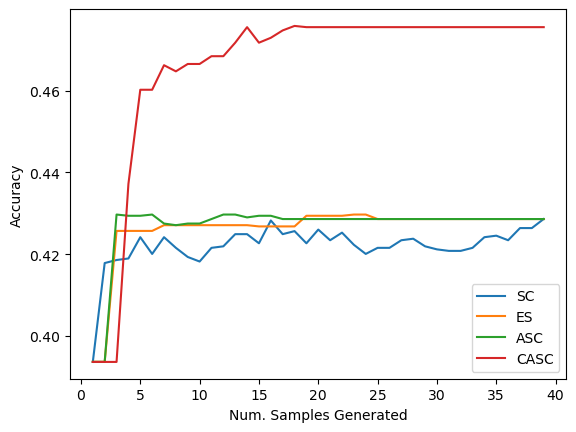

In [46]:
llm = 'all'
benchmark = 'all'
print(llm,benchmark)
sc_step_results = []
df_step = get_data(df_with_features,benchmark=benchmark,llm = llm)
for row_idx in range(len(df_step)):
    sample_results = []
    for i in range(40):
        if Counter(df_step['CoT answers'].iloc[row_idx][:i+1]).most_common(1)[0][0] == df_step['correct answer'].iloc[row_idx]:
            sample_results.append(1)
        else:
            sample_results.append(0)
    sc_step_results.append(sample_results)
sc_step_results = np.array(sc_step_results)
sc_step_results = sc_step_results.sum(axis=0)/sc_step_results.shape[0]
df_N_study_gpt4 = df_N_study[(df_N_study.llm == llm)]
df_N_study_gpt4_all = df_N_study_gpt4[df_N_study_gpt4.benchmark == benchmark]
casc_steps = df_N_study_gpt4_all['CASC_Avg_Cost'].to_numpy().astype(np.int32)
casc_acc = df_N_study_gpt4_all['CASC_ACC'].to_numpy()
casc_step_results = np.zeros(40)
for i, idx in enumerate(casc_steps):
    casc_step_results[idx] = casc_acc[i]
casc_step_results = replace_zeros_with_previous_nonzero(sc_step_results[0],casc_step_results)

es_steps = []
es_acc = []
for i in range(16):
    df_es_step = calculate_ES_correctness(df_step,i+1)
    es_acc.append(round(df_es_step.ES_correctness.sum() / len(df_es_step),4))
    es_steps.append(df_es_step.ES_steps.mean().astype(np.int32))
es_step_results = np.zeros(40)
for i, idx in enumerate(es_steps):
    es_step_results[idx] = es_acc[i]
es_step_results = replace_zeros_with_previous_nonzero(sc_step_results[0],es_step_results)

asc_steps = []
asc_acc = []
for i in range(75,101):
    df_asc_step = calculate_ASC_correctness(df_step,i*0.01)
    asc_acc.append(round(df_asc_step.asc_correctness.sum() / len(df_asc_step),4))
    asc_steps.append(df_asc_step.asc_steps.mean().astype(np.int32))
asc_step_results = np.zeros(40)
for i, idx in enumerate(asc_steps):
    asc_step_results[idx-1] = asc_acc[i]
asc_step_results = replace_zeros_with_previous_nonzero(sc_step_results[0],asc_step_results)

step_study_plot_dict = {
    'Steps': np.arange(40)[1:],
    'SC': sc_step_results[1:],
    'ES': es_step_results[1:],
    'ASC': asc_step_results[1:],
    'CASC':casc_step_results[1:]
}



plt.figure()
sns.lineplot(data=step_study_plot_dict, x='Steps', y='SC', label='SC', linestyle='-')
sns.lineplot(data=step_study_plot_dict, x='Steps', y='ES', label='ES', linestyle='-')
sns.lineplot(data=step_study_plot_dict, x='Steps', y='ASC', label='ASC', linestyle='-')
sns.lineplot(data=step_study_plot_dict, x='Steps', y='CASC', label='CASC', linestyle='-')

# Set the x and y axis labels
plt.xlabel('Num. Samples Generated')
plt.ylabel('Accuracy')

# Find the intersection point
x_intercept = None
for i in range(len(step_study_plot_dict['Steps']) - 1):
    if step_study_plot_dict['CASC'][i] < sc_step_results.max() <= step_study_plot_dict['CASC'][i+1]:
        x_intercept = step_study_plot_dict['Steps'][i]+1
        break

# Add the horizontal line (red line)
# plt.hlines(y=0.45, xmin=x_intercept, xmax=40, color='red', linestyle='--', linewidth=1)

# Add the vertical line at the intersection point
# if x_intercept is not None:
#     plt.vlines(x=x_intercept, ymin=sc_step_results.min(), ymax=0.45, color='red', linestyle='--', linewidth=1)
#     plt.annotate(f'({x_intercept}, {0.45})', xy=(x_intercept, 0.45), 
#                  xytext=(x_intercept - 5.7, 0.45),
#                  fontsize=9, color='black')

# Display the plot
plt.legend()
# plt.savefig('../src/experiment_collection/main_step_acc_plot.jpg', dpi=300, bbox_inches='tight')
plt.plot()

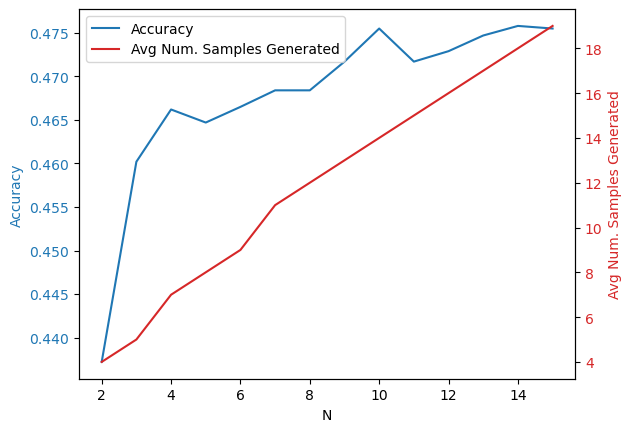

In [49]:
casc_N = df_N_study_gpt4_all['N'].to_numpy()
fig, ax1 = plt.subplots()

# Plot the first line (ACC) with ax1
color = 'tab:blue'
ax1.set_xlabel('N')
ax1.set_ylabel('Accuracy', color=color)
line1, = ax1.plot(casc_N, casc_acc, color=color, label='Accuracy')
ax1.tick_params(axis='y', labelcolor=color)
# plt.hlines(y=casc_acc[2], xmin=0, xmax=3, color='red', linestyle='--', linewidth=1)
# plt.annotate(f'({3}, {casc_acc[2]})', xy=(3, casc_acc[2]), 
#                  xytext=(3 - 2, casc_acc[2]+0.001),
#                  fontsize=9, color='black')
# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Avg Num. Samples Generated', color=color)
line2, = ax2.plot(casc_N, casc_steps, color=color, label='Avg Num. Samples Generated')
ax2.tick_params(axis='y', labelcolor=color)
# plt.vlines(x=3, ymin=0, ymax=22, color='red', linestyle='--', linewidth=1)
# plt.hlines(y=casc_steps[2], xmin=3, xmax=14, color='red', linestyle='--', linewidth=1)
# plt.annotate(f'({3}, {casc_steps[2]})', xy=(3, casc_steps[2]), 
#                  xytext=(3 +0.5, casc_steps[2]-1),
#                  fontsize=9, color='black')
# Combine legends
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left')
# fig.savefig('../src/experiment_collection/N_study_plot.jpg', dpi=300, bbox_inches='tight')
# Show the plot
plt.show()

# Threshold Study

In [50]:
result_buffer = {
        'llm': [],
        'benchmark':[],
        'N': [],
        'stop_algo':[],
        'threshold': [],
        'SC_ACC': [],
        'ES_ACC': [],
        'ASC_ACC': [],
        'CASC_ACC': [],
        'SC_Avg_Cost': [],
        'ES_Avg_Cost': [],
        'ASC_Avg_Cost': [],
        'CASC_Avg_Cost': [],
    }
for threshold in config['threshold']:
    for benchmark in config['benchmark']:
        for llm in config['llm']:
            df_in = get_data(df_with_features,benchmark=benchmark,llm=llm)
            print(llm,benchmark)
            print('df_size is ',len(df_in))
            df_cs = customized_LR_model(df_in,feature_li,coe,intercept)
            N= 3
            stop_mechanism = 'PositiveN'
            df_results = CS_early_stopping(df=df_cs, threshold=threshold, N=N, stop_mechanism=stop_mechanism)
            df_model_comp_dict = {
                    'llm': llm,
                    'benchmark':benchmark,
                    'N': N,
                    'stop_algo':stop_mechanism,
                    'threshold': threshold,
                    'SC_ACC': round(df_results.SC_correctness.sum() / len(df_results),4),
                    'ES_ACC': round(df_results.ES_correctness.sum() / len(df_results),4),
                    'ASC_ACC': round(df_results.asc_correctness.sum() / len(df_results),4),
                    'CASC_ACC': round(df_results.CS_correctness.sum() / len(df_results),4),
                    'SC_Avg_Cost': 40,
                    'ES_Avg_Cost': round(df_results.ES_steps.mean(),2),
                    'ASC_Avg_Cost': round(df_results.asc_steps.mean(),2),
                    'CASC_Avg_Cost': round(df_results.CS_steps.mean(),2),
                }
            for key,val in df_model_comp_dict.items():
                result_buffer[key].append(val)

all all
df_size is  2690
SC_ACC : 0.42862453531598516
ES_ACC : 0.42862453531598516
CS_ACC : 0.4342007434944238
SC_Avg_Steps : 40
ES_Avg_Steps : 32.73197026022305
CS_Avg_Steps : 3.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.42862453531598516
gpt-3.5 all
df_size is  890


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.5067415730337078
ES_ACC : 0.5067415730337078
CS_ACC : 0.5112359550561798
SC_Avg_Steps : 40
ES_Avg_Steps : 32.64831460674157
CS_Avg_Steps : 3.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.5067415730337078
claude-3 all
df_size is  900


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.5511111111111111
ES_ACC : 0.5511111111111111
CS_ACC : 0.5366666666666666
SC_Avg_Steps : 40
ES_Avg_Steps : 31.164444444444445
CS_Avg_Steps : 3.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.5511111111111111
llama3 all
df_size is  900


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.2288888888888889
ES_ACC : 0.2288888888888889
CS_ACC : 0.25555555555555554
SC_Avg_Steps : 40
ES_Avg_Steps : 34.382222222222225
CS_Avg_Steps : 3.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.2288888888888889
all GSM8K_hard
df_size is  450


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.3711111111111111
ES_ACC : 0.3711111111111111
CS_ACC : 0.3711111111111111
SC_Avg_Steps : 40
ES_Avg_Steps : 35.80888888888889
CS_Avg_Steps : 3.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.3711111111111111
gpt-3.5 GSM8K_hard
df_size is  150
SC_ACC : 0.42
ES_ACC : 0.42
CS_ACC : 0.42
SC_Avg_Steps : 40
ES_Avg_Steps : 35.42
CS_Avg_Steps : 3.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.42
claude-3 GSM8K_hard
df_size is  150
SC_ACC : 0.44
ES_ACC : 0.44
CS_ACC : 0.44666666666666666
SC_Avg_Steps : 40
ES_Avg_Steps : 33.92
CS_Avg_Steps : 3.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.44
llama3 GSM8K_hard
df_size is  150
SC_ACC : 0.25333333333333335
ES_ACC : 0.25333333333333335
CS_ACC : 0.24666666666666667
SC_Avg_Steps : 40
ES_Avg_Steps : 38.086666666666666
CS_Avg_Steps : 3.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.25333333333333335
all GSM8K_test
df_size is  450


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.8066666666666666
ES_ACC : 0.8066666666666666
CS_ACC : 0.7377777777777778
SC_Avg_Steps : 40
ES_Avg_Steps : 29.41111111111111
CS_Avg_Steps : 3.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.8066666666666666
gpt-3.5 GSM8K_test
df_size is  150
SC_ACC : 0.8333333333333334
ES_ACC : 0.8333333333333334
CS_ACC : 0.7533333333333333
SC_Avg_Steps : 40
ES_Avg_Steps : 28.80666666666667
CS_Avg_Steps : 3.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.8333333333333334
claude-3 GSM8K_test
df_size is  150
SC_ACC : 0.84
ES_ACC : 0.84
CS_ACC : 0.7933333333333333
SC_Avg_Steps : 40
ES_Avg_Steps : 27.893333333333334
CS_Avg_Steps : 3.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.84
llama3 GSM8K_test
df_size is  150
SC_ACC : 0.7466666666666667
ES_ACC : 0.7466666666666667
CS_ACC : 0.6666666666666666
SC_Avg_Steps : 40
ES_Avg_Steps : 31.533333333333335
CS_Avg_Steps : 3.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.7466666666666667
all MathQA_challenge_test
df_size is  448


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.3861607142857143
ES_ACC : 0.3861607142857143
CS_ACC : 0.38169642857142855
SC_Avg_Steps : 40
ES_Avg_Steps : 32.78794642857143
CS_Avg_Steps : 3.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.3861607142857143
gpt-3.5 MathQA_challenge_test
df_size is  148
SC_ACC : 0.527027027027027
ES_ACC : 0.527027027027027
CS_ACC : 0.527027027027027
SC_Avg_Steps : 40
ES_Avg_Steps : 33.689189189189186
CS_Avg_Steps : 3.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.527027027027027
claude-3 MathQA_challenge_test
df_size is  150
SC_ACC : 0.56
ES_ACC : 0.56
CS_ACC : 0.52
SC_Avg_Steps : 40
ES_Avg_Steps : 32.20666666666666
CS_Avg_Steps : 3.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.56
llama3 MathQA_challenge_test
df_size is  150
SC_ACC : 0.07333333333333333
ES_ACC : 0.07333333333333333
CS_ACC : 0.1
SC_Avg_Steps : 40
ES_Avg_Steps : 32.48
CS_Avg_Steps : 3.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.07333333333333333
all MathQA_dev
df_size is  447


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.3959731543624161
ES_ACC : 0.3959731543624161
CS_ACC : 0.41834451901565994
SC_Avg_Steps : 40
ES_Avg_Steps : 32.28635346756152
CS_Avg_Steps : 3.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.3959731543624161
gpt-3.5 MathQA_dev
df_size is  147
SC_ACC : 0.4421768707482993
ES_ACC : 0.4421768707482993
CS_ACC : 0.48299319727891155
SC_Avg_Steps : 40
ES_Avg_Steps : 32.965986394557824
CS_Avg_Steps : 3.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.4421768707482993
claude-3 MathQA_dev
df_size is  150
SC_ACC : 0.58
ES_ACC : 0.58
CS_ACC : 0.6
SC_Avg_Steps : 40
ES_Avg_Steps : 31.653333333333332
CS_Avg_Steps : 3.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.58
llama3 MathQA_dev
df_size is  150
SC_ACC : 0.16666666666666666
ES_ACC : 0.16666666666666666
CS_ACC : 0.17333333333333334
SC_Avg_Steps : 40
ES_Avg_Steps : 32.25333333333333
CS_Avg_Steps : 3.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.16666666666666666
all BigBench_hard
df_size is  450


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.4311111111111111
ES_ACC : 0.4311111111111111
CS_ACC : 0.48
SC_Avg_Steps : 40
ES_Avg_Steps : 33.07333333333333
CS_Avg_Steps : 3.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.4311111111111111
gpt-3.5 BigBench_hard
df_size is  150
SC_ACC : 0.5533333333333333
ES_ACC : 0.5533333333333333
CS_ACC : 0.62
SC_Avg_Steps : 40
ES_Avg_Steps : 31.69333333333333
CS_Avg_Steps : 3.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.5533333333333333
claude-3 BigBench_hard
df_size is  150
SC_ACC : 0.6733333333333333
ES_ACC : 0.6733333333333333
CS_ACC : 0.64
SC_Avg_Steps : 40
ES_Avg_Steps : 31.36
CS_Avg_Steps : 3.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.6733333333333333
llama3 BigBench_hard
df_size is  150
SC_ACC : 0.06666666666666667
ES_ACC : 0.06666666666666667
CS_ACC : 0.18
SC_Avg_Steps : 40
ES_Avg_Steps : 36.166666666666664
CS_Avg_Steps : 3.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.06666666666666667
all BigBench_easy
df_size is  445


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.17752808988764046
ES_ACC : 0.17752808988764046
CS_ACC : 0.21348314606741572
SC_Avg_Steps : 40
ES_Avg_Steps : 33.024719101123594
CS_Avg_Steps : 3.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.17752808988764046
gpt-3.5 BigBench_easy
df_size is  145
SC_ACC : 0.25517241379310346
ES_ACC : 0.25517241379310346
CS_ACC : 0.25517241379310346
SC_Avg_Steps : 40
ES_Avg_Steps : 33.358620689655176
CS_Avg_Steps : 3.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.25517241379310346
claude-3 BigBench_easy
df_size is  150
SC_ACC : 0.21333333333333335
ES_ACC : 0.21333333333333335
CS_ACC : 0.22
SC_Avg_Steps : 40
ES_Avg_Steps : 29.953333333333333
CS_Avg_Steps : 3.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.21333333333333335
llama3 BigBench_easy
df_size is  150
SC_ACC : 0.06666666666666667
ES_ACC : 0.06666666666666667
CS_ACC : 0.16666666666666666
SC_Avg_Steps : 40
ES_Avg_Steps : 35.77333333333333
CS_Avg_Steps : 3.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.06666666666666667
all all
df_size is  2690
SC_ACC : 0.42862453531598516
ES_ACC : 0.4

/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.5067415730337078
ES_ACC : 0.5067415730337078
CS_ACC : 0.5393258426966292
SC_Avg_Steps : 40
ES_Avg_Steps : 32.64831460674157
CS_Avg_Steps : 5.615730337078651
ASC_Avg_Steps : 40.0
ASC_ACC : 0.5067415730337078
claude-3 all
df_size is  900


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.5511111111111111
ES_ACC : 0.5511111111111111
CS_ACC : 0.5377777777777778
SC_Avg_Steps : 40
ES_Avg_Steps : 31.164444444444445
CS_Avg_Steps : 4.573333333333333
ASC_Avg_Steps : 40.0
ASC_ACC : 0.5511111111111111
llama3 all
df_size is  900


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.2288888888888889
ES_ACC : 0.2288888888888889
CS_ACC : 0.30444444444444446
SC_Avg_Steps : 40
ES_Avg_Steps : 34.382222222222225
CS_Avg_Steps : 7.426666666666667
ASC_Avg_Steps : 40.0
ASC_ACC : 0.2288888888888889
all GSM8K_hard
df_size is  450


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.3711111111111111
ES_ACC : 0.3711111111111111
CS_ACC : 0.37555555555555553
SC_Avg_Steps : 40
ES_Avg_Steps : 35.80888888888889
CS_Avg_Steps : 3.577777777777778
ASC_Avg_Steps : 40.0
ASC_ACC : 0.3711111111111111
gpt-3.5 GSM8K_hard
df_size is  150
SC_ACC : 0.42
ES_ACC : 0.42
CS_ACC : 0.43333333333333335
SC_Avg_Steps : 40
ES_Avg_Steps : 35.42
CS_Avg_Steps : 4.28
ASC_Avg_Steps : 40.0
ASC_ACC : 0.42
claude-3 GSM8K_hard
df_size is  150
SC_ACC : 0.44
ES_ACC : 0.44
CS_ACC : 0.44666666666666666
SC_Avg_Steps : 40
ES_Avg_Steps : 33.92
CS_Avg_Steps : 3.2933333333333334
ASC_Avg_Steps : 40.0
ASC_ACC : 0.44
llama3 GSM8K_hard
df_size is  150
SC_ACC : 0.25333333333333335
ES_ACC : 0.25333333333333335
CS_ACC : 0.24666666666666667
SC_Avg_Steps : 40
ES_Avg_Steps : 38.086666666666666
CS_Avg_Steps : 3.16
ASC_Avg_Steps : 40.0
ASC_ACC : 0.25333333333333335
all GSM8K_test
df_size is  450


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.8066666666666666
ES_ACC : 0.8066666666666666
CS_ACC : 0.7422222222222222
SC_Avg_Steps : 40
ES_Avg_Steps : 29.41111111111111
CS_Avg_Steps : 3.1577777777777776
ASC_Avg_Steps : 40.0
ASC_ACC : 0.8066666666666666
gpt-3.5 GSM8K_test
df_size is  150
SC_ACC : 0.8333333333333334
ES_ACC : 0.8333333333333334
CS_ACC : 0.76
SC_Avg_Steps : 40
ES_Avg_Steps : 28.80666666666667
CS_Avg_Steps : 3.1866666666666665
ASC_Avg_Steps : 40.0
ASC_ACC : 0.8333333333333334
claude-3 GSM8K_test
df_size is  150
SC_ACC : 0.84
ES_ACC : 0.84
CS_ACC : 0.8
SC_Avg_Steps : 40
ES_Avg_Steps : 27.893333333333334
CS_Avg_Steps : 3.28
ASC_Avg_Steps : 40.0
ASC_ACC : 0.84
llama3 GSM8K_test
df_size is  150
SC_ACC : 0.7466666666666667
ES_ACC : 0.7466666666666667
CS_ACC : 0.6666666666666666
SC_Avg_Steps : 40
ES_Avg_Steps : 31.533333333333335
CS_Avg_Steps : 3.006666666666667
ASC_Avg_Steps : 40.0
ASC_ACC : 0.7466666666666667
all MathQA_challenge_test
df_size is  448


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.3861607142857143
ES_ACC : 0.3861607142857143
CS_ACC : 0.40625
SC_Avg_Steps : 40
ES_Avg_Steps : 32.78794642857143
CS_Avg_Steps : 8.147321428571429
ASC_Avg_Steps : 40.0
ASC_ACC : 0.3861607142857143
gpt-3.5 MathQA_challenge_test
df_size is  148
SC_ACC : 0.527027027027027
ES_ACC : 0.527027027027027
CS_ACC : 0.5878378378378378
SC_Avg_Steps : 40
ES_Avg_Steps : 33.689189189189186
CS_Avg_Steps : 7.635135135135135
ASC_Avg_Steps : 40.0
ASC_ACC : 0.527027027027027
claude-3 MathQA_challenge_test
df_size is  150
SC_ACC : 0.56
ES_ACC : 0.56
CS_ACC : 0.52
SC_Avg_Steps : 40
ES_Avg_Steps : 32.20666666666666
CS_Avg_Steps : 8.106666666666667
ASC_Avg_Steps : 40.0
ASC_ACC : 0.56
llama3 MathQA_challenge_test
df_size is  150
SC_ACC : 0.07333333333333333
ES_ACC : 0.07333333333333333
CS_ACC : 0.11333333333333333
SC_Avg_Steps : 40
ES_Avg_Steps : 32.48
CS_Avg_Steps : 8.693333333333333
ASC_Avg_Steps : 40.0
ASC_ACC : 0.07333333333333333
all MathQA_dev
df_size is  447


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.3959731543624161
ES_ACC : 0.3959731543624161
CS_ACC : 0.4250559284116331
SC_Avg_Steps : 40
ES_Avg_Steps : 32.28635346756152
CS_Avg_Steps : 7.073825503355705
ASC_Avg_Steps : 40.0
ASC_ACC : 0.3959731543624161
gpt-3.5 MathQA_dev
df_size is  147
SC_ACC : 0.4421768707482993
ES_ACC : 0.4421768707482993
CS_ACC : 0.5034013605442177
SC_Avg_Steps : 40
ES_Avg_Steps : 32.965986394557824
CS_Avg_Steps : 8.421768707482993
ASC_Avg_Steps : 40.0
ASC_ACC : 0.4421768707482993
claude-3 MathQA_dev
df_size is  150
SC_ACC : 0.58
ES_ACC : 0.58
CS_ACC : 0.5933333333333334
SC_Avg_Steps : 40
ES_Avg_Steps : 31.653333333333332
CS_Avg_Steps : 6.74
ASC_Avg_Steps : 40.0
ASC_ACC : 0.58
llama3 MathQA_dev
df_size is  150
SC_ACC : 0.16666666666666666
ES_ACC : 0.16666666666666666
CS_ACC : 0.18
SC_Avg_Steps : 40
ES_Avg_Steps : 32.25333333333333
CS_Avg_Steps : 6.086666666666667
ASC_Avg_Steps : 40.0
ASC_ACC : 0.16666666666666666
all BigBench_hard
df_size is  450


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.4311111111111111
ES_ACC : 0.4311111111111111
CS_ACC : 0.5466666666666666
SC_Avg_Steps : 40
ES_Avg_Steps : 33.07333333333333
CS_Avg_Steps : 6.904444444444445
ASC_Avg_Steps : 40.0
ASC_ACC : 0.4311111111111111
gpt-3.5 BigBench_hard
df_size is  150
SC_ACC : 0.5533333333333333
ES_ACC : 0.5533333333333333
CS_ACC : 0.6666666666666666
SC_Avg_Steps : 40
ES_Avg_Steps : 31.69333333333333
CS_Avg_Steps : 5.1
ASC_Avg_Steps : 40.0
ASC_ACC : 0.5533333333333333
claude-3 BigBench_hard
df_size is  150
SC_ACC : 0.6733333333333333
ES_ACC : 0.6733333333333333
CS_ACC : 0.6466666666666666
SC_Avg_Steps : 40
ES_Avg_Steps : 31.36
CS_Avg_Steps : 3.02
ASC_Avg_Steps : 40.0
ASC_ACC : 0.6733333333333333
llama3 BigBench_hard
df_size is  150
SC_ACC : 0.06666666666666667
ES_ACC : 0.06666666666666667
CS_ACC : 0.32666666666666666
SC_Avg_Steps : 40
ES_Avg_Steps : 36.166666666666664
CS_Avg_Steps : 12.593333333333334
ASC_Avg_Steps : 40.0
ASC_ACC : 0.06666666666666667
all BigBench_easy
df_size is  445


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.17752808988764046
ES_ACC : 0.17752808988764046
CS_ACC : 0.26292134831460673
SC_Avg_Steps : 40
ES_Avg_Steps : 33.024719101123594
CS_Avg_Steps : 6.4
ASC_Avg_Steps : 40.0
ASC_ACC : 0.17752808988764046
gpt-3.5 BigBench_easy
df_size is  145
SC_ACC : 0.25517241379310346
ES_ACC : 0.25517241379310346
CS_ACC : 0.27586206896551724
SC_Avg_Steps : 40
ES_Avg_Steps : 33.358620689655176
CS_Avg_Steps : 5.137931034482759
ASC_Avg_Steps : 40.0
ASC_ACC : 0.25517241379310346
claude-3 BigBench_easy
df_size is  150
SC_ACC : 0.21333333333333335
ES_ACC : 0.21333333333333335
CS_ACC : 0.22
SC_Avg_Steps : 40
ES_Avg_Steps : 29.953333333333333
CS_Avg_Steps : 3.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.21333333333333335
llama3 BigBench_easy
df_size is  150
SC_ACC : 0.06666666666666667
ES_ACC : 0.06666666666666667
CS_ACC : 0.29333333333333333
SC_Avg_Steps : 40
ES_Avg_Steps : 35.77333333333333
CS_Avg_Steps : 11.02
ASC_Avg_Steps : 40.0
ASC_ACC : 0.06666666666666667
all all
df_size is  2690
SC_ACC : 0.42862453531598

/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.5067415730337078
ES_ACC : 0.5067415730337078
CS_ACC : 0.5337078651685393
SC_Avg_Steps : 40
ES_Avg_Steps : 32.64831460674157
CS_Avg_Steps : 6.015730337078652
ASC_Avg_Steps : 40.0
ASC_ACC : 0.5067415730337078
claude-3 all
df_size is  900


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.5511111111111111
ES_ACC : 0.5511111111111111
CS_ACC : 0.5366666666666666
SC_Avg_Steps : 40
ES_Avg_Steps : 31.164444444444445
CS_Avg_Steps : 4.7011111111111115
ASC_Avg_Steps : 40.0
ASC_ACC : 0.5511111111111111
llama3 all
df_size is  900


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.2288888888888889
ES_ACC : 0.2288888888888889
CS_ACC : 0.2966666666666667
SC_Avg_Steps : 40
ES_Avg_Steps : 34.382222222222225
CS_Avg_Steps : 12.278888888888888
ASC_Avg_Steps : 40.0
ASC_ACC : 0.2288888888888889
all GSM8K_hard
df_size is  450


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.3711111111111111
ES_ACC : 0.3711111111111111
CS_ACC : 0.37333333333333335
SC_Avg_Steps : 40
ES_Avg_Steps : 35.80888888888889
CS_Avg_Steps : 4.5
ASC_Avg_Steps : 40.0
ASC_ACC : 0.3711111111111111
gpt-3.5 GSM8K_hard
df_size is  150
SC_ACC : 0.42
ES_ACC : 0.42
CS_ACC : 0.43333333333333335
SC_Avg_Steps : 40
ES_Avg_Steps : 35.42
CS_Avg_Steps : 4.6866666666666665
ASC_Avg_Steps : 40.0
ASC_ACC : 0.42
claude-3 GSM8K_hard
df_size is  150
SC_ACC : 0.44
ES_ACC : 0.44
CS_ACC : 0.44666666666666666
SC_Avg_Steps : 40
ES_Avg_Steps : 33.92
CS_Avg_Steps : 3.3733333333333335
ASC_Avg_Steps : 40.0
ASC_ACC : 0.44
llama3 GSM8K_hard
df_size is  150
SC_ACC : 0.25333333333333335
ES_ACC : 0.25333333333333335
CS_ACC : 0.24
SC_Avg_Steps : 40
ES_Avg_Steps : 38.086666666666666
CS_Avg_Steps : 5.44
ASC_Avg_Steps : 40.0
ASC_ACC : 0.25333333333333335
all GSM8K_test
df_size is  450


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.8066666666666666
ES_ACC : 0.8066666666666666
CS_ACC : 0.7488888888888889
SC_Avg_Steps : 40
ES_Avg_Steps : 29.41111111111111
CS_Avg_Steps : 3.2044444444444444
ASC_Avg_Steps : 40.0
ASC_ACC : 0.8066666666666666
gpt-3.5 GSM8K_test
df_size is  150
SC_ACC : 0.8333333333333334
ES_ACC : 0.8333333333333334
CS_ACC : 0.7666666666666667
SC_Avg_Steps : 40
ES_Avg_Steps : 28.80666666666667
CS_Avg_Steps : 3.22
ASC_Avg_Steps : 40.0
ASC_ACC : 0.8333333333333334
claude-3 GSM8K_test
df_size is  150
SC_ACC : 0.84
ES_ACC : 0.84
CS_ACC : 0.8
SC_Avg_Steps : 40
ES_Avg_Steps : 27.893333333333334
CS_Avg_Steps : 3.3733333333333335
ASC_Avg_Steps : 40.0
ASC_ACC : 0.84
llama3 GSM8K_test
df_size is  150
SC_ACC : 0.7466666666666667
ES_ACC : 0.7466666666666667
CS_ACC : 0.68
SC_Avg_Steps : 40
ES_Avg_Steps : 31.533333333333335
CS_Avg_Steps : 3.02
ASC_Avg_Steps : 40.0
ASC_ACC : 0.7466666666666667
all MathQA_challenge_test
df_size is  448


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.3861607142857143
ES_ACC : 0.3861607142857143
CS_ACC : 0.39955357142857145
SC_Avg_Steps : 40
ES_Avg_Steps : 32.78794642857143
CS_Avg_Steps : 8.564732142857142
ASC_Avg_Steps : 40.0
ASC_ACC : 0.3861607142857143
gpt-3.5 MathQA_challenge_test
df_size is  148
SC_ACC : 0.527027027027027
ES_ACC : 0.527027027027027
CS_ACC : 0.5675675675675675
SC_Avg_Steps : 40
ES_Avg_Steps : 33.689189189189186
CS_Avg_Steps : 7.912162162162162
ASC_Avg_Steps : 40.0
ASC_ACC : 0.527027027027027
claude-3 MathQA_challenge_test
df_size is  150
SC_ACC : 0.56
ES_ACC : 0.56
CS_ACC : 0.5266666666666666
SC_Avg_Steps : 40
ES_Avg_Steps : 32.20666666666666
CS_Avg_Steps : 8.206666666666667
ASC_Avg_Steps : 40.0
ASC_ACC : 0.56
llama3 MathQA_challenge_test
df_size is  150
SC_ACC : 0.07333333333333333
ES_ACC : 0.07333333333333333
CS_ACC : 0.10666666666666667
SC_Avg_Steps : 40
ES_Avg_Steps : 32.48
CS_Avg_Steps : 9.566666666666666
ASC_Avg_Steps : 40.0
ASC_ACC : 0.07333333333333333
all MathQA_dev
df_size is  447


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.3959731543624161
ES_ACC : 0.3959731543624161
CS_ACC : 0.41387024608501116
SC_Avg_Steps : 40
ES_Avg_Steps : 32.28635346756152
CS_Avg_Steps : 7.501118568232662
ASC_Avg_Steps : 40.0
ASC_ACC : 0.3959731543624161
gpt-3.5 MathQA_dev
df_size is  147
SC_ACC : 0.4421768707482993
ES_ACC : 0.4421768707482993
CS_ACC : 0.4965986394557823
SC_Avg_Steps : 40
ES_Avg_Steps : 32.965986394557824
CS_Avg_Steps : 8.639455782312925
ASC_Avg_Steps : 40.0
ASC_ACC : 0.4421768707482993
claude-3 MathQA_dev
df_size is  150
SC_ACC : 0.58
ES_ACC : 0.58
CS_ACC : 0.58
SC_Avg_Steps : 40
ES_Avg_Steps : 31.653333333333332
CS_Avg_Steps : 7.006666666666667
ASC_Avg_Steps : 40.0
ASC_ACC : 0.58
llama3 MathQA_dev
df_size is  150
SC_ACC : 0.16666666666666666
ES_ACC : 0.16666666666666666
CS_ACC : 0.16666666666666666
SC_Avg_Steps : 40
ES_Avg_Steps : 32.25333333333333
CS_Avg_Steps : 6.88
ASC_Avg_Steps : 40.0
ASC_ACC : 0.16666666666666666
all BigBench_hard
df_size is  450


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.4311111111111111
ES_ACC : 0.4311111111111111
CS_ACC : 0.5488888888888889
SC_Avg_Steps : 40
ES_Avg_Steps : 33.07333333333333
CS_Avg_Steps : 11.184444444444445
ASC_Avg_Steps : 40.0
ASC_ACC : 0.4311111111111111
gpt-3.5 BigBench_hard
df_size is  150
SC_ACC : 0.5533333333333333
ES_ACC : 0.5533333333333333
CS_ACC : 0.66
SC_Avg_Steps : 40
ES_Avg_Steps : 31.69333333333333
CS_Avg_Steps : 6.32
ASC_Avg_Steps : 40.0
ASC_ACC : 0.5533333333333333
claude-3 BigBench_hard
df_size is  150
SC_ACC : 0.6733333333333333
ES_ACC : 0.6733333333333333
CS_ACC : 0.6466666666666666
SC_Avg_Steps : 40
ES_Avg_Steps : 31.36
CS_Avg_Steps : 3.1466666666666665
ASC_Avg_Steps : 40.0
ASC_ACC : 0.6733333333333333
llama3 BigBench_hard
df_size is  150
SC_ACC : 0.06666666666666667
ES_ACC : 0.06666666666666667
CS_ACC : 0.34
SC_Avg_Steps : 40
ES_Avg_Steps : 36.166666666666664
CS_Avg_Steps : 24.086666666666666
ASC_Avg_Steps : 40.0
ASC_ACC : 0.06666666666666667
all BigBench_easy
df_size is  445


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.17752808988764046
ES_ACC : 0.17752808988764046
CS_ACC : 0.2449438202247191
SC_Avg_Steps : 40
ES_Avg_Steps : 33.024719101123594
CS_Avg_Steps : 11.114606741573034
ASC_Avg_Steps : 40.0
ASC_ACC : 0.17752808988764046
gpt-3.5 BigBench_easy
df_size is  145
SC_ACC : 0.25517241379310346
ES_ACC : 0.25517241379310346
CS_ACC : 0.2689655172413793
SC_Avg_Steps : 40
ES_Avg_Steps : 33.358620689655176
CS_Avg_Steps : 5.372413793103449
ASC_Avg_Steps : 40.0
ASC_ACC : 0.25517241379310346
claude-3 BigBench_easy
df_size is  150
SC_ACC : 0.21333333333333335
ES_ACC : 0.21333333333333335
CS_ACC : 0.22
SC_Avg_Steps : 40
ES_Avg_Steps : 29.953333333333333
CS_Avg_Steps : 3.1
ASC_Avg_Steps : 40.0
ASC_ACC : 0.21333333333333335
llama3 BigBench_easy
df_size is  150
SC_ACC : 0.06666666666666667
ES_ACC : 0.06666666666666667
CS_ACC : 0.24666666666666667
SC_Avg_Steps : 40
ES_Avg_Steps : 35.77333333333333
CS_Avg_Steps : 24.68
ASC_Avg_Steps : 40.0
ASC_ACC : 0.06666666666666667
all all
df_size is  2690
SC_ACC : 0.4

/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.5067415730337078
ES_ACC : 0.5067415730337078
CS_ACC : 0.5258426966292135
SC_Avg_Steps : 40
ES_Avg_Steps : 32.64831460674157
CS_Avg_Steps : 9.551685393258428
ASC_Avg_Steps : 40.0
ASC_ACC : 0.5067415730337078
claude-3 all
df_size is  900


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.5511111111111111
ES_ACC : 0.5511111111111111
CS_ACC : 0.5477777777777778
SC_Avg_Steps : 40
ES_Avg_Steps : 31.164444444444445
CS_Avg_Steps : 6.007777777777778
ASC_Avg_Steps : 40.0
ASC_ACC : 0.5511111111111111
llama3 all
df_size is  900


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.2288888888888889
ES_ACC : 0.2288888888888889
CS_ACC : 0.30444444444444446
SC_Avg_Steps : 40
ES_Avg_Steps : 34.382222222222225
CS_Avg_Steps : 18.72
ASC_Avg_Steps : 40.0
ASC_ACC : 0.2288888888888889
all GSM8K_hard
df_size is  450


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.3711111111111111
ES_ACC : 0.3711111111111111
CS_ACC : 0.37555555555555553
SC_Avg_Steps : 40
ES_Avg_Steps : 35.80888888888889
CS_Avg_Steps : 10.657777777777778
ASC_Avg_Steps : 40.0
ASC_ACC : 0.3711111111111111
gpt-3.5 GSM8K_hard
df_size is  150
SC_ACC : 0.42
ES_ACC : 0.42
CS_ACC : 0.43333333333333335
SC_Avg_Steps : 40
ES_Avg_Steps : 35.42
CS_Avg_Steps : 7.466666666666667
ASC_Avg_Steps : 40.0
ASC_ACC : 0.42
claude-3 GSM8K_hard
df_size is  150
SC_ACC : 0.44
ES_ACC : 0.44
CS_ACC : 0.44
SC_Avg_Steps : 40
ES_Avg_Steps : 33.92
CS_Avg_Steps : 4.68
ASC_Avg_Steps : 40.0
ASC_ACC : 0.44
llama3 GSM8K_hard
df_size is  150
SC_ACC : 0.25333333333333335
ES_ACC : 0.25333333333333335
CS_ACC : 0.25333333333333335
SC_Avg_Steps : 40
ES_Avg_Steps : 38.086666666666666
CS_Avg_Steps : 19.826666666666668
ASC_Avg_Steps : 40.0
ASC_ACC : 0.25333333333333335
all GSM8K_test
df_size is  450


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.8066666666666666
ES_ACC : 0.8066666666666666
CS_ACC : 0.7577777777777778
SC_Avg_Steps : 40
ES_Avg_Steps : 29.41111111111111
CS_Avg_Steps : 5.237777777777778
ASC_Avg_Steps : 40.0
ASC_ACC : 0.8066666666666666
gpt-3.5 GSM8K_test
df_size is  150
SC_ACC : 0.8333333333333334
ES_ACC : 0.8333333333333334
CS_ACC : 0.76
SC_Avg_Steps : 40
ES_Avg_Steps : 28.80666666666667
CS_Avg_Steps : 4.733333333333333
ASC_Avg_Steps : 40.0
ASC_ACC : 0.8333333333333334
claude-3 GSM8K_test
df_size is  150
SC_ACC : 0.84
ES_ACC : 0.84
CS_ACC : 0.8266666666666667
SC_Avg_Steps : 40
ES_Avg_Steps : 27.893333333333334
CS_Avg_Steps : 4.066666666666666
ASC_Avg_Steps : 40.0
ASC_ACC : 0.84
llama3 GSM8K_test
df_size is  150
SC_ACC : 0.7466666666666667
ES_ACC : 0.7466666666666667
CS_ACC : 0.6866666666666666
SC_Avg_Steps : 40
ES_Avg_Steps : 31.533333333333335
CS_Avg_Steps : 6.913333333333333
ASC_Avg_Steps : 40.0
ASC_ACC : 0.7466666666666667
all MathQA_challenge_test
df_size is  448


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.3861607142857143
ES_ACC : 0.3861607142857143
CS_ACC : 0.40848214285714285
SC_Avg_Steps : 40
ES_Avg_Steps : 32.78794642857143
CS_Avg_Steps : 11.5
ASC_Avg_Steps : 40.0
ASC_ACC : 0.3861607142857143
gpt-3.5 MathQA_challenge_test
df_size is  148
SC_ACC : 0.527027027027027
ES_ACC : 0.527027027027027
CS_ACC : 0.5878378378378378
SC_Avg_Steps : 40
ES_Avg_Steps : 33.689189189189186
CS_Avg_Steps : 12.31081081081081
ASC_Avg_Steps : 40.0
ASC_ACC : 0.527027027027027
claude-3 MathQA_challenge_test
df_size is  150
SC_ACC : 0.56
ES_ACC : 0.56
CS_ACC : 0.54
SC_Avg_Steps : 40
ES_Avg_Steps : 32.20666666666666
CS_Avg_Steps : 10.22
ASC_Avg_Steps : 40.0
ASC_ACC : 0.56
llama3 MathQA_challenge_test
df_size is  150
SC_ACC : 0.07333333333333333
ES_ACC : 0.07333333333333333
CS_ACC : 0.1
SC_Avg_Steps : 40
ES_Avg_Steps : 32.48
CS_Avg_Steps : 11.98
ASC_Avg_Steps : 40.0
ASC_ACC : 0.07333333333333333
all MathQA_dev
df_size is  447


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.3959731543624161
ES_ACC : 0.3959731543624161
CS_ACC : 0.42953020134228187
SC_Avg_Steps : 40
ES_Avg_Steps : 32.28635346756152
CS_Avg_Steps : 10.246085011185682
ASC_Avg_Steps : 40.0
ASC_ACC : 0.3959731543624161
gpt-3.5 MathQA_dev
df_size is  147
SC_ACC : 0.4421768707482993
ES_ACC : 0.4421768707482993
CS_ACC : 0.4965986394557823
SC_Avg_Steps : 40
ES_Avg_Steps : 32.965986394557824
CS_Avg_Steps : 12.421768707482993
ASC_Avg_Steps : 40.0
ASC_ACC : 0.4421768707482993
claude-3 MathQA_dev
df_size is  150
SC_ACC : 0.58
ES_ACC : 0.58
CS_ACC : 0.62
SC_Avg_Steps : 40
ES_Avg_Steps : 31.653333333333332
CS_Avg_Steps : 9.086666666666666
ASC_Avg_Steps : 40.0
ASC_ACC : 0.58
llama3 MathQA_dev
df_size is  150
SC_ACC : 0.16666666666666666
ES_ACC : 0.16666666666666666
CS_ACC : 0.17333333333333334
SC_Avg_Steps : 40
ES_Avg_Steps : 32.25333333333333
CS_Avg_Steps : 9.273333333333333
ASC_Avg_Steps : 40.0
ASC_ACC : 0.16666666666666666
all BigBench_hard
df_size is  450


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.4311111111111111
ES_ACC : 0.4311111111111111
CS_ACC : 0.5288888888888889
SC_Avg_Steps : 40
ES_Avg_Steps : 33.07333333333333
CS_Avg_Steps : 15.24
ASC_Avg_Steps : 40.0
ASC_ACC : 0.4311111111111111
gpt-3.5 BigBench_hard
df_size is  150
SC_ACC : 0.5533333333333333
ES_ACC : 0.5533333333333333
CS_ACC : 0.6066666666666667
SC_Avg_Steps : 40
ES_Avg_Steps : 31.69333333333333
CS_Avg_Steps : 10.026666666666667
ASC_Avg_Steps : 40.0
ASC_ACC : 0.5533333333333333
claude-3 BigBench_hard
df_size is  150
SC_ACC : 0.6733333333333333
ES_ACC : 0.6733333333333333
CS_ACC : 0.64
SC_Avg_Steps : 40
ES_Avg_Steps : 31.36
CS_Avg_Steps : 3.92
ASC_Avg_Steps : 40.0
ASC_ACC : 0.6733333333333333
llama3 BigBench_hard
df_size is  150
SC_ACC : 0.06666666666666667
ES_ACC : 0.06666666666666667
CS_ACC : 0.34
SC_Avg_Steps : 40
ES_Avg_Steps : 36.166666666666664
CS_Avg_Steps : 31.773333333333333
ASC_Avg_Steps : 40.0
ASC_ACC : 0.06666666666666667
all BigBench_easy
df_size is  445


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.17752808988764046
ES_ACC : 0.17752808988764046
CS_ACC : 0.251685393258427
SC_Avg_Steps : 40
ES_Avg_Steps : 33.024719101123594
CS_Avg_Steps : 15.759550561797752
ASC_Avg_Steps : 40.0
ASC_ACC : 0.17752808988764046
gpt-3.5 BigBench_easy
df_size is  145
SC_ACC : 0.25517241379310346
ES_ACC : 0.25517241379310346
CS_ACC : 0.2620689655172414
SC_Avg_Steps : 40
ES_Avg_Steps : 33.358620689655176
CS_Avg_Steps : 10.475862068965517
ASC_Avg_Steps : 40.0
ASC_ACC : 0.25517241379310346
claude-3 BigBench_easy
df_size is  150
SC_ACC : 0.21333333333333335
ES_ACC : 0.21333333333333335
CS_ACC : 0.22
SC_Avg_Steps : 40
ES_Avg_Steps : 29.953333333333333
CS_Avg_Steps : 4.073333333333333
ASC_Avg_Steps : 40.0
ASC_ACC : 0.21333333333333335
llama3 BigBench_easy
df_size is  150
SC_ACC : 0.06666666666666667
ES_ACC : 0.06666666666666667
CS_ACC : 0.2733333333333333
SC_Avg_Steps : 40
ES_Avg_Steps : 35.77333333333333
CS_Avg_Steps : 32.553333333333335
ASC_Avg_Steps : 40.0
ASC_ACC : 0.06666666666666667
all all
df_

/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.5067415730337078
ES_ACC : 0.5067415730337078
CS_ACC : 0.5382022471910113
SC_Avg_Steps : 40
ES_Avg_Steps : 32.64831460674157
CS_Avg_Steps : 12.452808988764044
ASC_Avg_Steps : 40.0
ASC_ACC : 0.5067415730337078
claude-3 all
df_size is  900


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.5511111111111111
ES_ACC : 0.5511111111111111
CS_ACC : 0.5466666666666666
SC_Avg_Steps : 40
ES_Avg_Steps : 31.164444444444445
CS_Avg_Steps : 8.285555555555556
ASC_Avg_Steps : 40.0
ASC_ACC : 0.5511111111111111
llama3 all
df_size is  900


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.2288888888888889
ES_ACC : 0.2288888888888889
CS_ACC : 0.3088888888888889
SC_Avg_Steps : 40
ES_Avg_Steps : 34.382222222222225
CS_Avg_Steps : 20.86888888888889
ASC_Avg_Steps : 40.0
ASC_ACC : 0.2288888888888889
all GSM8K_hard
df_size is  450


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.3711111111111111
ES_ACC : 0.3711111111111111
CS_ACC : 0.35777777777777775
SC_Avg_Steps : 40
ES_Avg_Steps : 35.80888888888889
CS_Avg_Steps : 15.148888888888889
ASC_Avg_Steps : 40.0
ASC_ACC : 0.3711111111111111
gpt-3.5 GSM8K_hard
df_size is  150
SC_ACC : 0.42
ES_ACC : 0.42
CS_ACC : 0.4266666666666667
SC_Avg_Steps : 40
ES_Avg_Steps : 35.42
CS_Avg_Steps : 10.86
ASC_Avg_Steps : 40.0
ASC_ACC : 0.42
claude-3 GSM8K_hard
df_size is  150
SC_ACC : 0.44
ES_ACC : 0.44
CS_ACC : 0.42
SC_Avg_Steps : 40
ES_Avg_Steps : 33.92
CS_Avg_Steps : 8.533333333333333
ASC_Avg_Steps : 40.0
ASC_ACC : 0.44
llama3 GSM8K_hard
df_size is  150
SC_ACC : 0.25333333333333335
ES_ACC : 0.25333333333333335
CS_ACC : 0.22666666666666666
SC_Avg_Steps : 40
ES_Avg_Steps : 38.086666666666666
CS_Avg_Steps : 26.053333333333335
ASC_Avg_Steps : 40.0
ASC_ACC : 0.25333333333333335
all GSM8K_test
df_size is  450


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.8066666666666666
ES_ACC : 0.8066666666666666
CS_ACC : 0.7777777777777778
SC_Avg_Steps : 40
ES_Avg_Steps : 29.41111111111111
CS_Avg_Steps : 7.68
ASC_Avg_Steps : 40.0
ASC_ACC : 0.8066666666666666
gpt-3.5 GSM8K_test
df_size is  150
SC_ACC : 0.8333333333333334
ES_ACC : 0.8333333333333334
CS_ACC : 0.7933333333333333
SC_Avg_Steps : 40
ES_Avg_Steps : 28.80666666666667
CS_Avg_Steps : 7.406666666666666
ASC_Avg_Steps : 40.0
ASC_ACC : 0.8333333333333334
claude-3 GSM8K_test
df_size is  150
SC_ACC : 0.84
ES_ACC : 0.84
CS_ACC : 0.8333333333333334
SC_Avg_Steps : 40
ES_Avg_Steps : 27.893333333333334
CS_Avg_Steps : 5.233333333333333
ASC_Avg_Steps : 40.0
ASC_ACC : 0.84
llama3 GSM8K_test
df_size is  150
SC_ACC : 0.7466666666666667
ES_ACC : 0.7466666666666667
CS_ACC : 0.7066666666666667
SC_Avg_Steps : 40
ES_Avg_Steps : 31.533333333333335
CS_Avg_Steps : 10.4
ASC_Avg_Steps : 40.0
ASC_ACC : 0.7466666666666667
all MathQA_challenge_test
df_size is  448


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.3861607142857143
ES_ACC : 0.3861607142857143
CS_ACC : 0.40625
SC_Avg_Steps : 40
ES_Avg_Steps : 32.78794642857143
CS_Avg_Steps : 14.205357142857142
ASC_Avg_Steps : 40.0
ASC_ACC : 0.3861607142857143
gpt-3.5 MathQA_challenge_test
df_size is  148
SC_ACC : 0.527027027027027
ES_ACC : 0.527027027027027
CS_ACC : 0.581081081081081
SC_Avg_Steps : 40
ES_Avg_Steps : 33.689189189189186
CS_Avg_Steps : 16.68243243243243
ASC_Avg_Steps : 40.0
ASC_ACC : 0.527027027027027
claude-3 MathQA_challenge_test
df_size is  150
SC_ACC : 0.56
ES_ACC : 0.56
CS_ACC : 0.54
SC_Avg_Steps : 40
ES_Avg_Steps : 32.20666666666666
CS_Avg_Steps : 13.706666666666667
ASC_Avg_Steps : 40.0
ASC_ACC : 0.56
llama3 MathQA_challenge_test
df_size is  150
SC_ACC : 0.07333333333333333
ES_ACC : 0.07333333333333333
CS_ACC : 0.1
SC_Avg_Steps : 40
ES_Avg_Steps : 32.48
CS_Avg_Steps : 12.26
ASC_Avg_Steps : 40.0
ASC_ACC : 0.07333333333333333
all MathQA_dev
df_size is  447


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.3959731543624161
ES_ACC : 0.3959731543624161
CS_ACC : 0.4317673378076063
SC_Avg_Steps : 40
ES_Avg_Steps : 32.28635346756152
CS_Avg_Steps : 12.583892617449665
ASC_Avg_Steps : 40.0
ASC_ACC : 0.3959731543624161
gpt-3.5 MathQA_dev
df_size is  147
SC_ACC : 0.4421768707482993
ES_ACC : 0.4421768707482993
CS_ACC : 0.4965986394557823
SC_Avg_Steps : 40
ES_Avg_Steps : 32.965986394557824
CS_Avg_Steps : 15.619047619047619
ASC_Avg_Steps : 40.0
ASC_ACC : 0.4421768707482993
claude-3 MathQA_dev
df_size is  150
SC_ACC : 0.58
ES_ACC : 0.58
CS_ACC : 0.6133333333333333
SC_Avg_Steps : 40
ES_Avg_Steps : 31.653333333333332
CS_Avg_Steps : 11.92
ASC_Avg_Steps : 40.0
ASC_ACC : 0.58
llama3 MathQA_dev
df_size is  150
SC_ACC : 0.16666666666666666
ES_ACC : 0.16666666666666666
CS_ACC : 0.18666666666666668
SC_Avg_Steps : 40
ES_Avg_Steps : 32.25333333333333
CS_Avg_Steps : 10.273333333333333
ASC_Avg_Steps : 40.0
ASC_ACC : 0.16666666666666666
all BigBench_hard
df_size is  450


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.4311111111111111
ES_ACC : 0.4311111111111111
CS_ACC : 0.5422222222222223
SC_Avg_Steps : 40
ES_Avg_Steps : 33.07333333333333
CS_Avg_Steps : 16.666666666666668
ASC_Avg_Steps : 40.0
ASC_ACC : 0.4311111111111111
gpt-3.5 BigBench_hard
df_size is  150
SC_ACC : 0.5533333333333333
ES_ACC : 0.5533333333333333
CS_ACC : 0.64
SC_Avg_Steps : 40
ES_Avg_Steps : 31.69333333333333
CS_Avg_Steps : 11.953333333333333
ASC_Avg_Steps : 40.0
ASC_ACC : 0.5533333333333333
claude-3 BigBench_hard
df_size is  150
SC_ACC : 0.6733333333333333
ES_ACC : 0.6733333333333333
CS_ACC : 0.6533333333333333
SC_Avg_Steps : 40
ES_Avg_Steps : 31.36
CS_Avg_Steps : 5.226666666666667
ASC_Avg_Steps : 40.0
ASC_ACC : 0.6733333333333333
llama3 BigBench_hard
df_size is  150
SC_ACC : 0.06666666666666667
ES_ACC : 0.06666666666666667
CS_ACC : 0.3333333333333333
SC_Avg_Steps : 40
ES_Avg_Steps : 36.166666666666664
CS_Avg_Steps : 32.82
ASC_Avg_Steps : 40.0
ASC_ACC : 0.06666666666666667
all BigBench_easy
df_size is  445


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.17752808988764046
ES_ACC : 0.17752808988764046
CS_ACC : 0.26741573033707866
SC_Avg_Steps : 40
ES_Avg_Steps : 33.024719101123594
CS_Avg_Steps : 16.98876404494382
ASC_Avg_Steps : 40.0
ASC_ACC : 0.17752808988764046
gpt-3.5 BigBench_easy
df_size is  145
SC_ACC : 0.25517241379310346
ES_ACC : 0.25517241379310346
CS_ACC : 0.2827586206896552
SC_Avg_Steps : 40
ES_Avg_Steps : 33.358620689655176
CS_Avg_Steps : 12.310344827586206
ASC_Avg_Steps : 40.0
ASC_ACC : 0.25517241379310346
claude-3 BigBench_easy
df_size is  150
SC_ACC : 0.21333333333333335
ES_ACC : 0.21333333333333335
CS_ACC : 0.22
SC_Avg_Steps : 40
ES_Avg_Steps : 29.953333333333333
CS_Avg_Steps : 5.093333333333334
ASC_Avg_Steps : 40.0
ASC_ACC : 0.21333333333333335
llama3 BigBench_easy
df_size is  150
SC_ACC : 0.06666666666666667
ES_ACC : 0.06666666666666667
CS_ACC : 0.3
SC_Avg_Steps : 40
ES_Avg_Steps : 35.77333333333333
CS_Avg_Steps : 33.406666666666666
ASC_Avg_Steps : 40.0
ASC_ACC : 0.06666666666666667
all all
df_size is  2690


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.5067415730337078
ES_ACC : 0.5067415730337078
CS_ACC : 0.5370786516853933
SC_Avg_Steps : 40
ES_Avg_Steps : 32.64831460674157
CS_Avg_Steps : 14.492134831460675
ASC_Avg_Steps : 40.0
ASC_ACC : 0.5067415730337078
claude-3 all
df_size is  900


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.5511111111111111
ES_ACC : 0.5511111111111111
CS_ACC : 0.5411111111111111
SC_Avg_Steps : 40
ES_Avg_Steps : 31.164444444444445
CS_Avg_Steps : 9.793333333333333
ASC_Avg_Steps : 40.0
ASC_ACC : 0.5511111111111111
llama3 all
df_size is  900


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.2288888888888889
ES_ACC : 0.2288888888888889
CS_ACC : 0.30666666666666664
SC_Avg_Steps : 40
ES_Avg_Steps : 34.382222222222225
CS_Avg_Steps : 24.017777777777777
ASC_Avg_Steps : 40.0
ASC_ACC : 0.2288888888888889
all GSM8K_hard
df_size is  450


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.3711111111111111
ES_ACC : 0.3711111111111111
CS_ACC : 0.35333333333333333
SC_Avg_Steps : 40
ES_Avg_Steps : 35.80888888888889
CS_Avg_Steps : 18.32
ASC_Avg_Steps : 40.0
ASC_ACC : 0.3711111111111111
gpt-3.5 GSM8K_hard
df_size is  150
SC_ACC : 0.42
ES_ACC : 0.42
CS_ACC : 0.42
SC_Avg_Steps : 40
ES_Avg_Steps : 35.42
CS_Avg_Steps : 15.94
ASC_Avg_Steps : 40.0
ASC_ACC : 0.42
claude-3 GSM8K_hard
df_size is  150
SC_ACC : 0.44
ES_ACC : 0.44
CS_ACC : 0.42
SC_Avg_Steps : 40
ES_Avg_Steps : 33.92
CS_Avg_Steps : 11.22
ASC_Avg_Steps : 40.0
ASC_ACC : 0.44
llama3 GSM8K_hard
df_size is  150
SC_ACC : 0.25333333333333335
ES_ACC : 0.25333333333333335
CS_ACC : 0.22
SC_Avg_Steps : 40
ES_Avg_Steps : 38.086666666666666
CS_Avg_Steps : 27.8
ASC_Avg_Steps : 40.0
ASC_ACC : 0.25333333333333335
all GSM8K_test
df_size is  450


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.8066666666666666
ES_ACC : 0.8066666666666666
CS_ACC : 0.7822222222222223
SC_Avg_Steps : 40
ES_Avg_Steps : 29.41111111111111
CS_Avg_Steps : 8.766666666666667
ASC_Avg_Steps : 40.0
ASC_ACC : 0.8066666666666666
gpt-3.5 GSM8K_test
df_size is  150
SC_ACC : 0.8333333333333334
ES_ACC : 0.8333333333333334
CS_ACC : 0.8066666666666666
SC_Avg_Steps : 40
ES_Avg_Steps : 28.80666666666667
CS_Avg_Steps : 9.066666666666666
ASC_Avg_Steps : 40.0
ASC_ACC : 0.8333333333333334
claude-3 GSM8K_test
df_size is  150
SC_ACC : 0.84
ES_ACC : 0.84
CS_ACC : 0.8333333333333334
SC_Avg_Steps : 40
ES_Avg_Steps : 27.893333333333334
CS_Avg_Steps : 6.406666666666666
ASC_Avg_Steps : 40.0
ASC_ACC : 0.84
llama3 GSM8K_test
df_size is  150
SC_ACC : 0.7466666666666667
ES_ACC : 0.7466666666666667
CS_ACC : 0.7066666666666667
SC_Avg_Steps : 40
ES_Avg_Steps : 31.533333333333335
CS_Avg_Steps : 10.826666666666666
ASC_Avg_Steps : 40.0
ASC_ACC : 0.7466666666666667
all MathQA_challenge_test
df_size is  448


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.3861607142857143
ES_ACC : 0.3861607142857143
CS_ACC : 0.3950892857142857
SC_Avg_Steps : 40
ES_Avg_Steps : 32.78794642857143
CS_Avg_Steps : 17.042410714285715
ASC_Avg_Steps : 40.0
ASC_ACC : 0.3861607142857143
gpt-3.5 MathQA_challenge_test
df_size is  148
SC_ACC : 0.527027027027027
ES_ACC : 0.527027027027027
CS_ACC : 0.5540540540540541
SC_Avg_Steps : 40
ES_Avg_Steps : 33.689189189189186
CS_Avg_Steps : 18.22972972972973
ASC_Avg_Steps : 40.0
ASC_ACC : 0.527027027027027
claude-3 MathQA_challenge_test
df_size is  150
SC_ACC : 0.56
ES_ACC : 0.56
CS_ACC : 0.5266666666666666
SC_Avg_Steps : 40
ES_Avg_Steps : 32.20666666666666
CS_Avg_Steps : 15.006666666666666
ASC_Avg_Steps : 40.0
ASC_ACC : 0.56
llama3 MathQA_challenge_test
df_size is  150
SC_ACC : 0.07333333333333333
ES_ACC : 0.07333333333333333
CS_ACC : 0.10666666666666667
SC_Avg_Steps : 40
ES_Avg_Steps : 32.48
CS_Avg_Steps : 17.906666666666666
ASC_Avg_Steps : 40.0
ASC_ACC : 0.07333333333333333
all MathQA_dev
df_size is  447


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.3959731543624161
ES_ACC : 0.3959731543624161
CS_ACC : 0.42058165548098436
SC_Avg_Steps : 40
ES_Avg_Steps : 32.28635346756152
CS_Avg_Steps : 15.373601789709172
ASC_Avg_Steps : 40.0
ASC_ACC : 0.3959731543624161
gpt-3.5 MathQA_dev
df_size is  147
SC_ACC : 0.4421768707482993
ES_ACC : 0.4421768707482993
CS_ACC : 0.48299319727891155
SC_Avg_Steps : 40
ES_Avg_Steps : 32.965986394557824
CS_Avg_Steps : 17.993197278911566
ASC_Avg_Steps : 40.0
ASC_ACC : 0.4421768707482993
claude-3 MathQA_dev
df_size is  150
SC_ACC : 0.58
ES_ACC : 0.58
CS_ACC : 0.6133333333333333
SC_Avg_Steps : 40
ES_Avg_Steps : 31.653333333333332
CS_Avg_Steps : 13.266666666666667
ASC_Avg_Steps : 40.0
ASC_ACC : 0.58
llama3 MathQA_dev
df_size is  150
SC_ACC : 0.16666666666666666
ES_ACC : 0.16666666666666666
CS_ACC : 0.16666666666666666
SC_Avg_Steps : 40
ES_Avg_Steps : 32.25333333333333
CS_Avg_Steps : 14.913333333333334
ASC_Avg_Steps : 40.0
ASC_ACC : 0.16666666666666666
all BigBench_hard
df_size is  450


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.4311111111111111
ES_ACC : 0.4311111111111111
CS_ACC : 0.5333333333333333
SC_Avg_Steps : 40
ES_Avg_Steps : 33.07333333333333
CS_Avg_Steps : 18.54888888888889
ASC_Avg_Steps : 40.0
ASC_ACC : 0.4311111111111111
gpt-3.5 BigBench_hard
df_size is  150
SC_ACC : 0.5533333333333333
ES_ACC : 0.5533333333333333
CS_ACC : 0.64
SC_Avg_Steps : 40
ES_Avg_Steps : 31.69333333333333
CS_Avg_Steps : 12.94
ASC_Avg_Steps : 40.0
ASC_ACC : 0.5533333333333333
claude-3 BigBench_hard
df_size is  150
SC_ACC : 0.6733333333333333
ES_ACC : 0.6733333333333333
CS_ACC : 0.64
SC_Avg_Steps : 40
ES_Avg_Steps : 31.36
CS_Avg_Steps : 6.713333333333333
ASC_Avg_Steps : 40.0
ASC_ACC : 0.6733333333333333
llama3 BigBench_hard
df_size is  150
SC_ACC : 0.06666666666666667
ES_ACC : 0.06666666666666667
CS_ACC : 0.32
SC_Avg_Steps : 40
ES_Avg_Steps : 36.166666666666664
CS_Avg_Steps : 35.99333333333333
ASC_Avg_Steps : 40.0
ASC_ACC : 0.06666666666666667
all BigBench_easy
df_size is  445


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.17752808988764046
ES_ACC : 0.17752808988764046
CS_ACC : 0.2808988764044944
SC_Avg_Steps : 40
ES_Avg_Steps : 33.024719101123594
CS_Avg_Steps : 18.617977528089888
ASC_Avg_Steps : 40.0
ASC_ACC : 0.17752808988764046
gpt-3.5 BigBench_easy
df_size is  145
SC_ACC : 0.25517241379310346
ES_ACC : 0.25517241379310346
CS_ACC : 0.3103448275862069
SC_Avg_Steps : 40
ES_Avg_Steps : 33.358620689655176
CS_Avg_Steps : 12.848275862068965
ASC_Avg_Steps : 40.0
ASC_ACC : 0.25517241379310346
claude-3 BigBench_easy
df_size is  150
SC_ACC : 0.21333333333333335
ES_ACC : 0.21333333333333335
CS_ACC : 0.21333333333333335
SC_Avg_Steps : 40
ES_Avg_Steps : 29.953333333333333
CS_Avg_Steps : 6.1466666666666665
ASC_Avg_Steps : 40.0
ASC_ACC : 0.21333333333333335
llama3 BigBench_easy
df_size is  150
SC_ACC : 0.06666666666666667
ES_ACC : 0.06666666666666667
CS_ACC : 0.32
SC_Avg_Steps : 40
ES_Avg_Steps : 35.77333333333333
CS_Avg_Steps : 36.666666666666664
ASC_Avg_Steps : 40.0
ASC_ACC : 0.06666666666666667
all all


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.5067415730337078
ES_ACC : 0.5067415730337078
CS_ACC : 0.5235955056179775
SC_Avg_Steps : 40
ES_Avg_Steps : 32.64831460674157
CS_Avg_Steps : 16.958426966292134
ASC_Avg_Steps : 40.0
ASC_ACC : 0.5067415730337078
claude-3 all
df_size is  900


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.5511111111111111
ES_ACC : 0.5511111111111111
CS_ACC : 0.5322222222222223
SC_Avg_Steps : 40
ES_Avg_Steps : 31.164444444444445
CS_Avg_Steps : 14.894444444444444
ASC_Avg_Steps : 40.0
ASC_ACC : 0.5511111111111111
llama3 all
df_size is  900


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.2288888888888889
ES_ACC : 0.2288888888888889
CS_ACC : 0.2922222222222222
SC_Avg_Steps : 40
ES_Avg_Steps : 34.382222222222225
CS_Avg_Steps : 31.76888888888889
ASC_Avg_Steps : 40.0
ASC_ACC : 0.2288888888888889
all GSM8K_hard
df_size is  450


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.3711111111111111
ES_ACC : 0.3711111111111111
CS_ACC : 0.34444444444444444
SC_Avg_Steps : 40
ES_Avg_Steps : 35.80888888888889
CS_Avg_Steps : 20.793333333333333
ASC_Avg_Steps : 40.0
ASC_ACC : 0.3711111111111111
gpt-3.5 GSM8K_hard
df_size is  150
SC_ACC : 0.42
ES_ACC : 0.42
CS_ACC : 0.41333333333333333
SC_Avg_Steps : 40
ES_Avg_Steps : 35.42
CS_Avg_Steps : 18.586666666666666
ASC_Avg_Steps : 40.0
ASC_ACC : 0.42
claude-3 GSM8K_hard
df_size is  150
SC_ACC : 0.44
ES_ACC : 0.44
CS_ACC : 0.42
SC_Avg_Steps : 40
ES_Avg_Steps : 33.92
CS_Avg_Steps : 12.046666666666667
ASC_Avg_Steps : 40.0
ASC_ACC : 0.44
llama3 GSM8K_hard
df_size is  150
SC_ACC : 0.25333333333333335
ES_ACC : 0.25333333333333335
CS_ACC : 0.2
SC_Avg_Steps : 40
ES_Avg_Steps : 38.086666666666666
CS_Avg_Steps : 31.746666666666666
ASC_Avg_Steps : 40.0
ASC_ACC : 0.25333333333333335
all GSM8K_test
df_size is  450


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.8066666666666666
ES_ACC : 0.8066666666666666
CS_ACC : 0.7755555555555556
SC_Avg_Steps : 40
ES_Avg_Steps : 29.41111111111111
CS_Avg_Steps : 10.055555555555555
ASC_Avg_Steps : 40.0
ASC_ACC : 0.8066666666666666
gpt-3.5 GSM8K_test
df_size is  150
SC_ACC : 0.8333333333333334
ES_ACC : 0.8333333333333334
CS_ACC : 0.7933333333333333
SC_Avg_Steps : 40
ES_Avg_Steps : 28.80666666666667
CS_Avg_Steps : 10.446666666666667
ASC_Avg_Steps : 40.0
ASC_ACC : 0.8333333333333334
claude-3 GSM8K_test
df_size is  150
SC_ACC : 0.84
ES_ACC : 0.84
CS_ACC : 0.84
SC_Avg_Steps : 40
ES_Avg_Steps : 27.893333333333334
CS_Avg_Steps : 7.2
ASC_Avg_Steps : 40.0
ASC_ACC : 0.84
llama3 GSM8K_test
df_size is  150
SC_ACC : 0.7466666666666667
ES_ACC : 0.7466666666666667
CS_ACC : 0.6933333333333334
SC_Avg_Steps : 40
ES_Avg_Steps : 31.533333333333335
CS_Avg_Steps : 12.52
ASC_Avg_Steps : 40.0
ASC_ACC : 0.7466666666666667
all MathQA_challenge_test
df_size is  448


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.3861607142857143
ES_ACC : 0.3861607142857143
CS_ACC : 0.40401785714285715
SC_Avg_Steps : 40
ES_Avg_Steps : 32.78794642857143
CS_Avg_Steps : 25.323660714285715
ASC_Avg_Steps : 40.0
ASC_ACC : 0.3861607142857143
gpt-3.5 MathQA_challenge_test
df_size is  148
SC_ACC : 0.527027027027027
ES_ACC : 0.527027027027027
CS_ACC : 0.5472972972972973
SC_Avg_Steps : 40
ES_Avg_Steps : 33.689189189189186
CS_Avg_Steps : 21.75
ASC_Avg_Steps : 40.0
ASC_ACC : 0.527027027027027
claude-3 MathQA_challenge_test
df_size is  150
SC_ACC : 0.56
ES_ACC : 0.56
CS_ACC : 0.5266666666666666
SC_Avg_Steps : 40
ES_Avg_Steps : 32.20666666666666
CS_Avg_Steps : 19.72
ASC_Avg_Steps : 40.0
ASC_ACC : 0.56
llama3 MathQA_challenge_test
df_size is  150
SC_ACC : 0.07333333333333333
ES_ACC : 0.07333333333333333
CS_ACC : 0.14
SC_Avg_Steps : 40
ES_Avg_Steps : 32.48
CS_Avg_Steps : 34.45333333333333
ASC_Avg_Steps : 40.0
ASC_ACC : 0.07333333333333333
all MathQA_dev
df_size is  447


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.3959731543624161
ES_ACC : 0.3959731543624161
CS_ACC : 0.3870246085011186
SC_Avg_Steps : 40
ES_Avg_Steps : 32.28635346756152
CS_Avg_Steps : 23.40268456375839
ASC_Avg_Steps : 40.0
ASC_ACC : 0.3959731543624161
gpt-3.5 MathQA_dev
df_size is  147
SC_ACC : 0.4421768707482993
ES_ACC : 0.4421768707482993
CS_ACC : 0.46938775510204084
SC_Avg_Steps : 40
ES_Avg_Steps : 32.965986394557824
CS_Avg_Steps : 19.65986394557823
ASC_Avg_Steps : 40.0
ASC_ACC : 0.4421768707482993
claude-3 MathQA_dev
df_size is  150
SC_ACC : 0.58
ES_ACC : 0.58
CS_ACC : 0.56
SC_Avg_Steps : 40
ES_Avg_Steps : 31.653333333333332
CS_Avg_Steps : 18.386666666666667
ASC_Avg_Steps : 40.0
ASC_ACC : 0.58
llama3 MathQA_dev
df_size is  150
SC_ACC : 0.16666666666666666
ES_ACC : 0.16666666666666666
CS_ACC : 0.13333333333333333
SC_Avg_Steps : 40
ES_Avg_Steps : 32.25333333333333
CS_Avg_Steps : 32.086666666666666
ASC_Avg_Steps : 40.0
ASC_ACC : 0.16666666666666666
all BigBench_hard
df_size is  450


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.4311111111111111
ES_ACC : 0.4311111111111111
CS_ACC : 0.5177777777777778
SC_Avg_Steps : 40
ES_Avg_Steps : 33.07333333333333
CS_Avg_Steps : 23.68
ASC_Avg_Steps : 40.0
ASC_ACC : 0.4311111111111111
gpt-3.5 BigBench_hard
df_size is  150
SC_ACC : 0.5533333333333333
ES_ACC : 0.5533333333333333
CS_ACC : 0.6133333333333333
SC_Avg_Steps : 40
ES_Avg_Steps : 31.69333333333333
CS_Avg_Steps : 14.666666666666666
ASC_Avg_Steps : 40.0
ASC_ACC : 0.5533333333333333
claude-3 BigBench_hard
df_size is  150
SC_ACC : 0.6733333333333333
ES_ACC : 0.6733333333333333
CS_ACC : 0.64
SC_Avg_Steps : 40
ES_Avg_Steps : 31.36
CS_Avg_Steps : 16.566666666666666
ASC_Avg_Steps : 40.0
ASC_ACC : 0.6733333333333333
llama3 BigBench_hard
df_size is  150
SC_ACC : 0.06666666666666667
ES_ACC : 0.06666666666666667
CS_ACC : 0.3
SC_Avg_Steps : 40
ES_Avg_Steps : 36.166666666666664
CS_Avg_Steps : 39.806666666666665
ASC_Avg_Steps : 40.0
ASC_ACC : 0.06666666666666667
all BigBench_easy
df_size is  445


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.17752808988764046
ES_ACC : 0.17752808988764046
CS_ACC : 0.26292134831460673
SC_Avg_Steps : 40
ES_Avg_Steps : 33.024719101123594
CS_Avg_Steps : 24.14831460674157
ASC_Avg_Steps : 40.0
ASC_ACC : 0.17752808988764046
gpt-3.5 BigBench_easy
df_size is  145
SC_ACC : 0.25517241379310346
ES_ACC : 0.25517241379310346
CS_ACC : 0.296551724137931
SC_Avg_Steps : 40
ES_Avg_Steps : 33.358620689655176
CS_Avg_Steps : 16.751724137931035
ASC_Avg_Steps : 40.0
ASC_ACC : 0.25517241379310346
claude-3 BigBench_easy
df_size is  150
SC_ACC : 0.21333333333333335
ES_ACC : 0.21333333333333335
CS_ACC : 0.20666666666666667
SC_Avg_Steps : 40
ES_Avg_Steps : 29.953333333333333
CS_Avg_Steps : 15.446666666666667
ASC_Avg_Steps : 40.0
ASC_ACC : 0.21333333333333335
llama3 BigBench_easy
df_size is  150
SC_ACC : 0.06666666666666667
ES_ACC : 0.06666666666666667
CS_ACC : 0.2866666666666667
SC_Avg_Steps : 40
ES_Avg_Steps : 35.77333333333333
CS_Avg_Steps : 40.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.06666666666666667
all all
d

/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.5067415730337078
ES_ACC : 0.5067415730337078
CS_ACC : 0.48089887640449436
SC_Avg_Steps : 40
ES_Avg_Steps : 32.64831460674157
CS_Avg_Steps : 24.057303370786517
ASC_Avg_Steps : 40.0
ASC_ACC : 0.5067415730337078
claude-3 all
df_size is  900


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.5511111111111111
ES_ACC : 0.5511111111111111
CS_ACC : 0.46111111111111114
SC_Avg_Steps : 40
ES_Avg_Steps : 31.164444444444445
CS_Avg_Steps : 25.04111111111111
ASC_Avg_Steps : 40.0
ASC_ACC : 0.5511111111111111
llama3 all
df_size is  900


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.2288888888888889
ES_ACC : 0.2288888888888889
CS_ACC : 0.27666666666666667
SC_Avg_Steps : 40
ES_Avg_Steps : 34.382222222222225
CS_Avg_Steps : 36.36555555555555
ASC_Avg_Steps : 40.0
ASC_ACC : 0.2288888888888889
all GSM8K_hard
df_size is  450


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.3711111111111111
ES_ACC : 0.3711111111111111
CS_ACC : 0.32
SC_Avg_Steps : 40
ES_Avg_Steps : 35.80888888888889
CS_Avg_Steps : 25.42
ASC_Avg_Steps : 40.0
ASC_ACC : 0.3711111111111111
gpt-3.5 GSM8K_hard
df_size is  150
SC_ACC : 0.42
ES_ACC : 0.42
CS_ACC : 0.4
SC_Avg_Steps : 40
ES_Avg_Steps : 35.42
CS_Avg_Steps : 22.266666666666666
ASC_Avg_Steps : 40.0
ASC_ACC : 0.42
claude-3 GSM8K_hard
df_size is  150
SC_ACC : 0.44
ES_ACC : 0.44
CS_ACC : 0.4066666666666667
SC_Avg_Steps : 40
ES_Avg_Steps : 33.92
CS_Avg_Steps : 18.473333333333333
ASC_Avg_Steps : 40.0
ASC_ACC : 0.44
llama3 GSM8K_hard
df_size is  150
SC_ACC : 0.25333333333333335
ES_ACC : 0.25333333333333335
CS_ACC : 0.15333333333333332
SC_Avg_Steps : 40
ES_Avg_Steps : 38.086666666666666
CS_Avg_Steps : 35.52
ASC_Avg_Steps : 40.0
ASC_ACC : 0.25333333333333335
all GSM8K_test
df_size is  450


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.8066666666666666
ES_ACC : 0.8066666666666666
CS_ACC : 0.72
SC_Avg_Steps : 40
ES_Avg_Steps : 29.41111111111111
CS_Avg_Steps : 16.442222222222224
ASC_Avg_Steps : 40.0
ASC_ACC : 0.8066666666666666
gpt-3.5 GSM8K_test
df_size is  150
SC_ACC : 0.8333333333333334
ES_ACC : 0.8333333333333334
CS_ACC : 0.7533333333333333
SC_Avg_Steps : 40
ES_Avg_Steps : 28.80666666666667
CS_Avg_Steps : 12.893333333333333
ASC_Avg_Steps : 40.0
ASC_ACC : 0.8333333333333334
claude-3 GSM8K_test
df_size is  150
SC_ACC : 0.84
ES_ACC : 0.84
CS_ACC : 0.8133333333333334
SC_Avg_Steps : 40
ES_Avg_Steps : 27.893333333333334
CS_Avg_Steps : 13.093333333333334
ASC_Avg_Steps : 40.0
ASC_ACC : 0.84
llama3 GSM8K_test
df_size is  150
SC_ACC : 0.7466666666666667
ES_ACC : 0.7466666666666667
CS_ACC : 0.5933333333333334
SC_Avg_Steps : 40
ES_Avg_Steps : 31.533333333333335
CS_Avg_Steps : 23.34
ASC_Avg_Steps : 40.0
ASC_ACC : 0.7466666666666667
all MathQA_challenge_test
df_size is  448


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.3861607142857143
ES_ACC : 0.3861607142857143
CS_ACC : 0.3325892857142857
SC_Avg_Steps : 40
ES_Avg_Steps : 32.78794642857143
CS_Avg_Steps : 33.56919642857143
ASC_Avg_Steps : 40.0
ASC_ACC : 0.3861607142857143
gpt-3.5 MathQA_challenge_test
df_size is  148
SC_ACC : 0.527027027027027
ES_ACC : 0.527027027027027
CS_ACC : 0.44594594594594594
SC_Avg_Steps : 40
ES_Avg_Steps : 33.689189189189186
CS_Avg_Steps : 28.445945945945947
ASC_Avg_Steps : 40.0
ASC_ACC : 0.527027027027027
claude-3 MathQA_challenge_test
df_size is  150
SC_ACC : 0.56
ES_ACC : 0.56
CS_ACC : 0.36
SC_Avg_Steps : 40
ES_Avg_Steps : 32.20666666666666
CS_Avg_Steps : 32.43333333333333
ASC_Avg_Steps : 40.0
ASC_ACC : 0.56
llama3 MathQA_challenge_test
df_size is  150
SC_ACC : 0.07333333333333333
ES_ACC : 0.07333333333333333
CS_ACC : 0.19333333333333333
SC_Avg_Steps : 40
ES_Avg_Steps : 32.48
CS_Avg_Steps : 39.76
ASC_Avg_Steps : 40.0
ASC_ACC : 0.07333333333333333
all MathQA_dev
df_size is  447


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.3959731543624161
ES_ACC : 0.3959731543624161
CS_ACC : 0.35570469798657717
SC_Avg_Steps : 40
ES_Avg_Steps : 32.28635346756152
CS_Avg_Steps : 32.39373601789709
ASC_Avg_Steps : 40.0
ASC_ACC : 0.3959731543624161
gpt-3.5 MathQA_dev
df_size is  147
SC_ACC : 0.4421768707482993
ES_ACC : 0.4421768707482993
CS_ACC : 0.43537414965986393
SC_Avg_Steps : 40
ES_Avg_Steps : 32.965986394557824
CS_Avg_Steps : 27.972789115646258
ASC_Avg_Steps : 40.0
ASC_ACC : 0.4421768707482993
claude-3 MathQA_dev
df_size is  150
SC_ACC : 0.58
ES_ACC : 0.58
CS_ACC : 0.48
SC_Avg_Steps : 40
ES_Avg_Steps : 31.653333333333332
CS_Avg_Steps : 29.546666666666667
ASC_Avg_Steps : 40.0
ASC_ACC : 0.58
llama3 MathQA_dev
df_size is  150
SC_ACC : 0.16666666666666666
ES_ACC : 0.16666666666666666
CS_ACC : 0.15333333333333332
SC_Avg_Steps : 40
ES_Avg_Steps : 32.25333333333333
CS_Avg_Steps : 39.57333333333333
ASC_Avg_Steps : 40.0
ASC_ACC : 0.16666666666666666
all BigBench_hard
df_size is  450


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.4311111111111111
ES_ACC : 0.4311111111111111
CS_ACC : 0.43555555555555553
SC_Avg_Steps : 40
ES_Avg_Steps : 33.07333333333333
CS_Avg_Steps : 31.47111111111111
ASC_Avg_Steps : 40.0
ASC_ACC : 0.4311111111111111
gpt-3.5 BigBench_hard
df_size is  150
SC_ACC : 0.5533333333333333
ES_ACC : 0.5533333333333333
CS_ACC : 0.52
SC_Avg_Steps : 40
ES_Avg_Steps : 31.69333333333333
CS_Avg_Steps : 26.14666666666667
ASC_Avg_Steps : 40.0
ASC_ACC : 0.5533333333333333
claude-3 BigBench_hard
df_size is  150
SC_ACC : 0.6733333333333333
ES_ACC : 0.6733333333333333
CS_ACC : 0.49333333333333335
SC_Avg_Steps : 40
ES_Avg_Steps : 31.36
CS_Avg_Steps : 28.266666666666666
ASC_Avg_Steps : 40.0
ASC_ACC : 0.6733333333333333
llama3 BigBench_hard
df_size is  150
SC_ACC : 0.06666666666666667
ES_ACC : 0.06666666666666667
CS_ACC : 0.29333333333333333
SC_Avg_Steps : 40
ES_Avg_Steps : 36.166666666666664
CS_Avg_Steps : 40.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.06666666666666667
all BigBench_easy
df_size is  445


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.17752808988764046
ES_ACC : 0.17752808988764046
CS_ACC : 0.2696629213483146
SC_Avg_Steps : 40
ES_Avg_Steps : 33.024719101123594
CS_Avg_Steps : 31.81573033707865
ASC_Avg_Steps : 40.0
ASC_ACC : 0.17752808988764046
gpt-3.5 BigBench_easy
df_size is  145
SC_ACC : 0.25517241379310346
ES_ACC : 0.25517241379310346
CS_ACC : 0.32413793103448274
SC_Avg_Steps : 40
ES_Avg_Steps : 33.358620689655176
CS_Avg_Steps : 26.848275862068967
ASC_Avg_Steps : 40.0
ASC_ACC : 0.25517241379310346
claude-3 BigBench_easy
df_size is  150
SC_ACC : 0.21333333333333335
ES_ACC : 0.21333333333333335
CS_ACC : 0.21333333333333335
SC_Avg_Steps : 40
ES_Avg_Steps : 29.953333333333333
CS_Avg_Steps : 28.433333333333334
ASC_Avg_Steps : 40.0
ASC_ACC : 0.21333333333333335
llama3 BigBench_easy
df_size is  150
SC_ACC : 0.06666666666666667
ES_ACC : 0.06666666666666667
CS_ACC : 0.2733333333333333
SC_Avg_Steps : 40
ES_Avg_Steps : 35.77333333333333
CS_Avg_Steps : 40.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.06666666666666667
all all


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.5067415730337078
ES_ACC : 0.5067415730337078
CS_ACC : 0.3898876404494382
SC_Avg_Steps : 40
ES_Avg_Steps : 32.64831460674157
CS_Avg_Steps : 33.285393258426964
ASC_Avg_Steps : 40.0
ASC_ACC : 0.5067415730337078
claude-3 all
df_size is  900


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.5511111111111111
ES_ACC : 0.5511111111111111
CS_ACC : 0.31444444444444447
SC_Avg_Steps : 40
ES_Avg_Steps : 31.164444444444445
CS_Avg_Steps : 37.01777777777778
ASC_Avg_Steps : 40.0
ASC_ACC : 0.5511111111111111
llama3 all
df_size is  900


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.2288888888888889
ES_ACC : 0.2288888888888889
CS_ACC : 0.2088888888888889
SC_Avg_Steps : 40
ES_Avg_Steps : 34.382222222222225
CS_Avg_Steps : 39.84444444444444
ASC_Avg_Steps : 40.0
ASC_ACC : 0.2288888888888889
all GSM8K_hard
df_size is  450


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.3711111111111111
ES_ACC : 0.3711111111111111
CS_ACC : 0.2311111111111111
SC_Avg_Steps : 40
ES_Avg_Steps : 35.80888888888889
CS_Avg_Steps : 34.18888888888889
ASC_Avg_Steps : 40.0
ASC_ACC : 0.3711111111111111
gpt-3.5 GSM8K_hard
df_size is  150
SC_ACC : 0.42
ES_ACC : 0.42
CS_ACC : 0.36
SC_Avg_Steps : 40
ES_Avg_Steps : 35.42
CS_Avg_Steps : 29.473333333333333
ASC_Avg_Steps : 40.0
ASC_ACC : 0.42
claude-3 GSM8K_hard
df_size is  150
SC_ACC : 0.44
ES_ACC : 0.44
CS_ACC : 0.29333333333333333
SC_Avg_Steps : 40
ES_Avg_Steps : 33.92
CS_Avg_Steps : 33.8
ASC_Avg_Steps : 40.0
ASC_ACC : 0.44
llama3 GSM8K_hard
df_size is  150
SC_ACC : 0.25333333333333335
ES_ACC : 0.25333333333333335
CS_ACC : 0.04
SC_Avg_Steps : 40
ES_Avg_Steps : 38.086666666666666
CS_Avg_Steps : 39.29333333333334
ASC_Avg_Steps : 40.0
ASC_ACC : 0.25333333333333335
all GSM8K_test
df_size is  450


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.8066666666666666
ES_ACC : 0.8066666666666666
CS_ACC : 0.5066666666666667
SC_Avg_Steps : 40
ES_Avg_Steps : 29.41111111111111
CS_Avg_Steps : 31.84888888888889
ASC_Avg_Steps : 40.0
ASC_ACC : 0.8066666666666666
gpt-3.5 GSM8K_test
df_size is  150
SC_ACC : 0.8333333333333334
ES_ACC : 0.8333333333333334
CS_ACC : 0.68
SC_Avg_Steps : 40
ES_Avg_Steps : 28.80666666666667
CS_Avg_Steps : 24.893333333333334
ASC_Avg_Steps : 40.0
ASC_ACC : 0.8333333333333334
claude-3 GSM8K_test
df_size is  150
SC_ACC : 0.84
ES_ACC : 0.84
CS_ACC : 0.5933333333333334
SC_Avg_Steps : 40
ES_Avg_Steps : 27.893333333333334
CS_Avg_Steps : 30.88
ASC_Avg_Steps : 40.0
ASC_ACC : 0.84
llama3 GSM8K_test
df_size is  150
SC_ACC : 0.7466666666666667
ES_ACC : 0.7466666666666667
CS_ACC : 0.24666666666666667
SC_Avg_Steps : 40
ES_Avg_Steps : 31.533333333333335
CS_Avg_Steps : 39.77333333333333
ASC_Avg_Steps : 40.0
ASC_ACC : 0.7466666666666667
all MathQA_challenge_test
df_size is  448


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.3861607142857143
ES_ACC : 0.3861607142857143
CS_ACC : 0.23214285714285715
SC_Avg_Steps : 40
ES_Avg_Steps : 32.78794642857143
CS_Avg_Steps : 38.091517857142854
ASC_Avg_Steps : 40.0
ASC_ACC : 0.3861607142857143
gpt-3.5 MathQA_challenge_test
df_size is  148
SC_ACC : 0.527027027027027
ES_ACC : 0.527027027027027
CS_ACC : 0.30405405405405406
SC_Avg_Steps : 40
ES_Avg_Steps : 33.689189189189186
CS_Avg_Steps : 35.391891891891895
ASC_Avg_Steps : 40.0
ASC_ACC : 0.527027027027027
claude-3 MathQA_challenge_test
df_size is  150
SC_ACC : 0.56
ES_ACC : 0.56
CS_ACC : 0.18
SC_Avg_Steps : 40
ES_Avg_Steps : 32.20666666666666
CS_Avg_Steps : 38.846666666666664
ASC_Avg_Steps : 40.0
ASC_ACC : 0.56
llama3 MathQA_challenge_test
df_size is  150
SC_ACC : 0.07333333333333333
ES_ACC : 0.07333333333333333
CS_ACC : 0.21333333333333335
SC_Avg_Steps : 40
ES_Avg_Steps : 32.48
CS_Avg_Steps : 40.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.07333333333333333
all MathQA_dev
df_size is  447


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.3959731543624161
ES_ACC : 0.3959731543624161
CS_ACC : 0.2505592841163311
SC_Avg_Steps : 40
ES_Avg_Steps : 32.28635346756152
CS_Avg_Steps : 38.42953020134228
ASC_Avg_Steps : 40.0
ASC_ACC : 0.3959731543624161
gpt-3.5 MathQA_dev
df_size is  147
SC_ACC : 0.4421768707482993
ES_ACC : 0.4421768707482993
CS_ACC : 0.3333333333333333
SC_Avg_Steps : 40
ES_Avg_Steps : 32.965986394557824
CS_Avg_Steps : 36.197278911564624
ASC_Avg_Steps : 40.0
ASC_ACC : 0.4421768707482993
claude-3 MathQA_dev
df_size is  150
SC_ACC : 0.58
ES_ACC : 0.58
CS_ACC : 0.24
SC_Avg_Steps : 40
ES_Avg_Steps : 31.653333333333332
CS_Avg_Steps : 39.04666666666667
ASC_Avg_Steps : 40.0
ASC_ACC : 0.58
llama3 MathQA_dev
df_size is  150
SC_ACC : 0.16666666666666666
ES_ACC : 0.16666666666666666
CS_ACC : 0.18
SC_Avg_Steps : 40
ES_Avg_Steps : 32.25333333333333
CS_Avg_Steps : 40.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.16666666666666666
all BigBench_hard
df_size is  450


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.4311111111111111
ES_ACC : 0.4311111111111111
CS_ACC : 0.34
SC_Avg_Steps : 40
ES_Avg_Steps : 33.07333333333333
CS_Avg_Steps : 38.64222222222222
ASC_Avg_Steps : 40.0
ASC_ACC : 0.4311111111111111
gpt-3.5 BigBench_hard
df_size is  150
SC_ACC : 0.5533333333333333
ES_ACC : 0.5533333333333333
CS_ACC : 0.3933333333333333
SC_Avg_Steps : 40
ES_Avg_Steps : 31.69333333333333
CS_Avg_Steps : 36.16
ASC_Avg_Steps : 40.0
ASC_ACC : 0.5533333333333333
claude-3 BigBench_hard
df_size is  150
SC_ACC : 0.6733333333333333
ES_ACC : 0.6733333333333333
CS_ACC : 0.32666666666666666
SC_Avg_Steps : 40
ES_Avg_Steps : 31.36
CS_Avg_Steps : 39.766666666666666
ASC_Avg_Steps : 40.0
ASC_ACC : 0.6733333333333333
llama3 BigBench_hard
df_size is  150
SC_ACC : 0.06666666666666667
ES_ACC : 0.06666666666666667
CS_ACC : 0.3
SC_Avg_Steps : 40
ES_Avg_Steps : 36.166666666666664
CS_Avg_Steps : 40.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.06666666666666667
all BigBench_easy
df_size is  445


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.17752808988764046
ES_ACC : 0.17752808988764046
CS_ACC : 0.26292134831460673
SC_Avg_Steps : 40
ES_Avg_Steps : 33.024719101123594
CS_Avg_Steps : 39.215730337078654
ASC_Avg_Steps : 40.0
ASC_ACC : 0.17752808988764046
gpt-3.5 BigBench_easy
df_size is  145
SC_ACC : 0.25517241379310346
ES_ACC : 0.25517241379310346
CS_ACC : 0.2620689655172414
SC_Avg_Steps : 40
ES_Avg_Steps : 33.358620689655176
CS_Avg_Steps : 37.83448275862069
ASC_Avg_Steps : 40.0
ASC_ACC : 0.25517241379310346
claude-3 BigBench_easy
df_size is  150
SC_ACC : 0.21333333333333335
ES_ACC : 0.21333333333333335
CS_ACC : 0.25333333333333335
SC_Avg_Steps : 40
ES_Avg_Steps : 29.953333333333333
CS_Avg_Steps : 39.766666666666666
ASC_Avg_Steps : 40.0
ASC_ACC : 0.21333333333333335
llama3 BigBench_easy
df_size is  150
SC_ACC : 0.06666666666666667
ES_ACC : 0.06666666666666667
CS_ACC : 0.2733333333333333
SC_Avg_Steps : 40
ES_Avg_Steps : 35.77333333333333
CS_Avg_Steps : 40.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.06666666666666667
all all


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.5067415730337078
ES_ACC : 0.5067415730337078
CS_ACC : 0.25842696629213485
SC_Avg_Steps : 40
ES_Avg_Steps : 32.64831460674157
CS_Avg_Steps : 40.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.5067415730337078
claude-3 all
df_size is  900


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.5511111111111111
ES_ACC : 0.5511111111111111
CS_ACC : 0.2388888888888889
SC_Avg_Steps : 40
ES_Avg_Steps : 31.164444444444445
CS_Avg_Steps : 40.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.5511111111111111
llama3 all
df_size is  900


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.2288888888888889
ES_ACC : 0.2288888888888889
CS_ACC : 0.19777777777777777
SC_Avg_Steps : 40
ES_Avg_Steps : 34.382222222222225
CS_Avg_Steps : 40.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.2288888888888889
all GSM8K_hard
df_size is  450


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.3711111111111111
ES_ACC : 0.3711111111111111
CS_ACC : 0.10888888888888888
SC_Avg_Steps : 40
ES_Avg_Steps : 35.80888888888889
CS_Avg_Steps : 40.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.3711111111111111
gpt-3.5 GSM8K_hard
df_size is  150
SC_ACC : 0.42
ES_ACC : 0.42
CS_ACC : 0.16
SC_Avg_Steps : 40
ES_Avg_Steps : 35.42
CS_Avg_Steps : 40.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.42
claude-3 GSM8K_hard
df_size is  150
SC_ACC : 0.44
ES_ACC : 0.44
CS_ACC : 0.14
SC_Avg_Steps : 40
ES_Avg_Steps : 33.92
CS_Avg_Steps : 40.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.44
llama3 GSM8K_hard
df_size is  150
SC_ACC : 0.25333333333333335
ES_ACC : 0.25333333333333335
CS_ACC : 0.02666666666666667
SC_Avg_Steps : 40
ES_Avg_Steps : 38.086666666666666
CS_Avg_Steps : 40.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.25333333333333335
all GSM8K_test
df_size is  450


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.8066666666666666
ES_ACC : 0.8066666666666666
CS_ACC : 0.3
SC_Avg_Steps : 40
ES_Avg_Steps : 29.41111111111111
CS_Avg_Steps : 40.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.8066666666666666
gpt-3.5 GSM8K_test
df_size is  150
SC_ACC : 0.8333333333333334
ES_ACC : 0.8333333333333334
CS_ACC : 0.37333333333333335
SC_Avg_Steps : 40
ES_Avg_Steps : 28.80666666666667
CS_Avg_Steps : 40.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.8333333333333334
claude-3 GSM8K_test
df_size is  150
SC_ACC : 0.84
ES_ACC : 0.84
CS_ACC : 0.3466666666666667
SC_Avg_Steps : 40
ES_Avg_Steps : 27.893333333333334
CS_Avg_Steps : 40.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.84
llama3 GSM8K_test
df_size is  150
SC_ACC : 0.7466666666666667
ES_ACC : 0.7466666666666667
CS_ACC : 0.18
SC_Avg_Steps : 40
ES_Avg_Steps : 31.533333333333335
CS_Avg_Steps : 40.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.7466666666666667
all MathQA_challenge_test
df_size is  448


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.3861607142857143
ES_ACC : 0.3861607142857143
CS_ACC : 0.20089285714285715
SC_Avg_Steps : 40
ES_Avg_Steps : 32.78794642857143
CS_Avg_Steps : 40.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.3861607142857143
gpt-3.5 MathQA_challenge_test
df_size is  148
SC_ACC : 0.527027027027027
ES_ACC : 0.527027027027027
CS_ACC : 0.22297297297297297
SC_Avg_Steps : 40
ES_Avg_Steps : 33.689189189189186
CS_Avg_Steps : 40.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.527027027027027
claude-3 MathQA_challenge_test
df_size is  150
SC_ACC : 0.56
ES_ACC : 0.56
CS_ACC : 0.16666666666666666
SC_Avg_Steps : 40
ES_Avg_Steps : 32.20666666666666
CS_Avg_Steps : 40.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.56
llama3 MathQA_challenge_test
df_size is  150
SC_ACC : 0.07333333333333333
ES_ACC : 0.07333333333333333
CS_ACC : 0.21333333333333335
SC_Avg_Steps : 40
ES_Avg_Steps : 32.48
CS_Avg_Steps : 40.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.07333333333333333
all MathQA_dev
df_size is  447


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.3959731543624161
ES_ACC : 0.3959731543624161
CS_ACC : 0.19686800894854586
SC_Avg_Steps : 40
ES_Avg_Steps : 32.28635346756152
CS_Avg_Steps : 40.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.3959731543624161
gpt-3.5 MathQA_dev
df_size is  147
SC_ACC : 0.4421768707482993
ES_ACC : 0.4421768707482993
CS_ACC : 0.22448979591836735
SC_Avg_Steps : 40
ES_Avg_Steps : 32.965986394557824
CS_Avg_Steps : 40.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.4421768707482993
claude-3 MathQA_dev
df_size is  150
SC_ACC : 0.58
ES_ACC : 0.58
CS_ACC : 0.18
SC_Avg_Steps : 40
ES_Avg_Steps : 31.653333333333332
CS_Avg_Steps : 40.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.58
llama3 MathQA_dev
df_size is  150
SC_ACC : 0.16666666666666666
ES_ACC : 0.16666666666666666
CS_ACC : 0.18666666666666668
SC_Avg_Steps : 40
ES_Avg_Steps : 32.25333333333333
CS_Avg_Steps : 40.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.16666666666666666
all BigBench_hard
df_size is  450


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.4311111111111111
ES_ACC : 0.4311111111111111
CS_ACC : 0.31333333333333335
SC_Avg_Steps : 40
ES_Avg_Steps : 33.07333333333333
CS_Avg_Steps : 40.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.4311111111111111
gpt-3.5 BigBench_hard
df_size is  150
SC_ACC : 0.5533333333333333
ES_ACC : 0.5533333333333333
CS_ACC : 0.3
SC_Avg_Steps : 40
ES_Avg_Steps : 31.69333333333333
CS_Avg_Steps : 40.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.5533333333333333
claude-3 BigBench_hard
df_size is  150
SC_ACC : 0.6733333333333333
ES_ACC : 0.6733333333333333
CS_ACC : 0.3333333333333333
SC_Avg_Steps : 40
ES_Avg_Steps : 31.36
CS_Avg_Steps : 40.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.6733333333333333
llama3 BigBench_hard
df_size is  150
SC_ACC : 0.06666666666666667
ES_ACC : 0.06666666666666667
CS_ACC : 0.30666666666666664
SC_Avg_Steps : 40
ES_Avg_Steps : 36.166666666666664
CS_Avg_Steps : 40.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.06666666666666667
all BigBench_easy
df_size is  445


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.17752808988764046
ES_ACC : 0.17752808988764046
CS_ACC : 0.2696629213483146
SC_Avg_Steps : 40
ES_Avg_Steps : 33.024719101123594
CS_Avg_Steps : 40.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.17752808988764046
gpt-3.5 BigBench_easy
df_size is  145
SC_ACC : 0.25517241379310346
ES_ACC : 0.25517241379310346
CS_ACC : 0.2689655172413793
SC_Avg_Steps : 40
ES_Avg_Steps : 33.358620689655176
CS_Avg_Steps : 40.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.25517241379310346
claude-3 BigBench_easy
df_size is  150
SC_ACC : 0.21333333333333335
ES_ACC : 0.21333333333333335
CS_ACC : 0.26666666666666666
SC_Avg_Steps : 40
ES_Avg_Steps : 29.953333333333333
CS_Avg_Steps : 40.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.21333333333333335
llama3 BigBench_easy
df_size is  150
SC_ACC : 0.06666666666666667
ES_ACC : 0.06666666666666667
CS_ACC : 0.2733333333333333
SC_Avg_Steps : 40
ES_Avg_Steps : 35.77333333333333
CS_Avg_Steps : 40.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.06666666666666667
all all
df_size is  2690
SC_ACC : 0.42862453531598

/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.5067415730337078
ES_ACC : 0.5067415730337078
CS_ACC : 0.2449438202247191
SC_Avg_Steps : 40
ES_Avg_Steps : 32.64831460674157
CS_Avg_Steps : 40.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.5067415730337078
claude-3 all
df_size is  900


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.5511111111111111
ES_ACC : 0.5511111111111111
CS_ACC : 0.23777777777777778
SC_Avg_Steps : 40
ES_Avg_Steps : 31.164444444444445
CS_Avg_Steps : 40.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.5511111111111111
llama3 all
df_size is  900


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.2288888888888889
ES_ACC : 0.2288888888888889
CS_ACC : 0.19777777777777777
SC_Avg_Steps : 40
ES_Avg_Steps : 34.382222222222225
CS_Avg_Steps : 40.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.2288888888888889
all GSM8K_hard
df_size is  450


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.3711111111111111
ES_ACC : 0.3711111111111111
CS_ACC : 0.1
SC_Avg_Steps : 40
ES_Avg_Steps : 35.80888888888889
CS_Avg_Steps : 40.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.3711111111111111
gpt-3.5 GSM8K_hard
df_size is  150
SC_ACC : 0.42
ES_ACC : 0.42
CS_ACC : 0.12666666666666668
SC_Avg_Steps : 40
ES_Avg_Steps : 35.42
CS_Avg_Steps : 40.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.42
claude-3 GSM8K_hard
df_size is  150
SC_ACC : 0.44
ES_ACC : 0.44
CS_ACC : 0.14666666666666667
SC_Avg_Steps : 40
ES_Avg_Steps : 33.92
CS_Avg_Steps : 40.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.44
llama3 GSM8K_hard
df_size is  150
SC_ACC : 0.25333333333333335
ES_ACC : 0.25333333333333335
CS_ACC : 0.02666666666666667
SC_Avg_Steps : 40
ES_Avg_Steps : 38.086666666666666
CS_Avg_Steps : 40.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.25333333333333335
all GSM8K_test
df_size is  450


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.8066666666666666
ES_ACC : 0.8066666666666666
CS_ACC : 0.29555555555555557
SC_Avg_Steps : 40
ES_Avg_Steps : 29.41111111111111
CS_Avg_Steps : 40.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.8066666666666666
gpt-3.5 GSM8K_test
df_size is  150
SC_ACC : 0.8333333333333334
ES_ACC : 0.8333333333333334
CS_ACC : 0.36
SC_Avg_Steps : 40
ES_Avg_Steps : 28.80666666666667
CS_Avg_Steps : 40.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.8333333333333334
claude-3 GSM8K_test
df_size is  150
SC_ACC : 0.84
ES_ACC : 0.84
CS_ACC : 0.3466666666666667
SC_Avg_Steps : 40
ES_Avg_Steps : 27.893333333333334
CS_Avg_Steps : 40.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.84
llama3 GSM8K_test
df_size is  150
SC_ACC : 0.7466666666666667
ES_ACC : 0.7466666666666667
CS_ACC : 0.18
SC_Avg_Steps : 40
ES_Avg_Steps : 31.533333333333335
CS_Avg_Steps : 40.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.7466666666666667
all MathQA_challenge_test
df_size is  448


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.3861607142857143
ES_ACC : 0.3861607142857143
CS_ACC : 0.19642857142857142
SC_Avg_Steps : 40
ES_Avg_Steps : 32.78794642857143
CS_Avg_Steps : 40.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.3861607142857143
gpt-3.5 MathQA_challenge_test
df_size is  148
SC_ACC : 0.527027027027027
ES_ACC : 0.527027027027027
CS_ACC : 0.20945945945945946
SC_Avg_Steps : 40
ES_Avg_Steps : 33.689189189189186
CS_Avg_Steps : 40.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.527027027027027
claude-3 MathQA_challenge_test
df_size is  150
SC_ACC : 0.56
ES_ACC : 0.56
CS_ACC : 0.16666666666666666
SC_Avg_Steps : 40
ES_Avg_Steps : 32.20666666666666
CS_Avg_Steps : 40.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.56
llama3 MathQA_challenge_test
df_size is  150
SC_ACC : 0.07333333333333333
ES_ACC : 0.07333333333333333
CS_ACC : 0.21333333333333335
SC_Avg_Steps : 40
ES_Avg_Steps : 32.48
CS_Avg_Steps : 40.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.07333333333333333
all MathQA_dev
df_size is  447


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.3959731543624161
ES_ACC : 0.3959731543624161
CS_ACC : 0.19463087248322147
SC_Avg_Steps : 40
ES_Avg_Steps : 32.28635346756152
CS_Avg_Steps : 40.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.3959731543624161
gpt-3.5 MathQA_dev
df_size is  147
SC_ACC : 0.4421768707482993
ES_ACC : 0.4421768707482993
CS_ACC : 0.21768707482993196
SC_Avg_Steps : 40
ES_Avg_Steps : 32.965986394557824
CS_Avg_Steps : 40.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.4421768707482993
claude-3 MathQA_dev
df_size is  150
SC_ACC : 0.58
ES_ACC : 0.58
CS_ACC : 0.18
SC_Avg_Steps : 40
ES_Avg_Steps : 31.653333333333332
CS_Avg_Steps : 40.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.58
llama3 MathQA_dev
df_size is  150
SC_ACC : 0.16666666666666666
ES_ACC : 0.16666666666666666
CS_ACC : 0.18666666666666668
SC_Avg_Steps : 40
ES_Avg_Steps : 32.25333333333333
CS_Avg_Steps : 40.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.16666666666666666
all BigBench_hard
df_size is  450


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.4311111111111111
ES_ACC : 0.4311111111111111
CS_ACC : 0.30444444444444446
SC_Avg_Steps : 40
ES_Avg_Steps : 33.07333333333333
CS_Avg_Steps : 40.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.4311111111111111
gpt-3.5 BigBench_hard
df_size is  150
SC_ACC : 0.5533333333333333
ES_ACC : 0.5533333333333333
CS_ACC : 0.2866666666666667
SC_Avg_Steps : 40
ES_Avg_Steps : 31.69333333333333
CS_Avg_Steps : 40.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.5533333333333333
claude-3 BigBench_hard
df_size is  150
SC_ACC : 0.6733333333333333
ES_ACC : 0.6733333333333333
CS_ACC : 0.32
SC_Avg_Steps : 40
ES_Avg_Steps : 31.36
CS_Avg_Steps : 40.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.6733333333333333
llama3 BigBench_hard
df_size is  150
SC_ACC : 0.06666666666666667
ES_ACC : 0.06666666666666667
CS_ACC : 0.30666666666666664
SC_Avg_Steps : 40
ES_Avg_Steps : 36.166666666666664
CS_Avg_Steps : 40.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.06666666666666667
all BigBench_easy
df_size is  445


/home/guangya/SC_conf/src/IDV_CS_Model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['confidence_score'] = [X_test['confidence_score'].iloc[i:i + NUM_OF_COT].tolist() for i in range(0, len(df_test), NUM_OF_COT)]
/home/guangya/SC_conf/src/CS_based_early_stopping.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CS_Answer'] = CS_Answer
/home/guangya/SC_conf/src/CS_based_early_stopping.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

SC_ACC : 0.17752808988764046
ES_ACC : 0.17752808988764046
CS_ACC : 0.2696629213483146
SC_Avg_Steps : 40
ES_Avg_Steps : 33.024719101123594
CS_Avg_Steps : 40.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.17752808988764046
gpt-3.5 BigBench_easy
df_size is  145
SC_ACC : 0.25517241379310346
ES_ACC : 0.25517241379310346
CS_ACC : 0.2689655172413793
SC_Avg_Steps : 40
ES_Avg_Steps : 33.358620689655176
CS_Avg_Steps : 40.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.25517241379310346
claude-3 BigBench_easy
df_size is  150
SC_ACC : 0.21333333333333335
ES_ACC : 0.21333333333333335
CS_ACC : 0.26666666666666666
SC_Avg_Steps : 40
ES_Avg_Steps : 29.953333333333333
CS_Avg_Steps : 40.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.21333333333333335
llama3 BigBench_easy
df_size is  150
SC_ACC : 0.06666666666666667
ES_ACC : 0.06666666666666667
CS_ACC : 0.2733333333333333
SC_Avg_Steps : 40
ES_Avg_Steps : 35.77333333333333
CS_Avg_Steps : 40.0
ASC_Avg_Steps : 40.0
ASC_ACC : 0.06666666666666667


In [55]:
df_threshold_study = pd.DataFrame(result_buffer)
# df_threshold_study.to_csv('threshold_study_table.csv',index=False)
# df_threshold_study = pd.read_csv('../src/experiment_collection/threshold_study_table.csv')
# df_threshold_study

In [65]:
df_1 = df_threshold_study[df_threshold_study.benchmark == 'all']
df_2 = df_1[df_1.llm == 'all']
df_3 = df_2[(df_2.threshold > 0.1) & (df_2.threshold < 1)]

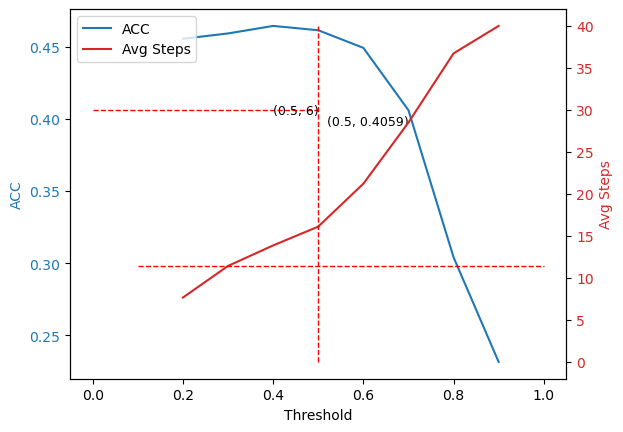

In [66]:
# df_threshold_study_gpt4 = df_threshold_study
df_threshold_study_gpt4_all = df_3
th_casc_steps = df_threshold_study_gpt4_all['CASC_Avg_Cost'].to_numpy()
th_casc_acc = df_threshold_study_gpt4_all['CASC_ACC'].to_numpy()
th_casc_threshold = df_threshold_study_gpt4_all['threshold'].to_numpy()
# Create a figure and axis
fig, ax1 = plt.subplots()

# Plot the first line (ACC) with ax1
color = 'tab:blue'
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Accuracy', color=color)
line1, = ax1.plot(th_casc_threshold, th_casc_acc, color=color, label='ACC')
ax1.tick_params(axis='y', labelcolor=color)
# plt.hlines(y=th_casc_acc[5], xmin=0, xmax=0.5, color='red', linestyle='--', linewidth=1)
# plt.annotate(f'({0.5}, {th_casc_acc[5]})', xy=(0.5, th_casc_acc[5]), 
#                  xytext=(0.5 + 0.02, th_casc_acc[5]-0.01),
#                  fontsize=9, color='black')
# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Avg Num. Samples Generated', color=color)
line2, = ax2.plot(th_casc_threshold, th_casc_steps, color=color, label='Avg Num. Samples Generated')
ax2.tick_params(axis='y', labelcolor=color)
# plt.vlines(x=0.5, ymin=0, ymax=40, color='red', linestyle='--', linewidth=1)
# plt.hlines(y=th_casc_steps[1], xmin=0.1, xmax=1, color='red', linestyle='--', linewidth=1)
# plt.annotate(f'({0.5}, {6})', xy=(0.5, th_casc_steps[5]), 
#                  xytext=(0.5 - 0.1, th_casc_steps[5]+1),
#                  fontsize=9, color='black')
# Combine legends
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left')
plt.savefig("Threshold.pdf", format="pdf", bbox_inches="tight")
# Show the plot
plt.show()

In [ ]:
1

In [ ]:
sns.lineplot( x=th_casc_steps, y=th_casc_acc, label='ACC', linestyle='-')

In [ ]:
th_casc_acc[5]
th_casc_steps[5]

# Stop algo study

In [ ]:
# result_buffer = {
#         'llm': [],
#         'benchmark':[],
#         'N': [],
#         'stop_algo':[],
#         'threshold': [],
#         'SC_ACC': [],
#         'ES_ACC': [],
#         'ASC_ACC': [],
#         'CASC_ACC': [],
#         'SC_Avg_Cost': [],
#         'ES_Avg_Cost': [],
#         'ASC_Avg_Cost': [],
#         'CASC_Avg_Cost': [],
#     }
# for stop_mechanism in config['stop_algo']:
#     for benchmark in config['benchmark']:
#         for llm in config['llm']:
#             df_in = get_data(df_with_features,benchmark=benchmark,llm=llm)
#             print(llm,benchmark)
#             print('df_size is ',len(df_in))
#             df_cs, _ = config['approximator'][0](df=df_in, feature_li=feature_li, coe=coe, intercept=intercept)
#             N= 3
#             threshold = 0.5
#             df_results, _ = CS_early_stopping(df=df_cs, threshold=threshold, N=N, stop_mechanism=stop_mechanism)
#             df_model_comp_dict = {
#                     'llm': llm,
#                     'benchmark':benchmark,
#                     'N': N,
#                     'stop_algo':stop_mechanism,
#                     'threshold': threshold,
#                     'SC_ACC': round(df_results.SC_correctness.sum() / len(df_results),4),
#                     'ES_ACC': round(df_results.ES_correctness.sum() / len(df_results),4),
#                     'ASC_ACC': round(df_results.asc_correctness.sum() / len(df_results),4),
#                     'CASC_ACC': round(df_results.CS_correctness.sum() / len(df_results),4),
#                     'SC_Avg_Cost': 40,
#                     'ES_Avg_Cost': round(df_results.ES_steps.mean(),2),
#                     'ASC_Avg_Cost': round(df_results.asc_steps.mean(),2),
#                     'CASC_Avg_Cost': round(df_results.CS_steps.mean(),2),
#                 }
#             for key,val in df_model_comp_dict.items():
#                 result_buffer[key].append(val)

In [ ]:
# df_stop_algo_study = pd.DataFrame(result_buffer)
# df_stop_algo_study.to_csv('stop_algo_study_table.csv',index=False)
df_N_study_2 = pd.read_csv('../src/experiment_collection/N_study_table_ConsistencyN.csv')
df_N_study = pd.read_csv('../src/experiment_collection/N_study_table.csv')

In [ ]:
llm = 'all'
benchmark = 'all'
print(llm,benchmark)
sc_step_results = []
df_step = get_data(df_with_features,benchmark=benchmark,llm = llm)
for row_idx in range(len(df_step)):
    sample_results = []
    for i in range(40):
        if Counter(df_step['CoT answers'].iloc[row_idx][:i+1]).most_common(1)[0][0] == df_step['correct answer'].iloc[row_idx]:
            sample_results.append(1)
        else:
            sample_results.append(0)
    sc_step_results.append(sample_results)
sc_step_results = np.array(sc_step_results)
sc_step_results = sc_step_results.sum(axis=0)/sc_step_results.shape[0]

df_N_study_gpt4 = df_N_study[(df_N_study.llm == llm)]
df_N_study_gpt4_all = df_N_study_gpt4[df_N_study_gpt4.benchmark == benchmark]
casc_steps = df_N_study_gpt4_all['CASC_Avg_Cost'].to_numpy().astype(np.int32)
casc_acc = df_N_study_gpt4_all['CASC_ACC'].to_numpy()
casc_step_results = np.zeros(40)
for i, idx in enumerate(casc_steps):
    casc_step_results[idx] = casc_acc[i]
casc_step_results = replace_zeros_with_previous_nonzero(sc_step_results[0],casc_step_results)

df_N_study_gpt4_2 = df_N_study_2[(df_N_study_2.llm == llm)]
df_N_study_gpt4_2_all = df_N_study_gpt4_2[df_N_study_gpt4_2.benchmark == benchmark]
casc_steps_2 = df_N_study_gpt4_2_all['CASC_Avg_Cost'].to_numpy().astype(np.int32)
casc_acc_2 = df_N_study_gpt4_2_all['CASC_ACC'].to_numpy()
casc_step_results_2 = np.zeros(40)
for i, idx in enumerate(casc_steps_2):
    casc_step_results_2[idx] = casc_acc_2[i]
casc_step_results_2 = replace_zeros_with_previous_nonzero(sc_step_results[0],casc_step_results_2)

es_steps = []
es_acc = []
for i in range(16):
    df_es_step = calculate_ES_correctness(df_step,i+1)
    es_acc.append(round(df_es_step.ES_correctness.sum() / len(df_es_step),4))
    es_steps.append(df_es_step.ES_steps.mean().astype(np.int32))
es_step_results = np.zeros(40)
for i, idx in enumerate(es_steps):
    es_step_results[idx] = es_acc[i]
es_step_results = replace_zeros_with_previous_nonzero(sc_step_results[0],es_step_results)

asc_steps = []
asc_acc = []
for i in range(75,101):
    df_asc_step = calculate_ASC_correctness(df_step,i*0.01)
    asc_acc.append(round(df_asc_step.asc_correctness.sum() / len(df_asc_step),4))
    asc_steps.append(df_asc_step.asc_steps.mean().astype(np.int32))
asc_step_results = np.zeros(40)
for i, idx in enumerate(asc_steps):
    asc_step_results[idx-1] = asc_acc[i]
asc_step_results = replace_zeros_with_previous_nonzero(sc_step_results[0],asc_step_results)

step_study_plot_dict = {
    'Steps': np.arange(40)[1:],
    'SC': sc_step_results[1:],
    'ES': es_step_results[1:],
    'ASC': asc_step_results[1:],
    'CASC_PositiveN':casc_step_results[1:],
    'CASC_ConsistencyN':casc_step_results_2[1:]
}



plt.figure()
# sns.lineplot(data=step_study_plot_dict, x='Steps', y='SC', label='SC', linestyle='-')
# sns.lineplot(data=step_study_plot_dict, x='Steps', y='ES', label='ES', linestyle='-')
# sns.lineplot(data=step_study_plot_dict, x='Steps', y='ASC', label='ASC', linestyle='-')
sns.lineplot(data=step_study_plot_dict, x='Steps', y='CASC_PositiveN', label='CASC_PositiveN', linestyle='-')
sns.lineplot(data=step_study_plot_dict, x='Steps', y='CASC_ConsistencyN', label='CASC_ConsistencyN', linestyle='-')

# Set the x and y axis labels
plt.xlabel('Steps')
plt.ylabel('ACC')

# Find the intersection point
x_intercept = None
for i in range(len(step_study_plot_dict['Steps']) - 1):
    if step_study_plot_dict['CASC_PositiveN'][i] < sc_step_results.max() <= step_study_plot_dict['CASC_PositiveN'][i+1]:
        x_intercept = step_study_plot_dict['Steps'][i]+1
        break

# Add the horizontal line (red line)
plt.hlines(y=0.545, xmin=x_intercept, xmax=40, color='red', linestyle='--', linewidth=1)

# Add the vertical line at the intersection point
if x_intercept is not None:
    plt.vlines(x=x_intercept, ymin=sc_step_results.min(), ymax=0.545, color='red', linestyle='--', linewidth=1)
    plt.annotate(f'({x_intercept}, {0.545})', xy=(x_intercept, 0.545), 
                 xytext=(x_intercept - 5.7, 0.545),
                 fontsize=9, color='black')

# Display the plot
plt.legend()
plt.savefig('../src/experiment_collection/stop_algo_study_plot.jpg', dpi=300, bbox_inches='tight')
plt.plot()